In [1]:
# Author: Jack Kelly

In [2]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import time
import h5py
import kerastuner as kt
import os
import sys
import pathlib
import csv

In [3]:
# Reproducibility
seed = 9 # arbitrary number
np.random.seed(seed=seed)
tf.random.set_seed(seed=seed)

In [4]:
N_channels = 40
data_path = os.getcwd()
print(data_path)

/Users/jackkelly/Desktop/Submission


In [5]:
### IMPORT, RAMDOMIZE AND SCALE DATA ###
def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y

In [6]:
def load_TL_model(model_path):
    hypermodel = keras.models.load_model(model_path)
    model = tf.keras.Sequential()
    for layer in hypermodel.layers[:-1]: # go through until last layer
        layer.trainable=False
        model.add(layer)
    model.add(keras.layers.Dense(40, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-06), name='TL_Dense'))

    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])
    return model

# EDFA Networks

In [7]:
test_data_numbers = [200, 400, 800, 1200, 1600, 2000, 2400]

def TL_network_test(number):
    TL_model_results = []
    standard_devs = []
    for i in test_data_numbers:
        results = []
        file_path = (f'{data_path}/Data/TL_Data_EDFA/network{number}_{i}.csv')
        X_data, Y_data = processing_data(N_channels, file_path)
        for j in range(10):
            model = load_TL_model('Tuned_ANN_model.h5')
            X_train = np.concatenate((X_data[:int(j*i/10)],X_data[int((j+1)*i/10):]))
            Y_train = np.concatenate((Y_data[:int(j*i/10)],Y_data[int((j+1)*i/10):]))
            X_test = X_data[int(j*i/10):int((j+1)*i/10)]
            Y_test = Y_data[int(j*i/10):int((j+1)*i/10)]
            history = model.fit(X_train, Y_train, epochs=150, verbose=2)
            result = model.evaluate(X_test, Y_test, verbose=0)[1]
            results.append(result)
        TL_model_results.append(np.mean(results))
        standard_devs.append(np.std(results))
    return TL_model_results, standard_devs

In [8]:
TL_model_results_N1, standard_devs1 = TL_network_test('1')
TL_model_results_N2, standard_devs2 = TL_network_test('2')

Epoch 1/150
6/6 - 0s - loss: 0.4036 - mean_squared_error: 0.4030
Epoch 2/150
6/6 - 0s - loss: 0.3688 - mean_squared_error: 0.3683
Epoch 3/150
6/6 - 0s - loss: 0.3498 - mean_squared_error: 0.3492
Epoch 4/150
6/6 - 0s - loss: 0.3338 - mean_squared_error: 0.3333
Epoch 5/150
6/6 - 0s - loss: 0.3207 - mean_squared_error: 0.3202
Epoch 6/150
6/6 - 0s - loss: 0.3087 - mean_squared_error: 0.3081
Epoch 7/150
6/6 - 0s - loss: 0.2948 - mean_squared_error: 0.2942
Epoch 8/150
6/6 - 0s - loss: 0.2847 - mean_squared_error: 0.2841
Epoch 9/150
6/6 - 0s - loss: 0.2736 - mean_squared_error: 0.2731
Epoch 10/150
6/6 - 0s - loss: 0.2676 - mean_squared_error: 0.2670
Epoch 11/150
6/6 - 0s - loss: 0.2602 - mean_squared_error: 0.2596
Epoch 12/150
6/6 - 0s - loss: 0.2530 - mean_squared_error: 0.2524
Epoch 13/150
6/6 - 0s - loss: 0.2444 - mean_squared_error: 0.2438
Epoch 14/150
6/6 - 0s - loss: 0.2378 - mean_squared_error: 0.2372
Epoch 15/150
6/6 - 0s - loss: 0.2303 - mean_squared_error: 0.2297
Epoch 16/150
6/6 - 

Epoch 125/150
6/6 - 0s - loss: 0.0376 - mean_squared_error: 0.0370
Epoch 126/150
6/6 - 0s - loss: 0.0370 - mean_squared_error: 0.0364
Epoch 127/150
6/6 - 0s - loss: 0.0368 - mean_squared_error: 0.0362
Epoch 128/150
6/6 - 0s - loss: 0.0362 - mean_squared_error: 0.0356
Epoch 129/150
6/6 - 0s - loss: 0.0359 - mean_squared_error: 0.0353
Epoch 130/150
6/6 - 0s - loss: 0.0356 - mean_squared_error: 0.0350
Epoch 131/150
6/6 - 0s - loss: 0.0350 - mean_squared_error: 0.0345
Epoch 132/150
6/6 - 0s - loss: 0.0347 - mean_squared_error: 0.0341
Epoch 133/150
6/6 - 0s - loss: 0.0343 - mean_squared_error: 0.0337
Epoch 134/150
6/6 - 0s - loss: 0.0340 - mean_squared_error: 0.0334
Epoch 135/150
6/6 - 0s - loss: 0.0335 - mean_squared_error: 0.0330
Epoch 136/150
6/6 - 0s - loss: 0.0331 - mean_squared_error: 0.0326
Epoch 137/150
6/6 - 0s - loss: 0.0328 - mean_squared_error: 0.0322
Epoch 138/150
6/6 - 0s - loss: 0.0326 - mean_squared_error: 0.0320
Epoch 139/150
6/6 - 0s - loss: 0.0321 - mean_squared_error: 0.

Epoch 99/150
6/6 - 0s - loss: 0.0507 - mean_squared_error: 0.0501
Epoch 100/150
6/6 - 0s - loss: 0.0502 - mean_squared_error: 0.0496
Epoch 101/150
6/6 - 0s - loss: 0.0495 - mean_squared_error: 0.0490
Epoch 102/150
6/6 - 0s - loss: 0.0490 - mean_squared_error: 0.0484
Epoch 103/150
6/6 - 0s - loss: 0.0482 - mean_squared_error: 0.0476
Epoch 104/150
6/6 - 0s - loss: 0.0472 - mean_squared_error: 0.0466
Epoch 105/150
6/6 - 0s - loss: 0.0469 - mean_squared_error: 0.0463
Epoch 106/150
6/6 - 0s - loss: 0.0462 - mean_squared_error: 0.0456
Epoch 107/150
6/6 - 0s - loss: 0.0455 - mean_squared_error: 0.0449
Epoch 108/150
6/6 - 0s - loss: 0.0446 - mean_squared_error: 0.0440
Epoch 109/150
6/6 - 0s - loss: 0.0443 - mean_squared_error: 0.0437
Epoch 110/150
6/6 - 0s - loss: 0.0437 - mean_squared_error: 0.0431
Epoch 111/150
6/6 - 0s - loss: 0.0429 - mean_squared_error: 0.0423
Epoch 112/150
6/6 - 0s - loss: 0.0424 - mean_squared_error: 0.0418
Epoch 113/150
6/6 - 0s - loss: 0.0419 - mean_squared_error: 0.0

Epoch 73/150
6/6 - 0s - loss: 0.0918 - mean_squared_error: 0.0912
Epoch 74/150
6/6 - 0s - loss: 0.0907 - mean_squared_error: 0.0901
Epoch 75/150
6/6 - 0s - loss: 0.0898 - mean_squared_error: 0.0892
Epoch 76/150
6/6 - 0s - loss: 0.0889 - mean_squared_error: 0.0883
Epoch 77/150
6/6 - 0s - loss: 0.0873 - mean_squared_error: 0.0867
Epoch 78/150
6/6 - 0s - loss: 0.0862 - mean_squared_error: 0.0856
Epoch 79/150
6/6 - 0s - loss: 0.0852 - mean_squared_error: 0.0846
Epoch 80/150
6/6 - 0s - loss: 0.0841 - mean_squared_error: 0.0836
Epoch 81/150
6/6 - 0s - loss: 0.0830 - mean_squared_error: 0.0824
Epoch 82/150
6/6 - 0s - loss: 0.0822 - mean_squared_error: 0.0816
Epoch 83/150
6/6 - 0s - loss: 0.0810 - mean_squared_error: 0.0804
Epoch 84/150
6/6 - 0s - loss: 0.0804 - mean_squared_error: 0.0799
Epoch 85/150
6/6 - 0s - loss: 0.0793 - mean_squared_error: 0.0787
Epoch 86/150
6/6 - 0s - loss: 0.0784 - mean_squared_error: 0.0779
Epoch 87/150
6/6 - 0s - loss: 0.0776 - mean_squared_error: 0.0771
Epoch 88/1

Epoch 47/150
6/6 - 0s - loss: 0.1131 - mean_squared_error: 0.1125
Epoch 48/150
6/6 - 0s - loss: 0.1120 - mean_squared_error: 0.1114
Epoch 49/150
6/6 - 0s - loss: 0.1096 - mean_squared_error: 0.1090
Epoch 50/150
6/6 - 0s - loss: 0.1078 - mean_squared_error: 0.1072
Epoch 51/150
6/6 - 0s - loss: 0.1065 - mean_squared_error: 0.1060
Epoch 52/150
6/6 - 0s - loss: 0.1045 - mean_squared_error: 0.1039
Epoch 53/150
6/6 - 0s - loss: 0.1030 - mean_squared_error: 0.1025
Epoch 54/150
6/6 - 0s - loss: 0.1008 - mean_squared_error: 0.1003
Epoch 55/150
6/6 - 0s - loss: 0.0991 - mean_squared_error: 0.0985
Epoch 56/150
6/6 - 0s - loss: 0.0979 - mean_squared_error: 0.0973
Epoch 57/150
6/6 - 0s - loss: 0.0960 - mean_squared_error: 0.0954
Epoch 58/150
6/6 - 0s - loss: 0.0947 - mean_squared_error: 0.0942
Epoch 59/150
6/6 - 0s - loss: 0.0929 - mean_squared_error: 0.0923
Epoch 60/150
6/6 - 0s - loss: 0.0917 - mean_squared_error: 0.0911
Epoch 61/150
6/6 - 0s - loss: 0.0906 - mean_squared_error: 0.0900
Epoch 62/1

Epoch 21/150
6/6 - 0s - loss: 0.1838 - mean_squared_error: 0.1833
Epoch 22/150
6/6 - 0s - loss: 0.1802 - mean_squared_error: 0.1796
Epoch 23/150
6/6 - 0s - loss: 0.1767 - mean_squared_error: 0.1761
Epoch 24/150
6/6 - 0s - loss: 0.1732 - mean_squared_error: 0.1727
Epoch 25/150
6/6 - 0s - loss: 0.1700 - mean_squared_error: 0.1694
Epoch 26/150
6/6 - 0s - loss: 0.1674 - mean_squared_error: 0.1668
Epoch 27/150
6/6 - 0s - loss: 0.1644 - mean_squared_error: 0.1638
Epoch 28/150
6/6 - 0s - loss: 0.1615 - mean_squared_error: 0.1609
Epoch 29/150
6/6 - 0s - loss: 0.1590 - mean_squared_error: 0.1584
Epoch 30/150
6/6 - 0s - loss: 0.1558 - mean_squared_error: 0.1552
Epoch 31/150
6/6 - 0s - loss: 0.1533 - mean_squared_error: 0.1527
Epoch 32/150
6/6 - 0s - loss: 0.1508 - mean_squared_error: 0.1502
Epoch 33/150
6/6 - 0s - loss: 0.1483 - mean_squared_error: 0.1477
Epoch 34/150
6/6 - 0s - loss: 0.1463 - mean_squared_error: 0.1458
Epoch 35/150
6/6 - 0s - loss: 0.1437 - mean_squared_error: 0.1431
Epoch 36/1

Epoch 145/150
6/6 - 0s - loss: 0.0182 - mean_squared_error: 0.0176
Epoch 146/150
6/6 - 0s - loss: 0.0179 - mean_squared_error: 0.0173
Epoch 147/150
6/6 - 0s - loss: 0.0177 - mean_squared_error: 0.0171
Epoch 148/150
6/6 - 0s - loss: 0.0174 - mean_squared_error: 0.0168
Epoch 149/150
6/6 - 0s - loss: 0.0172 - mean_squared_error: 0.0166
Epoch 150/150
6/6 - 0s - loss: 0.0171 - mean_squared_error: 0.0165
Epoch 1/150
6/6 - 0s - loss: 0.3994 - mean_squared_error: 0.3988
Epoch 2/150
6/6 - 0s - loss: 0.3629 - mean_squared_error: 0.3623
Epoch 3/150
6/6 - 0s - loss: 0.3327 - mean_squared_error: 0.3321
Epoch 4/150
6/6 - 0s - loss: 0.3159 - mean_squared_error: 0.3154
Epoch 5/150
6/6 - 0s - loss: 0.2992 - mean_squared_error: 0.2987
Epoch 6/150
6/6 - 0s - loss: 0.2869 - mean_squared_error: 0.2864
Epoch 7/150
6/6 - 0s - loss: 0.2764 - mean_squared_error: 0.2758
Epoch 8/150
6/6 - 0s - loss: 0.2694 - mean_squared_error: 0.2688
Epoch 9/150
6/6 - 0s - loss: 0.2625 - mean_squared_error: 0.2619
Epoch 10/150


Epoch 108/150
6/6 - 0s - loss: 0.0444 - mean_squared_error: 0.0438
Epoch 109/150
6/6 - 0s - loss: 0.0437 - mean_squared_error: 0.0431
Epoch 110/150
6/6 - 0s - loss: 0.0431 - mean_squared_error: 0.0425
Epoch 111/150
6/6 - 0s - loss: 0.0428 - mean_squared_error: 0.0422
Epoch 112/150
6/6 - 0s - loss: 0.0421 - mean_squared_error: 0.0415
Epoch 113/150
6/6 - 0s - loss: 0.0414 - mean_squared_error: 0.0408
Epoch 114/150
6/6 - 0s - loss: 0.0408 - mean_squared_error: 0.0402
Epoch 115/150
6/6 - 0s - loss: 0.0401 - mean_squared_error: 0.0396
Epoch 116/150
6/6 - 0s - loss: 0.0397 - mean_squared_error: 0.0392
Epoch 117/150
6/6 - 0s - loss: 0.0390 - mean_squared_error: 0.0385
Epoch 118/150
6/6 - 0s - loss: 0.0387 - mean_squared_error: 0.0381
Epoch 119/150
6/6 - 0s - loss: 0.0380 - mean_squared_error: 0.0374
Epoch 120/150
6/6 - 0s - loss: 0.0379 - mean_squared_error: 0.0373
Epoch 121/150
6/6 - 0s - loss: 0.0373 - mean_squared_error: 0.0367
Epoch 122/150
6/6 - 0s - loss: 0.0368 - mean_squared_error: 0.

Epoch 71/150
6/6 - 0s - loss: 0.1041 - mean_squared_error: 0.1036
Epoch 72/150
6/6 - 0s - loss: 0.1031 - mean_squared_error: 0.1025
Epoch 73/150
6/6 - 0s - loss: 0.1019 - mean_squared_error: 0.1013
Epoch 74/150
6/6 - 0s - loss: 0.1005 - mean_squared_error: 0.1000
Epoch 75/150
6/6 - 0s - loss: 0.0997 - mean_squared_error: 0.0991
Epoch 76/150
6/6 - 0s - loss: 0.0986 - mean_squared_error: 0.0980
Epoch 77/150
6/6 - 0s - loss: 0.0973 - mean_squared_error: 0.0967
Epoch 78/150
6/6 - 0s - loss: 0.0963 - mean_squared_error: 0.0957
Epoch 79/150
6/6 - 0s - loss: 0.0954 - mean_squared_error: 0.0948
Epoch 80/150
6/6 - 0s - loss: 0.0945 - mean_squared_error: 0.0939
Epoch 81/150
6/6 - 0s - loss: 0.0938 - mean_squared_error: 0.0932
Epoch 82/150
6/6 - 0s - loss: 0.0928 - mean_squared_error: 0.0923
Epoch 83/150
6/6 - 0s - loss: 0.0919 - mean_squared_error: 0.0913
Epoch 84/150
6/6 - 0s - loss: 0.0909 - mean_squared_error: 0.0903
Epoch 85/150
6/6 - 0s - loss: 0.0901 - mean_squared_error: 0.0895
Epoch 86/1

6/6 - 0s - loss: 0.1369 - mean_squared_error: 0.1364
Epoch 34/150
6/6 - 0s - loss: 0.1346 - mean_squared_error: 0.1340
Epoch 35/150
6/6 - 0s - loss: 0.1318 - mean_squared_error: 0.1312
Epoch 36/150
6/6 - 0s - loss: 0.1292 - mean_squared_error: 0.1287
Epoch 37/150
6/6 - 0s - loss: 0.1275 - mean_squared_error: 0.1269
Epoch 38/150
6/6 - 0s - loss: 0.1252 - mean_squared_error: 0.1246
Epoch 39/150
6/6 - 0s - loss: 0.1230 - mean_squared_error: 0.1224
Epoch 40/150
6/6 - 0s - loss: 0.1206 - mean_squared_error: 0.1201
Epoch 41/150
6/6 - 0s - loss: 0.1186 - mean_squared_error: 0.1180
Epoch 42/150
6/6 - 0s - loss: 0.1166 - mean_squared_error: 0.1160
Epoch 43/150
6/6 - 0s - loss: 0.1145 - mean_squared_error: 0.1139
Epoch 44/150
6/6 - 0s - loss: 0.1122 - mean_squared_error: 0.1116
Epoch 45/150
6/6 - 0s - loss: 0.1105 - mean_squared_error: 0.1099
Epoch 46/150
6/6 - 0s - loss: 0.1085 - mean_squared_error: 0.1079
Epoch 47/150
6/6 - 0s - loss: 0.1067 - mean_squared_error: 0.1062
Epoch 48/150
6/6 - 0s -

Epoch 1/150
6/6 - 0s - loss: 0.4047 - mean_squared_error: 0.4041
Epoch 2/150
6/6 - 0s - loss: 0.3540 - mean_squared_error: 0.3534
Epoch 3/150
6/6 - 0s - loss: 0.3199 - mean_squared_error: 0.3194
Epoch 4/150
6/6 - 0s - loss: 0.2986 - mean_squared_error: 0.2980
Epoch 5/150
6/6 - 0s - loss: 0.2848 - mean_squared_error: 0.2842
Epoch 6/150
6/6 - 0s - loss: 0.2688 - mean_squared_error: 0.2682
Epoch 7/150
6/6 - 0s - loss: 0.2590 - mean_squared_error: 0.2584
Epoch 8/150
6/6 - 0s - loss: 0.2486 - mean_squared_error: 0.2480
Epoch 9/150
6/6 - 0s - loss: 0.2413 - mean_squared_error: 0.2407
Epoch 10/150
6/6 - 0s - loss: 0.2349 - mean_squared_error: 0.2343
Epoch 11/150
6/6 - 0s - loss: 0.2277 - mean_squared_error: 0.2271
Epoch 12/150
6/6 - 0s - loss: 0.2215 - mean_squared_error: 0.2209
Epoch 13/150
6/6 - 0s - loss: 0.2159 - mean_squared_error: 0.2153
Epoch 14/150
6/6 - 0s - loss: 0.2111 - mean_squared_error: 0.2105
Epoch 15/150
6/6 - 0s - loss: 0.2060 - mean_squared_error: 0.2054
Epoch 16/150
6/6 - 

Epoch 125/150
6/6 - 0s - loss: 0.0337 - mean_squared_error: 0.0331
Epoch 126/150
6/6 - 0s - loss: 0.0334 - mean_squared_error: 0.0328
Epoch 127/150
6/6 - 0s - loss: 0.0331 - mean_squared_error: 0.0325
Epoch 128/150
6/6 - 0s - loss: 0.0324 - mean_squared_error: 0.0318
Epoch 129/150
6/6 - 0s - loss: 0.0322 - mean_squared_error: 0.0316
Epoch 130/150
6/6 - 0s - loss: 0.0320 - mean_squared_error: 0.0314
Epoch 131/150
6/6 - 0s - loss: 0.0314 - mean_squared_error: 0.0308
Epoch 132/150
6/6 - 0s - loss: 0.0312 - mean_squared_error: 0.0306
Epoch 133/150
6/6 - 0s - loss: 0.0309 - mean_squared_error: 0.0303
Epoch 134/150
6/6 - 0s - loss: 0.0305 - mean_squared_error: 0.0299
Epoch 135/150
6/6 - 0s - loss: 0.0301 - mean_squared_error: 0.0295
Epoch 136/150
6/6 - 0s - loss: 0.0299 - mean_squared_error: 0.0293
Epoch 137/150
6/6 - 0s - loss: 0.0296 - mean_squared_error: 0.0290
Epoch 138/150
6/6 - 0s - loss: 0.0294 - mean_squared_error: 0.0288
Epoch 139/150
6/6 - 0s - loss: 0.0291 - mean_squared_error: 0.

Epoch 88/150
6/6 - 0s - loss: 0.0656 - mean_squared_error: 0.0650
Epoch 89/150
6/6 - 0s - loss: 0.0646 - mean_squared_error: 0.0641
Epoch 90/150
6/6 - 0s - loss: 0.0639 - mean_squared_error: 0.0633
Epoch 91/150
6/6 - 0s - loss: 0.0628 - mean_squared_error: 0.0623
Epoch 92/150
6/6 - 0s - loss: 0.0622 - mean_squared_error: 0.0616
Epoch 93/150
6/6 - 0s - loss: 0.0614 - mean_squared_error: 0.0608
Epoch 94/150
6/6 - 0s - loss: 0.0605 - mean_squared_error: 0.0599
Epoch 95/150
6/6 - 0s - loss: 0.0599 - mean_squared_error: 0.0593
Epoch 96/150
6/6 - 0s - loss: 0.0594 - mean_squared_error: 0.0588
Epoch 97/150
6/6 - 0s - loss: 0.0587 - mean_squared_error: 0.0581
Epoch 98/150
6/6 - 0s - loss: 0.0578 - mean_squared_error: 0.0572
Epoch 99/150
6/6 - 0s - loss: 0.0569 - mean_squared_error: 0.0563
Epoch 100/150
6/6 - 0s - loss: 0.0564 - mean_squared_error: 0.0558
Epoch 101/150
6/6 - 0s - loss: 0.0557 - mean_squared_error: 0.0551
Epoch 102/150
6/6 - 0s - loss: 0.0550 - mean_squared_error: 0.0544
Epoch 1

Epoch 49/150
12/12 - 0s - loss: 0.0539 - mean_squared_error: 0.0533
Epoch 50/150
12/12 - 0s - loss: 0.0520 - mean_squared_error: 0.0514
Epoch 51/150
12/12 - 0s - loss: 0.0498 - mean_squared_error: 0.0493
Epoch 52/150
12/12 - 0s - loss: 0.0479 - mean_squared_error: 0.0473
Epoch 53/150
12/12 - 0s - loss: 0.0465 - mean_squared_error: 0.0459
Epoch 54/150
12/12 - 0s - loss: 0.0446 - mean_squared_error: 0.0440
Epoch 55/150
12/12 - 0s - loss: 0.0431 - mean_squared_error: 0.0425
Epoch 56/150
12/12 - 0s - loss: 0.0416 - mean_squared_error: 0.0410
Epoch 57/150
12/12 - 0s - loss: 0.0397 - mean_squared_error: 0.0391
Epoch 58/150
12/12 - 0s - loss: 0.0383 - mean_squared_error: 0.0377
Epoch 59/150
12/12 - 0s - loss: 0.0374 - mean_squared_error: 0.0368
Epoch 60/150
12/12 - 0s - loss: 0.0357 - mean_squared_error: 0.0351
Epoch 61/150
12/12 - 0s - loss: 0.0346 - mean_squared_error: 0.0340
Epoch 62/150
12/12 - 0s - loss: 0.0334 - mean_squared_error: 0.0328
Epoch 63/150
12/12 - 0s - loss: 0.0327 - mean_sq

Epoch 8/150
12/12 - 0s - loss: 0.2330 - mean_squared_error: 0.2325
Epoch 9/150
12/12 - 0s - loss: 0.2206 - mean_squared_error: 0.2200
Epoch 10/150
12/12 - 0s - loss: 0.2135 - mean_squared_error: 0.2129
Epoch 11/150
12/12 - 0s - loss: 0.2076 - mean_squared_error: 0.2070
Epoch 12/150
12/12 - 0s - loss: 0.2012 - mean_squared_error: 0.2007
Epoch 13/150
12/12 - 0s - loss: 0.1959 - mean_squared_error: 0.1954
Epoch 14/150
12/12 - 0s - loss: 0.1872 - mean_squared_error: 0.1866
Epoch 15/150
12/12 - 0s - loss: 0.1808 - mean_squared_error: 0.1802
Epoch 16/150
12/12 - 0s - loss: 0.1762 - mean_squared_error: 0.1756
Epoch 17/150
12/12 - 0s - loss: 0.1729 - mean_squared_error: 0.1723
Epoch 18/150
12/12 - 0s - loss: 0.1690 - mean_squared_error: 0.1684
Epoch 19/150
12/12 - 0s - loss: 0.1646 - mean_squared_error: 0.1640
Epoch 20/150
12/12 - 0s - loss: 0.1575 - mean_squared_error: 0.1569
Epoch 21/150
12/12 - 0s - loss: 0.1524 - mean_squared_error: 0.1518
Epoch 22/150
12/12 - 0s - loss: 0.1493 - mean_squa

12/12 - 0s - loss: 0.0075 - mean_squared_error: 0.0069
Epoch 129/150
12/12 - 0s - loss: 0.0074 - mean_squared_error: 0.0068
Epoch 130/150
12/12 - 0s - loss: 0.0073 - mean_squared_error: 0.0067
Epoch 131/150
12/12 - 0s - loss: 0.0072 - mean_squared_error: 0.0066
Epoch 132/150
12/12 - 0s - loss: 0.0071 - mean_squared_error: 0.0065
Epoch 133/150
12/12 - 0s - loss: 0.0071 - mean_squared_error: 0.0064
Epoch 134/150
12/12 - 0s - loss: 0.0068 - mean_squared_error: 0.0062
Epoch 135/150
12/12 - 0s - loss: 0.0068 - mean_squared_error: 0.0062
Epoch 136/150
12/12 - 0s - loss: 0.0067 - mean_squared_error: 0.0061
Epoch 137/150
12/12 - 0s - loss: 0.0066 - mean_squared_error: 0.0060
Epoch 138/150
12/12 - 0s - loss: 0.0065 - mean_squared_error: 0.0059
Epoch 139/150
12/12 - 0s - loss: 0.0064 - mean_squared_error: 0.0058
Epoch 140/150
12/12 - 0s - loss: 0.0064 - mean_squared_error: 0.0058
Epoch 141/150
12/12 - 0s - loss: 0.0062 - mean_squared_error: 0.0056
Epoch 142/150
12/12 - 0s - loss: 0.0062 - mean_s

Epoch 88/150
12/12 - 0s - loss: 0.0280 - mean_squared_error: 0.0274
Epoch 89/150
12/12 - 0s - loss: 0.0276 - mean_squared_error: 0.0270
Epoch 90/150
12/12 - 0s - loss: 0.0272 - mean_squared_error: 0.0266
Epoch 91/150
12/12 - 0s - loss: 0.0268 - mean_squared_error: 0.0262
Epoch 92/150
12/12 - 0s - loss: 0.0264 - mean_squared_error: 0.0259
Epoch 93/150
12/12 - 0s - loss: 0.0260 - mean_squared_error: 0.0254
Epoch 94/150
12/12 - 0s - loss: 0.0259 - mean_squared_error: 0.0253
Epoch 95/150
12/12 - 0s - loss: 0.0254 - mean_squared_error: 0.0248
Epoch 96/150
12/12 - 0s - loss: 0.0251 - mean_squared_error: 0.0245
Epoch 97/150
12/12 - 0s - loss: 0.0248 - mean_squared_error: 0.0242
Epoch 98/150
12/12 - 0s - loss: 0.0246 - mean_squared_error: 0.0240
Epoch 99/150
12/12 - 0s - loss: 0.0242 - mean_squared_error: 0.0236
Epoch 100/150
12/12 - 0s - loss: 0.0238 - mean_squared_error: 0.0232
Epoch 101/150
12/12 - 0s - loss: 0.0236 - mean_squared_error: 0.0230
Epoch 102/150
12/12 - 0s - loss: 0.0235 - mean

Epoch 47/150
12/12 - 0s - loss: 0.0627 - mean_squared_error: 0.0621
Epoch 48/150
12/12 - 0s - loss: 0.0608 - mean_squared_error: 0.0602
Epoch 49/150
12/12 - 0s - loss: 0.0592 - mean_squared_error: 0.0586
Epoch 50/150
12/12 - 0s - loss: 0.0573 - mean_squared_error: 0.0567
Epoch 51/150
12/12 - 0s - loss: 0.0546 - mean_squared_error: 0.0540
Epoch 52/150
12/12 - 0s - loss: 0.0528 - mean_squared_error: 0.0522
Epoch 53/150
12/12 - 0s - loss: 0.0514 - mean_squared_error: 0.0508
Epoch 54/150
12/12 - 0s - loss: 0.0491 - mean_squared_error: 0.0485
Epoch 55/150
12/12 - 0s - loss: 0.0483 - mean_squared_error: 0.0477
Epoch 56/150
12/12 - 0s - loss: 0.0462 - mean_squared_error: 0.0456
Epoch 57/150
12/12 - 0s - loss: 0.0446 - mean_squared_error: 0.0440
Epoch 58/150
12/12 - 0s - loss: 0.0430 - mean_squared_error: 0.0424
Epoch 59/150
12/12 - 0s - loss: 0.0416 - mean_squared_error: 0.0410
Epoch 60/150
12/12 - 0s - loss: 0.0400 - mean_squared_error: 0.0394
Epoch 61/150
12/12 - 0s - loss: 0.0389 - mean_sq

Epoch 6/150
12/12 - 0s - loss: 0.2649 - mean_squared_error: 0.2643
Epoch 7/150
12/12 - 0s - loss: 0.2552 - mean_squared_error: 0.2546
Epoch 8/150
12/12 - 0s - loss: 0.2443 - mean_squared_error: 0.2437
Epoch 9/150
12/12 - 0s - loss: 0.2321 - mean_squared_error: 0.2315
Epoch 10/150
12/12 - 0s - loss: 0.2236 - mean_squared_error: 0.2230
Epoch 11/150
12/12 - 0s - loss: 0.2156 - mean_squared_error: 0.2151
Epoch 12/150
12/12 - 0s - loss: 0.2069 - mean_squared_error: 0.2063
Epoch 13/150
12/12 - 0s - loss: 0.2004 - mean_squared_error: 0.1998
Epoch 14/150
12/12 - 0s - loss: 0.1945 - mean_squared_error: 0.1939
Epoch 15/150
12/12 - 0s - loss: 0.1862 - mean_squared_error: 0.1856
Epoch 16/150
12/12 - 0s - loss: 0.1800 - mean_squared_error: 0.1794
Epoch 17/150
12/12 - 0s - loss: 0.1756 - mean_squared_error: 0.1751
Epoch 18/150
12/12 - 0s - loss: 0.1719 - mean_squared_error: 0.1713
Epoch 19/150
12/12 - 0s - loss: 0.1682 - mean_squared_error: 0.1677
Epoch 20/150
12/12 - 0s - loss: 0.1608 - mean_square

12/12 - 0s - loss: 0.0194 - mean_squared_error: 0.0188
Epoch 127/150
12/12 - 0s - loss: 0.0193 - mean_squared_error: 0.0187
Epoch 128/150
12/12 - 0s - loss: 0.0192 - mean_squared_error: 0.0186
Epoch 129/150
12/12 - 0s - loss: 0.0191 - mean_squared_error: 0.0185
Epoch 130/150
12/12 - 0s - loss: 0.0190 - mean_squared_error: 0.0184
Epoch 131/150
12/12 - 0s - loss: 0.0189 - mean_squared_error: 0.0183
Epoch 132/150
12/12 - 0s - loss: 0.0188 - mean_squared_error: 0.0182
Epoch 133/150
12/12 - 0s - loss: 0.0188 - mean_squared_error: 0.0182
Epoch 134/150
12/12 - 0s - loss: 0.0186 - mean_squared_error: 0.0180
Epoch 135/150
12/12 - 0s - loss: 0.0186 - mean_squared_error: 0.0180
Epoch 136/150
12/12 - 0s - loss: 0.0185 - mean_squared_error: 0.0179
Epoch 137/150
12/12 - 0s - loss: 0.0184 - mean_squared_error: 0.0178
Epoch 138/150
12/12 - 0s - loss: 0.0183 - mean_squared_error: 0.0177
Epoch 139/150
12/12 - 0s - loss: 0.0182 - mean_squared_error: 0.0176
Epoch 140/150
12/12 - 0s - loss: 0.0182 - mean_s

Epoch 86/150
12/12 - 0s - loss: 0.0160 - mean_squared_error: 0.0155
Epoch 87/150
12/12 - 0s - loss: 0.0158 - mean_squared_error: 0.0152
Epoch 88/150
12/12 - 0s - loss: 0.0153 - mean_squared_error: 0.0147
Epoch 89/150
12/12 - 0s - loss: 0.0152 - mean_squared_error: 0.0146
Epoch 90/150
12/12 - 0s - loss: 0.0146 - mean_squared_error: 0.0140
Epoch 91/150
12/12 - 0s - loss: 0.0143 - mean_squared_error: 0.0137
Epoch 92/150
12/12 - 0s - loss: 0.0139 - mean_squared_error: 0.0133
Epoch 93/150
12/12 - 0s - loss: 0.0136 - mean_squared_error: 0.0130
Epoch 94/150
12/12 - 0s - loss: 0.0134 - mean_squared_error: 0.0128
Epoch 95/150
12/12 - 0s - loss: 0.0129 - mean_squared_error: 0.0124
Epoch 96/150
12/12 - 0s - loss: 0.0127 - mean_squared_error: 0.0121
Epoch 97/150
12/12 - 0s - loss: 0.0124 - mean_squared_error: 0.0118
Epoch 98/150
12/12 - 0s - loss: 0.0125 - mean_squared_error: 0.0119
Epoch 99/150
12/12 - 0s - loss: 0.0121 - mean_squared_error: 0.0115
Epoch 100/150
12/12 - 0s - loss: 0.0118 - mean_s

Epoch 45/150
12/12 - 0s - loss: 0.0609 - mean_squared_error: 0.0603
Epoch 46/150
12/12 - 0s - loss: 0.0585 - mean_squared_error: 0.0579
Epoch 47/150
12/12 - 0s - loss: 0.0564 - mean_squared_error: 0.0558
Epoch 48/150
12/12 - 0s - loss: 0.0539 - mean_squared_error: 0.0533
Epoch 49/150
12/12 - 0s - loss: 0.0528 - mean_squared_error: 0.0522
Epoch 50/150
12/12 - 0s - loss: 0.0515 - mean_squared_error: 0.0509
Epoch 51/150
12/12 - 0s - loss: 0.0498 - mean_squared_error: 0.0492
Epoch 52/150
12/12 - 0s - loss: 0.0477 - mean_squared_error: 0.0471
Epoch 53/150
12/12 - 0s - loss: 0.0454 - mean_squared_error: 0.0448
Epoch 54/150
12/12 - 0s - loss: 0.0449 - mean_squared_error: 0.0443
Epoch 55/150
12/12 - 0s - loss: 0.0427 - mean_squared_error: 0.0421
Epoch 56/150
12/12 - 0s - loss: 0.0416 - mean_squared_error: 0.0410
Epoch 57/150
12/12 - 0s - loss: 0.0397 - mean_squared_error: 0.0391
Epoch 58/150
12/12 - 0s - loss: 0.0385 - mean_squared_error: 0.0380
Epoch 59/150
12/12 - 0s - loss: 0.0374 - mean_sq

Epoch 4/150
12/12 - 0s - loss: 0.2773 - mean_squared_error: 0.2767
Epoch 5/150
12/12 - 0s - loss: 0.2568 - mean_squared_error: 0.2562
Epoch 6/150
12/12 - 0s - loss: 0.2433 - mean_squared_error: 0.2427
Epoch 7/150
12/12 - 0s - loss: 0.2316 - mean_squared_error: 0.2310
Epoch 8/150
12/12 - 0s - loss: 0.2218 - mean_squared_error: 0.2212
Epoch 9/150
12/12 - 0s - loss: 0.2121 - mean_squared_error: 0.2116
Epoch 10/150
12/12 - 0s - loss: 0.2044 - mean_squared_error: 0.2038
Epoch 11/150
12/12 - 0s - loss: 0.1981 - mean_squared_error: 0.1975
Epoch 12/150
12/12 - 0s - loss: 0.1933 - mean_squared_error: 0.1927
Epoch 13/150
12/12 - 0s - loss: 0.1880 - mean_squared_error: 0.1875
Epoch 14/150
12/12 - 0s - loss: 0.1820 - mean_squared_error: 0.1814
Epoch 15/150
12/12 - 0s - loss: 0.1766 - mean_squared_error: 0.1760
Epoch 16/150
12/12 - 0s - loss: 0.1728 - mean_squared_error: 0.1722
Epoch 17/150
12/12 - 0s - loss: 0.1696 - mean_squared_error: 0.1690
Epoch 18/150
12/12 - 0s - loss: 0.1654 - mean_squared_

Epoch 125/150
12/12 - 0s - loss: 0.0076 - mean_squared_error: 0.0070
Epoch 126/150
12/12 - 0s - loss: 0.0075 - mean_squared_error: 0.0069
Epoch 127/150
12/12 - 0s - loss: 0.0073 - mean_squared_error: 0.0067
Epoch 128/150
12/12 - 0s - loss: 0.0072 - mean_squared_error: 0.0066
Epoch 129/150
12/12 - 0s - loss: 0.0072 - mean_squared_error: 0.0066
Epoch 130/150
12/12 - 0s - loss: 0.0071 - mean_squared_error: 0.0065
Epoch 131/150
12/12 - 0s - loss: 0.0069 - mean_squared_error: 0.0063
Epoch 132/150
12/12 - 0s - loss: 0.0069 - mean_squared_error: 0.0063
Epoch 133/150
12/12 - 0s - loss: 0.0068 - mean_squared_error: 0.0062
Epoch 134/150
12/12 - 0s - loss: 0.0067 - mean_squared_error: 0.0061
Epoch 135/150
12/12 - 0s - loss: 0.0066 - mean_squared_error: 0.0060
Epoch 136/150
12/12 - 0s - loss: 0.0065 - mean_squared_error: 0.0059
Epoch 137/150
12/12 - 0s - loss: 0.0064 - mean_squared_error: 0.0058
Epoch 138/150
12/12 - 0s - loss: 0.0063 - mean_squared_error: 0.0057
Epoch 139/150
12/12 - 0s - loss: 0

12/12 - 0s - loss: 0.0219 - mean_squared_error: 0.0213
Epoch 85/150
12/12 - 0s - loss: 0.0214 - mean_squared_error: 0.0208
Epoch 86/150
12/12 - 0s - loss: 0.0207 - mean_squared_error: 0.0201
Epoch 87/150
12/12 - 0s - loss: 0.0201 - mean_squared_error: 0.0195
Epoch 88/150
12/12 - 0s - loss: 0.0195 - mean_squared_error: 0.0189
Epoch 89/150
12/12 - 0s - loss: 0.0193 - mean_squared_error: 0.0187
Epoch 90/150
12/12 - 0s - loss: 0.0188 - mean_squared_error: 0.0182
Epoch 91/150
12/12 - 0s - loss: 0.0179 - mean_squared_error: 0.0173
Epoch 92/150
12/12 - 0s - loss: 0.0176 - mean_squared_error: 0.0171
Epoch 93/150
12/12 - 0s - loss: 0.0172 - mean_squared_error: 0.0166
Epoch 94/150
12/12 - 0s - loss: 0.0170 - mean_squared_error: 0.0164
Epoch 95/150
12/12 - 0s - loss: 0.0162 - mean_squared_error: 0.0157
Epoch 96/150
12/12 - 0s - loss: 0.0158 - mean_squared_error: 0.0152
Epoch 97/150
12/12 - 0s - loss: 0.0154 - mean_squared_error: 0.0148
Epoch 98/150
12/12 - 0s - loss: 0.0152 - mean_squared_error: 

Epoch 43/150
12/12 - 0s - loss: 0.0762 - mean_squared_error: 0.0756
Epoch 44/150
12/12 - 0s - loss: 0.0746 - mean_squared_error: 0.0740
Epoch 45/150
12/12 - 0s - loss: 0.0709 - mean_squared_error: 0.0703
Epoch 46/150
12/12 - 0s - loss: 0.0648 - mean_squared_error: 0.0642
Epoch 47/150
12/12 - 0s - loss: 0.0615 - mean_squared_error: 0.0609
Epoch 48/150
12/12 - 0s - loss: 0.0595 - mean_squared_error: 0.0590
Epoch 49/150
12/12 - 0s - loss: 0.0574 - mean_squared_error: 0.0568
Epoch 50/150
12/12 - 0s - loss: 0.0555 - mean_squared_error: 0.0549
Epoch 51/150
12/12 - 0s - loss: 0.0528 - mean_squared_error: 0.0522
Epoch 52/150
12/12 - 0s - loss: 0.0505 - mean_squared_error: 0.0500
Epoch 53/150
12/12 - 0s - loss: 0.0482 - mean_squared_error: 0.0476
Epoch 54/150
12/12 - 0s - loss: 0.0468 - mean_squared_error: 0.0462
Epoch 55/150
12/12 - 0s - loss: 0.0446 - mean_squared_error: 0.0441
Epoch 56/150
12/12 - 0s - loss: 0.0436 - mean_squared_error: 0.0430
Epoch 57/150
12/12 - 0s - loss: 0.0418 - mean_sq

Epoch 2/150
23/23 - 0s - loss: 0.2793 - mean_squared_error: 0.2787
Epoch 3/150
23/23 - 0s - loss: 0.2501 - mean_squared_error: 0.2495
Epoch 4/150
23/23 - 0s - loss: 0.2292 - mean_squared_error: 0.2286
Epoch 5/150
23/23 - 0s - loss: 0.2076 - mean_squared_error: 0.2070
Epoch 6/150
23/23 - 0s - loss: 0.1931 - mean_squared_error: 0.1925
Epoch 7/150
23/23 - 0s - loss: 0.1800 - mean_squared_error: 0.1794
Epoch 8/150
23/23 - 0s - loss: 0.1682 - mean_squared_error: 0.1677
Epoch 9/150
23/23 - 0s - loss: 0.1591 - mean_squared_error: 0.1585
Epoch 10/150
23/23 - 0s - loss: 0.1517 - mean_squared_error: 0.1511
Epoch 11/150
23/23 - 0s - loss: 0.1440 - mean_squared_error: 0.1435
Epoch 12/150
23/23 - 0s - loss: 0.1380 - mean_squared_error: 0.1374
Epoch 13/150
23/23 - 0s - loss: 0.1305 - mean_squared_error: 0.1299
Epoch 14/150
23/23 - 0s - loss: 0.1236 - mean_squared_error: 0.1230
Epoch 15/150
23/23 - 0s - loss: 0.1143 - mean_squared_error: 0.1137
Epoch 16/150
23/23 - 0s - loss: 0.1065 - mean_squared_er

Epoch 123/150
23/23 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 124/150
23/23 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 125/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 126/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 127/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 128/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 129/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 130/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 131/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 132/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 133/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 134/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 135/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 136/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 137/150
23/23 - 0s - loss: 0

23/23 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 83/150
23/23 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 84/150
23/23 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 85/150
23/23 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 86/150
23/23 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 87/150
23/23 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 88/150
23/23 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 89/150
23/23 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 90/150
23/23 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 91/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 92/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 93/150
23/23 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 94/150
23/23 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 95/150
23/23 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 96/150
23/23 - 0s - loss: 0.0039 - mean_squared_error: 

Epoch 41/150
23/23 - 0s - loss: 0.0191 - mean_squared_error: 0.0185
Epoch 42/150
23/23 - 0s - loss: 0.0180 - mean_squared_error: 0.0174
Epoch 43/150
23/23 - 0s - loss: 0.0172 - mean_squared_error: 0.0166
Epoch 44/150
23/23 - 0s - loss: 0.0162 - mean_squared_error: 0.0156
Epoch 45/150
23/23 - 0s - loss: 0.0155 - mean_squared_error: 0.0149
Epoch 46/150
23/23 - 0s - loss: 0.0148 - mean_squared_error: 0.0142
Epoch 47/150
23/23 - 0s - loss: 0.0141 - mean_squared_error: 0.0135
Epoch 48/150
23/23 - 0s - loss: 0.0135 - mean_squared_error: 0.0129
Epoch 49/150
23/23 - 0s - loss: 0.0129 - mean_squared_error: 0.0123
Epoch 50/150
23/23 - 0s - loss: 0.0123 - mean_squared_error: 0.0117
Epoch 51/150
23/23 - 0s - loss: 0.0118 - mean_squared_error: 0.0112
Epoch 52/150
23/23 - 0s - loss: 0.0114 - mean_squared_error: 0.0108
Epoch 53/150
23/23 - 0s - loss: 0.0109 - mean_squared_error: 0.0103
Epoch 54/150
23/23 - 0s - loss: 0.0105 - mean_squared_error: 0.0100
Epoch 55/150
23/23 - 0s - loss: 0.0102 - mean_sq

Epoch 1/150
23/23 - 0s - loss: 0.3640 - mean_squared_error: 0.3635
Epoch 2/150
23/23 - 0s - loss: 0.3171 - mean_squared_error: 0.3166
Epoch 3/150
23/23 - 0s - loss: 0.2934 - mean_squared_error: 0.2928
Epoch 4/150
23/23 - 0s - loss: 0.2722 - mean_squared_error: 0.2716
Epoch 5/150
23/23 - 0s - loss: 0.2439 - mean_squared_error: 0.2433
Epoch 6/150
23/23 - 0s - loss: 0.2295 - mean_squared_error: 0.2289
Epoch 7/150
23/23 - 0s - loss: 0.2167 - mean_squared_error: 0.2161
Epoch 8/150
23/23 - 0s - loss: 0.1989 - mean_squared_error: 0.1983
Epoch 9/150
23/23 - 0s - loss: 0.1839 - mean_squared_error: 0.1834
Epoch 10/150
23/23 - 0s - loss: 0.1749 - mean_squared_error: 0.1743
Epoch 11/150
23/23 - 0s - loss: 0.1661 - mean_squared_error: 0.1656
Epoch 12/150
23/23 - 0s - loss: 0.1591 - mean_squared_error: 0.1586
Epoch 13/150
23/23 - 0s - loss: 0.1511 - mean_squared_error: 0.1505
Epoch 14/150
23/23 - 0s - loss: 0.1451 - mean_squared_error: 0.1445
Epoch 15/150
23/23 - 0s - loss: 0.1378 - mean_squared_err

Epoch 122/150
23/23 - 0s - loss: 0.0037 - mean_squared_error: 0.0030
Epoch 123/150
23/23 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 124/150
23/23 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 125/150
23/23 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 126/150
23/23 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 127/150
23/23 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 128/150
23/23 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 129/150
23/23 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 130/150
23/23 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 131/150
23/23 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 132/150
23/23 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 133/150
23/23 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 134/150
23/23 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 135/150
23/23 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 136/150
23/23 - 0s - loss: 0

23/23 - 0s - loss: 0.0162 - mean_squared_error: 0.0156
Epoch 82/150
23/23 - 0s - loss: 0.0161 - mean_squared_error: 0.0155
Epoch 83/150
23/23 - 0s - loss: 0.0160 - mean_squared_error: 0.0154
Epoch 84/150
23/23 - 0s - loss: 0.0159 - mean_squared_error: 0.0153
Epoch 85/150
23/23 - 0s - loss: 0.0159 - mean_squared_error: 0.0153
Epoch 86/150
23/23 - 0s - loss: 0.0158 - mean_squared_error: 0.0152
Epoch 87/150
23/23 - 0s - loss: 0.0157 - mean_squared_error: 0.0151
Epoch 88/150
23/23 - 0s - loss: 0.0156 - mean_squared_error: 0.0150
Epoch 89/150
23/23 - 0s - loss: 0.0155 - mean_squared_error: 0.0149
Epoch 90/150
23/23 - 0s - loss: 0.0154 - mean_squared_error: 0.0148
Epoch 91/150
23/23 - 0s - loss: 0.0154 - mean_squared_error: 0.0148
Epoch 92/150
23/23 - 0s - loss: 0.0153 - mean_squared_error: 0.0147
Epoch 93/150
23/23 - 0s - loss: 0.0152 - mean_squared_error: 0.0146
Epoch 94/150
23/23 - 0s - loss: 0.0152 - mean_squared_error: 0.0146
Epoch 95/150
23/23 - 0s - loss: 0.0151 - mean_squared_error: 

Epoch 40/150
23/23 - 0s - loss: 0.0315 - mean_squared_error: 0.0309
Epoch 41/150
23/23 - 0s - loss: 0.0307 - mean_squared_error: 0.0301
Epoch 42/150
23/23 - 0s - loss: 0.0260 - mean_squared_error: 0.0254
Epoch 43/150
23/23 - 0s - loss: 0.0216 - mean_squared_error: 0.0210
Epoch 44/150
23/23 - 0s - loss: 0.0199 - mean_squared_error: 0.0193
Epoch 45/150
23/23 - 0s - loss: 0.0186 - mean_squared_error: 0.0181
Epoch 46/150
23/23 - 0s - loss: 0.0176 - mean_squared_error: 0.0170
Epoch 47/150
23/23 - 0s - loss: 0.0165 - mean_squared_error: 0.0160
Epoch 48/150
23/23 - 0s - loss: 0.0159 - mean_squared_error: 0.0153
Epoch 49/150
23/23 - 0s - loss: 0.0153 - mean_squared_error: 0.0147
Epoch 50/150
23/23 - 0s - loss: 0.0142 - mean_squared_error: 0.0136
Epoch 51/150
23/23 - 0s - loss: 0.0136 - mean_squared_error: 0.0130
Epoch 52/150
23/23 - 0s - loss: 0.0130 - mean_squared_error: 0.0124
Epoch 53/150
23/23 - 0s - loss: 0.0122 - mean_squared_error: 0.0116
Epoch 54/150
23/23 - 0s - loss: 0.0118 - mean_sq

Epoch 1/150
23/23 - 0s - loss: 0.3471 - mean_squared_error: 0.3465
Epoch 2/150
23/23 - 0s - loss: 0.2903 - mean_squared_error: 0.2898
Epoch 3/150
23/23 - 0s - loss: 0.2606 - mean_squared_error: 0.2600
Epoch 4/150
23/23 - 0s - loss: 0.2374 - mean_squared_error: 0.2368
Epoch 5/150
23/23 - 0s - loss: 0.2205 - mean_squared_error: 0.2199
Epoch 6/150
23/23 - 0s - loss: 0.2071 - mean_squared_error: 0.2065
Epoch 7/150
23/23 - 0s - loss: 0.1929 - mean_squared_error: 0.1923
Epoch 8/150
23/23 - 0s - loss: 0.1812 - mean_squared_error: 0.1806
Epoch 9/150
23/23 - 0s - loss: 0.1711 - mean_squared_error: 0.1705
Epoch 10/150
23/23 - 0s - loss: 0.1626 - mean_squared_error: 0.1620
Epoch 11/150
23/23 - 0s - loss: 0.1561 - mean_squared_error: 0.1555
Epoch 12/150
23/23 - 0s - loss: 0.1491 - mean_squared_error: 0.1486
Epoch 13/150
23/23 - 0s - loss: 0.1406 - mean_squared_error: 0.1400
Epoch 14/150
23/23 - 0s - loss: 0.1339 - mean_squared_error: 0.1334
Epoch 15/150
23/23 - 0s - loss: 0.1253 - mean_squared_err

Epoch 122/150
23/23 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 123/150
23/23 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 124/150
23/23 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 125/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 126/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 127/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 128/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 129/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 130/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 131/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 132/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 133/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 134/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 135/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 136/150
23/23 - 0s - loss: 0

23/23 - 0s - loss: 0.0051 - mean_squared_error: 0.0045
Epoch 82/150
23/23 - 0s - loss: 0.0050 - mean_squared_error: 0.0043
Epoch 83/150
23/23 - 0s - loss: 0.0049 - mean_squared_error: 0.0042
Epoch 84/150
23/23 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 85/150
23/23 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 86/150
23/23 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 87/150
23/23 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 88/150
23/23 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 89/150
23/23 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 90/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 91/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 92/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 93/150
23/23 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 94/150
23/23 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 95/150
23/23 - 0s - loss: 0.0039 - mean_squared_error: 

Epoch 40/150
23/23 - 0s - loss: 0.0418 - mean_squared_error: 0.0412
Epoch 41/150
23/23 - 0s - loss: 0.0409 - mean_squared_error: 0.0403
Epoch 42/150
23/23 - 0s - loss: 0.0398 - mean_squared_error: 0.0392
Epoch 43/150
23/23 - 0s - loss: 0.0352 - mean_squared_error: 0.0347
Epoch 44/150
23/23 - 0s - loss: 0.0317 - mean_squared_error: 0.0311
Epoch 45/150
23/23 - 0s - loss: 0.0303 - mean_squared_error: 0.0297
Epoch 46/150
23/23 - 0s - loss: 0.0290 - mean_squared_error: 0.0285
Epoch 47/150
23/23 - 0s - loss: 0.0279 - mean_squared_error: 0.0273
Epoch 48/150
23/23 - 0s - loss: 0.0273 - mean_squared_error: 0.0267
Epoch 49/150
23/23 - 0s - loss: 0.0266 - mean_squared_error: 0.0261
Epoch 50/150
23/23 - 0s - loss: 0.0256 - mean_squared_error: 0.0250
Epoch 51/150
23/23 - 0s - loss: 0.0249 - mean_squared_error: 0.0243
Epoch 52/150
23/23 - 0s - loss: 0.0242 - mean_squared_error: 0.0236
Epoch 53/150
23/23 - 0s - loss: 0.0235 - mean_squared_error: 0.0229
Epoch 54/150
23/23 - 0s - loss: 0.0229 - mean_sq

Epoch 1/150
23/23 - 0s - loss: 0.3697 - mean_squared_error: 0.3691
Epoch 2/150
23/23 - 0s - loss: 0.2929 - mean_squared_error: 0.2923
Epoch 3/150
23/23 - 0s - loss: 0.2587 - mean_squared_error: 0.2581
Epoch 4/150
23/23 - 0s - loss: 0.2327 - mean_squared_error: 0.2321
Epoch 5/150
23/23 - 0s - loss: 0.2103 - mean_squared_error: 0.2097
Epoch 6/150
23/23 - 0s - loss: 0.1947 - mean_squared_error: 0.1941
Epoch 7/150
23/23 - 0s - loss: 0.1839 - mean_squared_error: 0.1833
Epoch 8/150
23/23 - 0s - loss: 0.1736 - mean_squared_error: 0.1730
Epoch 9/150
23/23 - 0s - loss: 0.1658 - mean_squared_error: 0.1652
Epoch 10/150
23/23 - 0s - loss: 0.1569 - mean_squared_error: 0.1564
Epoch 11/150
23/23 - 0s - loss: 0.1503 - mean_squared_error: 0.1497
Epoch 12/150
23/23 - 0s - loss: 0.1427 - mean_squared_error: 0.1421
Epoch 13/150
23/23 - 0s - loss: 0.1358 - mean_squared_error: 0.1352
Epoch 14/150
23/23 - 0s - loss: 0.1295 - mean_squared_error: 0.1289
Epoch 15/150
23/23 - 0s - loss: 0.1198 - mean_squared_err

Epoch 122/150
23/23 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 123/150
23/23 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 124/150
23/23 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 125/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 126/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 127/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 128/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 129/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 130/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 131/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 132/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 133/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 134/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 135/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 136/150
23/23 - 0s - loss: 0

34/34 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 82/150
34/34 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 83/150
34/34 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 84/150
34/34 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 85/150
34/34 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 86/150
34/34 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 87/150
34/34 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 88/150
34/34 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 89/150
34/34 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 90/150
34/34 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 91/150
34/34 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 92/150
34/34 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 93/150
34/34 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 94/150
34/34 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 95/150
34/34 - 0s - loss: 0.0022 - mean_squared_error: 

Epoch 39/150
34/34 - 0s - loss: 0.0092 - mean_squared_error: 0.0087
Epoch 40/150
34/34 - 0s - loss: 0.0088 - mean_squared_error: 0.0082
Epoch 41/150
34/34 - 0s - loss: 0.0083 - mean_squared_error: 0.0077
Epoch 42/150
34/34 - 0s - loss: 0.0080 - mean_squared_error: 0.0074
Epoch 43/150
34/34 - 0s - loss: 0.0076 - mean_squared_error: 0.0070
Epoch 44/150
34/34 - 0s - loss: 0.0073 - mean_squared_error: 0.0067
Epoch 45/150
34/34 - 0s - loss: 0.0070 - mean_squared_error: 0.0064
Epoch 46/150
34/34 - 0s - loss: 0.0067 - mean_squared_error: 0.0061
Epoch 47/150
34/34 - 0s - loss: 0.0064 - mean_squared_error: 0.0058
Epoch 48/150
34/34 - 0s - loss: 0.0062 - mean_squared_error: 0.0056
Epoch 49/150
34/34 - 0s - loss: 0.0060 - mean_squared_error: 0.0053
Epoch 50/150
34/34 - 0s - loss: 0.0057 - mean_squared_error: 0.0051
Epoch 51/150
34/34 - 0s - loss: 0.0055 - mean_squared_error: 0.0049
Epoch 52/150
34/34 - 0s - loss: 0.0054 - mean_squared_error: 0.0048
Epoch 53/150
34/34 - 0s - loss: 0.0052 - mean_sq

Epoch 8/150
34/34 - 0s - loss: 0.1392 - mean_squared_error: 0.1386
Epoch 9/150
34/34 - 0s - loss: 0.1287 - mean_squared_error: 0.1281
Epoch 10/150
34/34 - 0s - loss: 0.1183 - mean_squared_error: 0.1178
Epoch 11/150
34/34 - 0s - loss: 0.1090 - mean_squared_error: 0.1084
Epoch 12/150
34/34 - 0s - loss: 0.0994 - mean_squared_error: 0.0988
Epoch 13/150
34/34 - 0s - loss: 0.0907 - mean_squared_error: 0.0901
Epoch 14/150
34/34 - 0s - loss: 0.0821 - mean_squared_error: 0.0815
Epoch 15/150
34/34 - 0s - loss: 0.0743 - mean_squared_error: 0.0737
Epoch 16/150
34/34 - 0s - loss: 0.0668 - mean_squared_error: 0.0663
Epoch 17/150
34/34 - 0s - loss: 0.0602 - mean_squared_error: 0.0596
Epoch 18/150
34/34 - 0s - loss: 0.0544 - mean_squared_error: 0.0538
Epoch 19/150
34/34 - 0s - loss: 0.0486 - mean_squared_error: 0.0480
Epoch 20/150
34/34 - 0s - loss: 0.0439 - mean_squared_error: 0.0433
Epoch 21/150
34/34 - 0s - loss: 0.0393 - mean_squared_error: 0.0387
Epoch 22/150
34/34 - 0s - loss: 0.0353 - mean_squa

Epoch 128/150
34/34 - 0s - loss: 0.0016 - mean_squared_error: 9.3732e-04
Epoch 129/150
34/34 - 0s - loss: 0.0016 - mean_squared_error: 9.2593e-04
Epoch 130/150
34/34 - 0s - loss: 0.0016 - mean_squared_error: 9.2467e-04
Epoch 131/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.9832e-04
Epoch 132/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.6645e-04
Epoch 133/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.5235e-04
Epoch 134/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.4597e-04
Epoch 135/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.2529e-04
Epoch 136/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.2787e-04
Epoch 137/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.3472e-04
Epoch 138/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.0553e-04
Epoch 139/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.9243e-04
Epoch 140/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.8645e-04
Epoch 141/150
34/34 - 0s - loss: 0.0014 - mean_squa

Epoch 97/150
34/34 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 98/150
34/34 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 99/150
34/34 - 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 100/150
34/34 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 101/150
34/34 - 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 102/150
34/34 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 103/150
34/34 - 0s - loss: 0.0020 - mean_squared_error: 0.0013
Epoch 104/150
34/34 - 0s - loss: 0.0020 - mean_squared_error: 0.0013
Epoch 105/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 106/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 107/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 108/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 109/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 110/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 111/150
34/34 - 0s - loss: 0.00

34/34 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 66/150
34/34 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 67/150
34/34 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 68/150
34/34 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 69/150
34/34 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 70/150
34/34 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 71/150
34/34 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 72/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 73/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 74/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 75/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 76/150
34/34 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 77/150
34/34 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 78/150
34/34 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 79/150
34/34 - 0s - loss: 0.0028 - mean_squared_error: 

Epoch 34/150
34/34 - 0s - loss: 0.0133 - mean_squared_error: 0.0127
Epoch 35/150
34/34 - 0s - loss: 0.0124 - mean_squared_error: 0.0118
Epoch 36/150
34/34 - 0s - loss: 0.0116 - mean_squared_error: 0.0110
Epoch 37/150
34/34 - 0s - loss: 0.0110 - mean_squared_error: 0.0104
Epoch 38/150
34/34 - 0s - loss: 0.0103 - mean_squared_error: 0.0097
Epoch 39/150
34/34 - 0s - loss: 0.0098 - mean_squared_error: 0.0092
Epoch 40/150
34/34 - 0s - loss: 0.0093 - mean_squared_error: 0.0087
Epoch 41/150
34/34 - 0s - loss: 0.0088 - mean_squared_error: 0.0082
Epoch 42/150
34/34 - 0s - loss: 0.0084 - mean_squared_error: 0.0078
Epoch 43/150
34/34 - 0s - loss: 0.0080 - mean_squared_error: 0.0074
Epoch 44/150
34/34 - 0s - loss: 0.0076 - mean_squared_error: 0.0070
Epoch 45/150
34/34 - 0s - loss: 0.0073 - mean_squared_error: 0.0067
Epoch 46/150
34/34 - 0s - loss: 0.0070 - mean_squared_error: 0.0064
Epoch 47/150
34/34 - 0s - loss: 0.0067 - mean_squared_error: 0.0061
Epoch 48/150
34/34 - 0s - loss: 0.0064 - mean_sq

Epoch 3/150
34/34 - 0s - loss: 0.2287 - mean_squared_error: 0.2281
Epoch 4/150
34/34 - 0s - loss: 0.1936 - mean_squared_error: 0.1931
Epoch 5/150
34/34 - 0s - loss: 0.1730 - mean_squared_error: 0.1725
Epoch 6/150
34/34 - 0s - loss: 0.1588 - mean_squared_error: 0.1582
Epoch 7/150
34/34 - 0s - loss: 0.1468 - mean_squared_error: 0.1463
Epoch 8/150
34/34 - 0s - loss: 0.1352 - mean_squared_error: 0.1347
Epoch 9/150
34/34 - 0s - loss: 0.1255 - mean_squared_error: 0.1249
Epoch 10/150
34/34 - 0s - loss: 0.1162 - mean_squared_error: 0.1157
Epoch 11/150
34/34 - 0s - loss: 0.1071 - mean_squared_error: 0.1065
Epoch 12/150
34/34 - 0s - loss: 0.0985 - mean_squared_error: 0.0979
Epoch 13/150
34/34 - 0s - loss: 0.0905 - mean_squared_error: 0.0900
Epoch 14/150
34/34 - 0s - loss: 0.0833 - mean_squared_error: 0.0827
Epoch 15/150
34/34 - 0s - loss: 0.0763 - mean_squared_error: 0.0758
Epoch 16/150
34/34 - 0s - loss: 0.0693 - mean_squared_error: 0.0688
Epoch 17/150
34/34 - 0s - loss: 0.0622 - mean_squared_e

Epoch 124/150
34/34 - 0s - loss: 0.0016 - mean_squared_error: 9.8404e-04
Epoch 125/150
34/34 - 0s - loss: 0.0016 - mean_squared_error: 9.5871e-04
Epoch 126/150
34/34 - 0s - loss: 0.0016 - mean_squared_error: 9.3560e-04
Epoch 127/150
34/34 - 0s - loss: 0.0016 - mean_squared_error: 9.2707e-04
Epoch 128/150
34/34 - 0s - loss: 0.0016 - mean_squared_error: 9.2089e-04
Epoch 129/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 9.0524e-04
Epoch 130/150
34/34 - 0s - loss: 0.0016 - mean_squared_error: 9.0750e-04
Epoch 131/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.7697e-04
Epoch 132/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.7339e-04
Epoch 133/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.5922e-04
Epoch 134/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.4140e-04
Epoch 135/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.4103e-04
Epoch 136/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.6351e-04
Epoch 137/150
34/34 - 0s - loss: 0.0015 - mean_squa

Epoch 93/150
34/34 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 94/150
34/34 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 95/150
34/34 - 0s - loss: 0.0022 - mean_squared_error: 0.0016
Epoch 96/150
34/34 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 97/150
34/34 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 98/150
34/34 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 99/150
34/34 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 100/150
34/34 - 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 101/150
34/34 - 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 102/150
34/34 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 103/150
34/34 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 104/150
34/34 - 0s - loss: 0.0020 - mean_squared_error: 0.0013
Epoch 105/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 106/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 107/150
34/34 - 0s - loss: 0.0019 -

Epoch 62/150
34/34 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 63/150
34/34 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 64/150
34/34 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 65/150
34/34 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 66/150
34/34 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 67/150
34/34 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 68/150
34/34 - 0s - loss: 0.0038 - mean_squared_error: 0.0032
Epoch 69/150
34/34 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 70/150
34/34 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 71/150
34/34 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 72/150
34/34 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 73/150
34/34 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 74/150
34/34 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 75/150
34/34 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 76/150
34/34 - 0s - loss: 0.0031 - mean_sq

Epoch 31/150
34/34 - 0s - loss: 0.0145 - mean_squared_error: 0.0139
Epoch 32/150
34/34 - 0s - loss: 0.0135 - mean_squared_error: 0.0129
Epoch 33/150
34/34 - 0s - loss: 0.0127 - mean_squared_error: 0.0121
Epoch 34/150
34/34 - 0s - loss: 0.0119 - mean_squared_error: 0.0113
Epoch 35/150
34/34 - 0s - loss: 0.0112 - mean_squared_error: 0.0106
Epoch 36/150
34/34 - 0s - loss: 0.0105 - mean_squared_error: 0.0099
Epoch 37/150
34/34 - 0s - loss: 0.0100 - mean_squared_error: 0.0094
Epoch 38/150
34/34 - 0s - loss: 0.0094 - mean_squared_error: 0.0088
Epoch 39/150
34/34 - 0s - loss: 0.0090 - mean_squared_error: 0.0084
Epoch 40/150
34/34 - 0s - loss: 0.0086 - mean_squared_error: 0.0080
Epoch 41/150
34/34 - 0s - loss: 0.0081 - mean_squared_error: 0.0075
Epoch 42/150
34/34 - 0s - loss: 0.0078 - mean_squared_error: 0.0072
Epoch 43/150
34/34 - 0s - loss: 0.0075 - mean_squared_error: 0.0069
Epoch 44/150
34/34 - 0s - loss: 0.0071 - mean_squared_error: 0.0065
Epoch 45/150
34/34 - 0s - loss: 0.0069 - mean_sq

Epoch 150/150
34/34 - 0s - loss: 0.0013 - mean_squared_error: 6.9179e-04
Epoch 1/150
45/45 - 0s - loss: 0.3059 - mean_squared_error: 0.3054
Epoch 2/150
45/45 - 0s - loss: 0.2353 - mean_squared_error: 0.2347
Epoch 3/150
45/45 - 0s - loss: 0.2073 - mean_squared_error: 0.2067
Epoch 4/150
45/45 - 0s - loss: 0.1888 - mean_squared_error: 0.1882
Epoch 5/150
45/45 - 0s - loss: 0.1707 - mean_squared_error: 0.1702
Epoch 6/150
45/45 - 0s - loss: 0.1532 - mean_squared_error: 0.1526
Epoch 7/150
45/45 - 0s - loss: 0.1380 - mean_squared_error: 0.1374
Epoch 8/150
45/45 - 0s - loss: 0.1202 - mean_squared_error: 0.1196
Epoch 9/150
45/45 - 0s - loss: 0.1066 - mean_squared_error: 0.1061
Epoch 10/150
45/45 - 0s - loss: 0.0949 - mean_squared_error: 0.0943
Epoch 11/150
45/45 - 0s - loss: 0.0834 - mean_squared_error: 0.0829
Epoch 12/150
45/45 - 0s - loss: 0.0745 - mean_squared_error: 0.0739
Epoch 13/150
45/45 - 0s - loss: 0.0649 - mean_squared_error: 0.0643
Epoch 14/150
45/45 - 0s - loss: 0.0504 - mean_square

Epoch 119/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.3394e-04
Epoch 120/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.0930e-04
Epoch 121/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 5.9886e-04
Epoch 122/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.4942e-04
Epoch 123/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.1607e-04
Epoch 124/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.7224e-04
Epoch 125/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.6258e-04
Epoch 126/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.8900e-04
Epoch 127/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.6410e-04
Epoch 128/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.4058e-04
Epoch 129/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.3241e-04
Epoch 130/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.4880e-04
Epoch 131/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.6465e-04
Epoch 132/150
45/45 - 0s - loss: 0.0012 - mean_squa

Epoch 88/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 89/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 90/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0010
Epoch 91/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0010
Epoch 92/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0010
Epoch 93/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0010
Epoch 94/150
45/45 - 0s - loss: 0.0016 - mean_squared_error: 9.5704e-04
Epoch 95/150
45/45 - 0s - loss: 0.0016 - mean_squared_error: 9.5529e-04
Epoch 96/150
45/45 - 0s - loss: 0.0016 - mean_squared_error: 9.3020e-04
Epoch 97/150
45/45 - 0s - loss: 0.0016 - mean_squared_error: 9.1543e-04
Epoch 98/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.8959e-04
Epoch 99/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.6819e-04
Epoch 100/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.7439e-04
Epoch 101/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.4086e-04
Epoch 102/150


Epoch 55/150
45/45 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 56/150
45/45 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 57/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 58/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 59/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 60/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 61/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 62/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 63/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 64/150
45/45 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 65/150
45/45 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 66/150
45/45 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 67/150
45/45 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 68/150
45/45 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 69/150
45/45 - 0s - loss: 0.0023 - mean_sq

Epoch 22/150
45/45 - 0s - loss: 0.0288 - mean_squared_error: 0.0282
Epoch 23/150
45/45 - 0s - loss: 0.0270 - mean_squared_error: 0.0264
Epoch 24/150
45/45 - 0s - loss: 0.0255 - mean_squared_error: 0.0249
Epoch 25/150
45/45 - 0s - loss: 0.0242 - mean_squared_error: 0.0236
Epoch 26/150
45/45 - 0s - loss: 0.0230 - mean_squared_error: 0.0224
Epoch 27/150
45/45 - 0s - loss: 0.0220 - mean_squared_error: 0.0214
Epoch 28/150
45/45 - 0s - loss: 0.0212 - mean_squared_error: 0.0206
Epoch 29/150
45/45 - 0s - loss: 0.0205 - mean_squared_error: 0.0199
Epoch 30/150
45/45 - 0s - loss: 0.0198 - mean_squared_error: 0.0192
Epoch 31/150
45/45 - 0s - loss: 0.0184 - mean_squared_error: 0.0178
Epoch 32/150
45/45 - 0s - loss: 0.0117 - mean_squared_error: 0.0111
Epoch 33/150
45/45 - 0s - loss: 0.0098 - mean_squared_error: 0.0092
Epoch 34/150
45/45 - 0s - loss: 0.0089 - mean_squared_error: 0.0083
Epoch 35/150
45/45 - 0s - loss: 0.0081 - mean_squared_error: 0.0075
Epoch 36/150
45/45 - 0s - loss: 0.0074 - mean_sq

Epoch 140/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 4.9211e-04
Epoch 141/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 4.8838e-04
Epoch 142/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.8288e-04
Epoch 143/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.6049e-04
Epoch 144/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.6249e-04
Epoch 145/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.5935e-04
Epoch 146/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.6689e-04
Epoch 147/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.5783e-04
Epoch 148/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.7258e-04
Epoch 149/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.4727e-04
Epoch 150/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.7427e-04
Epoch 1/150
45/45 - 0s - loss: 0.3442 - mean_squared_error: 0.3436
Epoch 2/150
45/45 - 0s - loss: 0.2852 - mean_squared_error: 0.2846
Epoch 3/150
45/45 - 0s - loss: 0.2370 - mean_squared_error: 0.2

Epoch 109/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.7252e-04
Epoch 110/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.4794e-04
Epoch 111/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.3665e-04
Epoch 112/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.0781e-04
Epoch 113/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 6.9859e-04
Epoch 114/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.9212e-04
Epoch 115/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.9348e-04
Epoch 116/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.6810e-04
Epoch 117/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.5803e-04
Epoch 118/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.4412e-04
Epoch 119/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.2309e-04
Epoch 120/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.2721e-04
Epoch 121/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.2316e-04
Epoch 122/150
45/45 - 0s - loss: 0.0013 - mean_squa

Epoch 77/150
45/45 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 78/150
45/45 - 0s - loss: 0.0020 - mean_squared_error: 0.0013
Epoch 79/150
45/45 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 80/150
45/45 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 81/150
45/45 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 82/150
45/45 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 83/150
45/45 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 84/150
45/45 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 85/150
45/45 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 86/150
45/45 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 87/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 88/150
45/45 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 89/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 90/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0010
Epoch 91/150
45/45 - 0s - loss: 0.0017 - mean_sq

Epoch 44/150
45/45 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 45/150
45/45 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 46/150
45/45 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 47/150
45/45 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 48/150
45/45 - 0s - loss: 0.0038 - mean_squared_error: 0.0032
Epoch 49/150
45/45 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 50/150
45/45 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 51/150
45/45 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 52/150
45/45 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 53/150
45/45 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 54/150
45/45 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 55/150
45/45 - 0s - loss: 0.0032 - mean_squared_error: 0.0025
Epoch 56/150
45/45 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 57/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 58/150
45/45 - 0s - loss: 0.0029 - mean_sq

Epoch 11/150
45/45 - 0s - loss: 0.0839 - mean_squared_error: 0.0834
Epoch 12/150
45/45 - 0s - loss: 0.0743 - mean_squared_error: 0.0737
Epoch 13/150
45/45 - 0s - loss: 0.0658 - mean_squared_error: 0.0652
Epoch 14/150
45/45 - 0s - loss: 0.0584 - mean_squared_error: 0.0578
Epoch 15/150
45/45 - 0s - loss: 0.0518 - mean_squared_error: 0.0512
Epoch 16/150
45/45 - 0s - loss: 0.0466 - mean_squared_error: 0.0461
Epoch 17/150
45/45 - 0s - loss: 0.0418 - mean_squared_error: 0.0412
Epoch 18/150
45/45 - 0s - loss: 0.0378 - mean_squared_error: 0.0372
Epoch 19/150
45/45 - 0s - loss: 0.0347 - mean_squared_error: 0.0342
Epoch 20/150
45/45 - 0s - loss: 0.0320 - mean_squared_error: 0.0315
Epoch 21/150
45/45 - 0s - loss: 0.0298 - mean_squared_error: 0.0292
Epoch 22/150
45/45 - 0s - loss: 0.0278 - mean_squared_error: 0.0272
Epoch 23/150
45/45 - 0s - loss: 0.0262 - mean_squared_error: 0.0256
Epoch 24/150
45/45 - 0s - loss: 0.0247 - mean_squared_error: 0.0241
Epoch 25/150
45/45 - 0s - loss: 0.0235 - mean_sq

45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.8260e-04
Epoch 130/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.1861e-04
Epoch 131/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.3707e-04
Epoch 132/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.7700e-04
Epoch 133/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.3455e-04
Epoch 134/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.2792e-04
Epoch 135/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.2292e-04
Epoch 136/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.2165e-04
Epoch 137/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.5649e-04
Epoch 138/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.2538e-04
Epoch 139/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.1363e-04
Epoch 140/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.0611e-04
Epoch 141/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.0219e-04
Epoch 142/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 4.8

Epoch 98/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 9.0293e-04
Epoch 99/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.9171e-04
Epoch 100/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.7935e-04
Epoch 101/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.5358e-04
Epoch 102/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.3300e-04
Epoch 103/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.0449e-04
Epoch 104/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.9102e-04
Epoch 105/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.0626e-04
Epoch 106/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.7928e-04
Epoch 107/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.5789e-04
Epoch 108/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.5626e-04
Epoch 109/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.2477e-04
Epoch 110/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.1840e-04
Epoch 111/150
45/45 - 0s - loss: 0.0014 - mean_square

Epoch 65/150
45/45 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 66/150
45/45 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 67/150
45/45 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 68/150
45/45 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 69/150
45/45 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 70/150
45/45 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 71/150
45/45 - 0s - loss: 0.0022 - mean_squared_error: 0.0016
Epoch 72/150
45/45 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 73/150
45/45 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 74/150
45/45 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 75/150
45/45 - 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 76/150
45/45 - 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 77/150
45/45 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 78/150
45/45 - 0s - loss: 0.0020 - mean_squared_error: 0.0013
Epoch 79/150
45/45 - 0s - loss: 0.0019 - mean_sq

Epoch 32/150
57/57 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 33/150
57/57 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 34/150
57/57 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 35/150
57/57 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 36/150
57/57 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 37/150
57/57 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 38/150
57/57 - 0s - loss: 0.0038 - mean_squared_error: 0.0032
Epoch 39/150
57/57 - 0s - loss: 0.0037 - mean_squared_error: 0.0030
Epoch 40/150
57/57 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 41/150
57/57 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 42/150
57/57 - 0s - loss: 0.0033 - mean_squared_error: 0.0026
Epoch 43/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 44/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 45/150
57/57 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 46/150
57/57 - 0s - loss: 0.0029 - mean_sq

Epoch 148/150
57/57 - 0s - loss: 9.9710e-04 - mean_squared_error: 3.1501e-04
Epoch 149/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.2236e-04
Epoch 150/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.1836e-04
Epoch 1/150
57/57 - 0s - loss: 0.3077 - mean_squared_error: 0.3072
Epoch 2/150
57/57 - 0s - loss: 0.2310 - mean_squared_error: 0.2305
Epoch 3/150
57/57 - 0s - loss: 0.1942 - mean_squared_error: 0.1936
Epoch 4/150
57/57 - 0s - loss: 0.1726 - mean_squared_error: 0.1721
Epoch 5/150
57/57 - 0s - loss: 0.1549 - mean_squared_error: 0.1543
Epoch 6/150
57/57 - 0s - loss: 0.1329 - mean_squared_error: 0.1323
Epoch 7/150
57/57 - 0s - loss: 0.1164 - mean_squared_error: 0.1159
Epoch 8/150
57/57 - 0s - loss: 0.1019 - mean_squared_error: 0.1013
Epoch 9/150
57/57 - 0s - loss: 0.0888 - mean_squared_error: 0.0882
Epoch 10/150
57/57 - 0s - loss: 0.0777 - mean_squared_error: 0.0772
Epoch 11/150
57/57 - 0s - loss: 0.0665 - mean_squared_error: 0.0659
Epoch 12/150
57/57 - 0s - loss: 0.0535

Epoch 116/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.3283e-04
Epoch 117/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.3877e-04
Epoch 118/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.4478e-04
Epoch 119/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.3663e-04
Epoch 120/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.4348e-04
Epoch 121/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.4807e-04
Epoch 122/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.1811e-04
Epoch 123/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.2115e-04
Epoch 124/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.1054e-04
Epoch 125/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.6893e-04
Epoch 126/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.1219e-04
Epoch 127/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 3.9172e-04
Epoch 128/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.6922e-04
Epoch 129/150
57/57 - 0s - loss: 0.0010 - mean_squa

Epoch 84/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.7963e-04
Epoch 85/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.5527e-04
Epoch 86/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.7003e-04
Epoch 87/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.2091e-04
Epoch 88/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.0326e-04
Epoch 89/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.2332e-04
Epoch 90/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.8260e-04
Epoch 91/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.8067e-04
Epoch 92/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.0197e-04
Epoch 93/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.8213e-04
Epoch 94/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.2710e-04
Epoch 95/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.2272e-04
Epoch 96/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.0190e-04
Epoch 97/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 5.9

Epoch 50/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 51/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 52/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 53/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 54/150
57/57 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 55/150
57/57 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 56/150
57/57 - 0s - loss: 0.0022 - mean_squared_error: 0.0016
Epoch 57/150
57/57 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 58/150
57/57 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 59/150
57/57 - 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 60/150
57/57 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 61/150
57/57 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 62/150
57/57 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 63/150
57/57 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 64/150
57/57 - 0s - loss: 0.0019 - mean_sq

Epoch 15/150
57/57 - 0s - loss: 0.0442 - mean_squared_error: 0.0436
Epoch 16/150
57/57 - 0s - loss: 0.0346 - mean_squared_error: 0.0340
Epoch 17/150
57/57 - 0s - loss: 0.0308 - mean_squared_error: 0.0302
Epoch 18/150
57/57 - 0s - loss: 0.0280 - mean_squared_error: 0.0274
Epoch 19/150
57/57 - 0s - loss: 0.0260 - mean_squared_error: 0.0254
Epoch 20/150
57/57 - 0s - loss: 0.0241 - mean_squared_error: 0.0235
Epoch 21/150
57/57 - 0s - loss: 0.0226 - mean_squared_error: 0.0220
Epoch 22/150
57/57 - 0s - loss: 0.0215 - mean_squared_error: 0.0209
Epoch 23/150
57/57 - 0s - loss: 0.0205 - mean_squared_error: 0.0199
Epoch 24/150
57/57 - 0s - loss: 0.0197 - mean_squared_error: 0.0191
Epoch 25/150
57/57 - 0s - loss: 0.0189 - mean_squared_error: 0.0183
Epoch 26/150
57/57 - 0s - loss: 0.0183 - mean_squared_error: 0.0177
Epoch 27/150
57/57 - 0s - loss: 0.0178 - mean_squared_error: 0.0172
Epoch 28/150
57/57 - 0s - loss: 0.0174 - mean_squared_error: 0.0168
Epoch 29/150
57/57 - 0s - loss: 0.0170 - mean_sq

Epoch 132/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.6978e-04
Epoch 133/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.6121e-04
Epoch 134/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.4536e-04
Epoch 135/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 3.8202e-04
Epoch 136/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.5205e-04
Epoch 137/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.3864e-04
Epoch 138/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.4969e-04
Epoch 139/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.4798e-04
Epoch 140/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.4359e-04
Epoch 141/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.2472e-04
Epoch 142/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.3114e-04
Epoch 143/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.4584e-04
Epoch 144/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.3839e-04
Epoch 145/150
57/57 - 0s - loss: 0.0010 - mean_squa

Epoch 100/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.8996e-04
Epoch 101/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.6523e-04
Epoch 102/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.6876e-04
Epoch 103/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.3854e-04
Epoch 104/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.1972e-04
Epoch 105/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.3228e-04
Epoch 106/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.1126e-04
Epoch 107/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 4.9390e-04
Epoch 108/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.8070e-04
Epoch 109/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 4.9491e-04
Epoch 110/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.8144e-04
Epoch 111/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.7255e-04
Epoch 112/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.0058e-04
Epoch 113/150
57/57 - 0s - loss: 0.0011 - mean_squa

Epoch 67/150
57/57 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 68/150
57/57 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 69/150
57/57 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 70/150
57/57 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 71/150
57/57 - 0s - loss: 0.0017 - mean_squared_error: 0.0010
Epoch 72/150
57/57 - 0s - loss: 0.0016 - mean_squared_error: 0.0010
Epoch 73/150
57/57 - 0s - loss: 0.0016 - mean_squared_error: 9.9409e-04
Epoch 74/150
57/57 - 0s - loss: 0.0016 - mean_squared_error: 9.5430e-04
Epoch 75/150
57/57 - 0s - loss: 0.0016 - mean_squared_error: 9.4978e-04
Epoch 76/150
57/57 - 0s - loss: 0.0016 - mean_squared_error: 9.3152e-04
Epoch 77/150
57/57 - 0s - loss: 0.0016 - mean_squared_error: 9.1858e-04
Epoch 78/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.7769e-04
Epoch 79/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.5104e-04
Epoch 80/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.3259e-04
Epoch 81/150
57/

Epoch 33/150
57/57 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 34/150
57/57 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 35/150
57/57 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 36/150
57/57 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 37/150
57/57 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 38/150
57/57 - 0s - loss: 0.0039 - mean_squared_error: 0.0032
Epoch 39/150
57/57 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 40/150
57/57 - 0s - loss: 0.0036 - mean_squared_error: 0.0029
Epoch 41/150
57/57 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 42/150
57/57 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 43/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 44/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 45/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 46/150
57/57 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 47/150
57/57 - 0s - loss: 0.0028 - mean_sq

Epoch 149/150
57/57 - 0s - loss: 9.9992e-04 - mean_squared_error: 3.1726e-04
Epoch 150/150
57/57 - 0s - loss: 9.9251e-04 - mean_squared_error: 3.0948e-04
Epoch 1/150
57/57 - 0s - loss: 0.3337 - mean_squared_error: 0.3331
Epoch 2/150
57/57 - 0s - loss: 0.2363 - mean_squared_error: 0.2357
Epoch 3/150
57/57 - 0s - loss: 0.1999 - mean_squared_error: 0.1993
Epoch 4/150
57/57 - 0s - loss: 0.1690 - mean_squared_error: 0.1685
Epoch 5/150
57/57 - 0s - loss: 0.1436 - mean_squared_error: 0.1431
Epoch 6/150
57/57 - 0s - loss: 0.1246 - mean_squared_error: 0.1240
Epoch 7/150
57/57 - 0s - loss: 0.1086 - mean_squared_error: 0.1080
Epoch 8/150
57/57 - 0s - loss: 0.0916 - mean_squared_error: 0.0910
Epoch 9/150
57/57 - 0s - loss: 0.0751 - mean_squared_error: 0.0745
Epoch 10/150
57/57 - 0s - loss: 0.0625 - mean_squared_error: 0.0619
Epoch 11/150
57/57 - 0s - loss: 0.0520 - mean_squared_error: 0.0514
Epoch 12/150
57/57 - 0s - loss: 0.0427 - mean_squared_error: 0.0421
Epoch 13/150
57/57 - 0s - loss: 0.0357 

Epoch 117/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.4590e-04
Epoch 118/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.1833e-04
Epoch 119/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.1947e-04
Epoch 120/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.1198e-04
Epoch 121/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.2456e-04
Epoch 122/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.2227e-04
Epoch 123/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.5097e-04
Epoch 124/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.1011e-04
Epoch 125/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 3.8316e-04
Epoch 126/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 3.8222e-04
Epoch 127/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 3.8108e-04
Epoch 128/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.3752e-04
Epoch 129/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 3.7692e-04
Epoch 130/150
57/57 - 0s - loss: 0.0010 - mean_squa

Epoch 85/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.6252e-04
Epoch 86/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.4386e-04
Epoch 87/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.4055e-04
Epoch 88/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.1652e-04
Epoch 89/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.1725e-04
Epoch 90/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.7621e-04
Epoch 91/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.6710e-04
Epoch 92/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.6192e-04
Epoch 93/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.5903e-04
Epoch 94/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.6407e-04
Epoch 95/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.3152e-04
Epoch 96/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.4253e-04
Epoch 97/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 5.9993e-04
Epoch 98/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 5.9

Epoch 51/150
68/68 - 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 52/150
68/68 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 53/150
68/68 - 0s - loss: 0.0020 - mean_squared_error: 0.0013
Epoch 54/150
68/68 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 55/150
68/68 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 56/150
68/68 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 57/150
68/68 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 58/150
68/68 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 59/150
68/68 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 60/150
68/68 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 61/150
68/68 - 0s - loss: 0.0017 - mean_squared_error: 0.0010
Epoch 62/150
68/68 - 0s - loss: 0.0016 - mean_squared_error: 9.9441e-04
Epoch 63/150
68/68 - 0s - loss: 0.0016 - mean_squared_error: 9.7904e-04
Epoch 64/150
68/68 - 0s - loss: 0.0016 - mean_squared_error: 9.3852e-04
Epoch 65/150
68/68 - 0s - loss: 0.00

Epoch 15/150
68/68 - 0s - loss: 0.0160 - mean_squared_error: 0.0154
Epoch 16/150
68/68 - 0s - loss: 0.0138 - mean_squared_error: 0.0132
Epoch 17/150
68/68 - 0s - loss: 0.0120 - mean_squared_error: 0.0114
Epoch 18/150
68/68 - 0s - loss: 0.0106 - mean_squared_error: 0.0100
Epoch 19/150
68/68 - 0s - loss: 0.0095 - mean_squared_error: 0.0089
Epoch 20/150
68/68 - 0s - loss: 0.0086 - mean_squared_error: 0.0080
Epoch 21/150
68/68 - 0s - loss: 0.0077 - mean_squared_error: 0.0071
Epoch 22/150
68/68 - 0s - loss: 0.0071 - mean_squared_error: 0.0065
Epoch 23/150
68/68 - 0s - loss: 0.0065 - mean_squared_error: 0.0059
Epoch 24/150
68/68 - 0s - loss: 0.0060 - mean_squared_error: 0.0054
Epoch 25/150
68/68 - 0s - loss: 0.0056 - mean_squared_error: 0.0050
Epoch 26/150
68/68 - 0s - loss: 0.0052 - mean_squared_error: 0.0046
Epoch 27/150
68/68 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 28/150
68/68 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 29/150
68/68 - 0s - loss: 0.0044 - mean_sq

Epoch 131/150
68/68 - 0s - loss: 9.8428e-04 - mean_squared_error: 2.9957e-04
Epoch 132/150
68/68 - 0s - loss: 9.9445e-04 - mean_squared_error: 3.0937e-04
Epoch 133/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.4174e-04
Epoch 134/150
68/68 - 0s - loss: 9.8163e-04 - mean_squared_error: 2.9583e-04
Epoch 135/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.1388e-04
Epoch 136/150
68/68 - 0s - loss: 9.8085e-04 - mean_squared_error: 2.9433e-04
Epoch 137/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.0407e-04
Epoch 138/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.1972e-04
Epoch 139/150
68/68 - 0s - loss: 9.7937e-04 - mean_squared_error: 2.9183e-04
Epoch 140/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.2910e-04
Epoch 141/150
68/68 - 0s - loss: 9.7123e-04 - mean_squared_error: 2.8307e-04
Epoch 142/150
68/68 - 0s - loss: 9.6975e-04 - mean_squared_error: 2.8129e-04
Epoch 143/150
68/68 - 0s - loss: 9.6267e-04 - mean_squared_error: 2.7391e-04
Epoch 144/150
68/68

Epoch 98/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 4.8489e-04
Epoch 99/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 4.8314e-04
Epoch 100/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.1272e-04
Epoch 101/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.7494e-04
Epoch 102/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.3887e-04
Epoch 103/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.5120e-04
Epoch 104/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.6571e-04
Epoch 105/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.3101e-04
Epoch 106/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.0529e-04
Epoch 107/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.3775e-04
Epoch 108/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.0411e-04
Epoch 109/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.8580e-04
Epoch 110/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.9936e-04
Epoch 111/150
68/68 - 0s - loss: 0.0011 - mean_square

Epoch 64/150
68/68 - 0s - loss: 0.0016 - mean_squared_error: 9.2761e-04
Epoch 65/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 8.7725e-04
Epoch 66/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 8.7012e-04
Epoch 67/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 8.4920e-04
Epoch 68/150
68/68 - 0s - loss: 0.0014 - mean_squared_error: 8.0025e-04
Epoch 69/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 8.1271e-04
Epoch 70/150
68/68 - 0s - loss: 0.0014 - mean_squared_error: 7.8663e-04
Epoch 71/150
68/68 - 0s - loss: 0.0014 - mean_squared_error: 7.7748e-04
Epoch 72/150
68/68 - 0s - loss: 0.0014 - mean_squared_error: 7.3502e-04
Epoch 73/150
68/68 - 0s - loss: 0.0014 - mean_squared_error: 7.2180e-04
Epoch 74/150
68/68 - 0s - loss: 0.0014 - mean_squared_error: 7.0730e-04
Epoch 75/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.7197e-04
Epoch 76/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.7065e-04
Epoch 77/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.5

Epoch 28/150
68/68 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 29/150
68/68 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 30/150
68/68 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 31/150
68/68 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 32/150
68/68 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 33/150
68/68 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 34/150
68/68 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 35/150
68/68 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 36/150
68/68 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 37/150
68/68 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 38/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 39/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 40/150
68/68 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 41/150
68/68 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 42/150
68/68 - 0s - loss: 0.0025 - mean_sq

Epoch 143/150
68/68 - 0s - loss: 9.8930e-04 - mean_squared_error: 2.9968e-04
Epoch 144/150
68/68 - 0s - loss: 9.6956e-04 - mean_squared_error: 2.7966e-04
Epoch 145/150
68/68 - 0s - loss: 9.7103e-04 - mean_squared_error: 2.8083e-04
Epoch 146/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.2292e-04
Epoch 147/150
68/68 - 0s - loss: 9.8579e-04 - mean_squared_error: 2.9503e-04
Epoch 148/150
68/68 - 0s - loss: 9.7641e-04 - mean_squared_error: 2.8537e-04
Epoch 149/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.2782e-04
Epoch 150/150
68/68 - 0s - loss: 9.7936e-04 - mean_squared_error: 2.8781e-04
Epoch 1/150
68/68 - 0s - loss: 0.3004 - mean_squared_error: 0.2998
Epoch 2/150
68/68 - 0s - loss: 0.2242 - mean_squared_error: 0.2236
Epoch 3/150
68/68 - 0s - loss: 0.1911 - mean_squared_error: 0.1905
Epoch 4/150
68/68 - 0s - loss: 0.1633 - mean_squared_error: 0.1628
Epoch 5/150
68/68 - 0s - loss: 0.1427 - mean_squared_error: 0.1421
Epoch 6/150
68/68 - 0s - loss: 0.1247 - mean_squared_erro

Epoch 110/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.9485e-04
Epoch 111/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.2186e-04
Epoch 112/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.7330e-04
Epoch 113/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.5753e-04
Epoch 114/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.9883e-04
Epoch 115/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.4504e-04
Epoch 116/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.8672e-04
Epoch 117/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.6160e-04
Epoch 118/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.4917e-04
Epoch 119/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.4758e-04
Epoch 120/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.3458e-04
Epoch 121/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.8702e-04
Epoch 122/150
68/68 - 0s - loss: 9.9654e-04 - mean_squared_error: 3.1508e-04
Epoch 123/150
68/68 - 0s - loss: 0.0010 - mean_

Epoch 76/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.5811e-04
Epoch 77/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.5067e-04
Epoch 78/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.4333e-04
Epoch 79/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.2641e-04
Epoch 80/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.1378e-04
Epoch 81/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.2171e-04
Epoch 82/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.7840e-04
Epoch 83/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.8185e-04
Epoch 84/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.6491e-04
Epoch 85/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.6212e-04
Epoch 86/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.6599e-04
Epoch 87/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.7139e-04
Epoch 88/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.3125e-04
Epoch 89/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.0

Epoch 41/150
68/68 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 42/150
68/68 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 43/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 44/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 45/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 46/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 47/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0016
Epoch 48/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 49/150
68/68 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 50/150
68/68 - 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 51/150
68/68 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 52/150
68/68 - 0s - loss: 0.0020 - mean_squared_error: 0.0013
Epoch 53/150
68/68 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 54/150
68/68 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 55/150
68/68 - 0s - loss: 0.0019 - mean_sq

Epoch 5/150
68/68 - 0s - loss: 0.1384 - mean_squared_error: 0.1378
Epoch 6/150
68/68 - 0s - loss: 0.1199 - mean_squared_error: 0.1194
Epoch 7/150
68/68 - 0s - loss: 0.1032 - mean_squared_error: 0.1026
Epoch 8/150
68/68 - 0s - loss: 0.0886 - mean_squared_error: 0.0881
Epoch 9/150
68/68 - 0s - loss: 0.0709 - mean_squared_error: 0.0703
Epoch 10/150
68/68 - 0s - loss: 0.0585 - mean_squared_error: 0.0580
Epoch 11/150
68/68 - 0s - loss: 0.0492 - mean_squared_error: 0.0486
Epoch 12/150
68/68 - 0s - loss: 0.0420 - mean_squared_error: 0.0414
Epoch 13/150
68/68 - 0s - loss: 0.0358 - mean_squared_error: 0.0352
Epoch 14/150
68/68 - 0s - loss: 0.0255 - mean_squared_error: 0.0249
Epoch 15/150
68/68 - 0s - loss: 0.0207 - mean_squared_error: 0.0201
Epoch 16/150
68/68 - 0s - loss: 0.0173 - mean_squared_error: 0.0167
Epoch 17/150
68/68 - 0s - loss: 0.0145 - mean_squared_error: 0.0139
Epoch 18/150
68/68 - 0s - loss: 0.0123 - mean_squared_error: 0.0117
Epoch 19/150
68/68 - 0s - loss: 0.0107 - mean_squared

Epoch 122/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.2720e-04
Epoch 123/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.0296e-04
Epoch 124/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.1429e-04
Epoch 125/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.2136e-04
Epoch 126/150
68/68 - 0s - loss: 9.9173e-04 - mean_squared_error: 3.0760e-04
Epoch 127/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.3276e-04
Epoch 128/150
68/68 - 0s - loss: 9.9455e-04 - mean_squared_error: 3.0964e-04
Epoch 129/150
68/68 - 0s - loss: 9.8661e-04 - mean_squared_error: 3.0134e-04
Epoch 130/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.2876e-04
Epoch 131/150
68/68 - 0s - loss: 9.8295e-04 - mean_squared_error: 2.9698e-04
Epoch 132/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.2757e-04
Epoch 133/150
68/68 - 0s - loss: 9.8252e-04 - mean_squared_error: 2.9588e-04
Epoch 134/150
68/68 - 0s - loss: 9.7068e-04 - mean_squared_error: 2.8370e-04
Epoch 135/150
68/68 - 0s - 

Epoch 88/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.3383e-04
Epoch 89/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.1082e-04
Epoch 90/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.1549e-04
Epoch 91/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 4.9450e-04
Epoch 92/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.8434e-04
Epoch 93/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.6672e-04
Epoch 94/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.8173e-04
Epoch 95/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.6035e-04
Epoch 96/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.6354e-04
Epoch 97/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.4992e-04
Epoch 98/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.5554e-04
Epoch 99/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.6909e-04
Epoch 100/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.7072e-04
Epoch 101/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4

Epoch 55/150
6/6 - 0s - loss: 0.1024 - mean_squared_error: 0.1018
Epoch 56/150
6/6 - 0s - loss: 0.1004 - mean_squared_error: 0.0998
Epoch 57/150
6/6 - 0s - loss: 0.0989 - mean_squared_error: 0.0983
Epoch 58/150
6/6 - 0s - loss: 0.0979 - mean_squared_error: 0.0973
Epoch 59/150
6/6 - 0s - loss: 0.0959 - mean_squared_error: 0.0954
Epoch 60/150
6/6 - 0s - loss: 0.0949 - mean_squared_error: 0.0944
Epoch 61/150
6/6 - 0s - loss: 0.0938 - mean_squared_error: 0.0933
Epoch 62/150
6/6 - 0s - loss: 0.0926 - mean_squared_error: 0.0920
Epoch 63/150
6/6 - 0s - loss: 0.0915 - mean_squared_error: 0.0909
Epoch 64/150
6/6 - 0s - loss: 0.0900 - mean_squared_error: 0.0894
Epoch 65/150
6/6 - 0s - loss: 0.0886 - mean_squared_error: 0.0880
Epoch 66/150
6/6 - 0s - loss: 0.0874 - mean_squared_error: 0.0868
Epoch 67/150
6/6 - 0s - loss: 0.0862 - mean_squared_error: 0.0856
Epoch 68/150
6/6 - 0s - loss: 0.0847 - mean_squared_error: 0.0842
Epoch 69/150
6/6 - 0s - loss: 0.0837 - mean_squared_error: 0.0831
Epoch 70/1

Epoch 29/150
6/6 - 0s - loss: 0.1772 - mean_squared_error: 0.1766
Epoch 30/150
6/6 - 0s - loss: 0.1747 - mean_squared_error: 0.1741
Epoch 31/150
6/6 - 0s - loss: 0.1713 - mean_squared_error: 0.1707
Epoch 32/150
6/6 - 0s - loss: 0.1691 - mean_squared_error: 0.1685
Epoch 33/150
6/6 - 0s - loss: 0.1667 - mean_squared_error: 0.1661
Epoch 34/150
6/6 - 0s - loss: 0.1643 - mean_squared_error: 0.1638
Epoch 35/150
6/6 - 0s - loss: 0.1617 - mean_squared_error: 0.1611
Epoch 36/150
6/6 - 0s - loss: 0.1601 - mean_squared_error: 0.1595
Epoch 37/150
6/6 - 0s - loss: 0.1575 - mean_squared_error: 0.1570
Epoch 38/150
6/6 - 0s - loss: 0.1554 - mean_squared_error: 0.1548
Epoch 39/150
6/6 - 0s - loss: 0.1528 - mean_squared_error: 0.1522
Epoch 40/150
6/6 - 0s - loss: 0.1512 - mean_squared_error: 0.1506
Epoch 41/150
6/6 - 0s - loss: 0.1486 - mean_squared_error: 0.1480
Epoch 42/150
6/6 - 0s - loss: 0.1468 - mean_squared_error: 0.1462
Epoch 43/150
6/6 - 0s - loss: 0.1443 - mean_squared_error: 0.1437
Epoch 44/1

Epoch 3/150
6/6 - 0s - loss: 0.3211 - mean_squared_error: 0.3205
Epoch 4/150
6/6 - 0s - loss: 0.2932 - mean_squared_error: 0.2926
Epoch 5/150
6/6 - 0s - loss: 0.2757 - mean_squared_error: 0.2751
Epoch 6/150
6/6 - 0s - loss: 0.2602 - mean_squared_error: 0.2597
Epoch 7/150
6/6 - 0s - loss: 0.2486 - mean_squared_error: 0.2480
Epoch 8/150
6/6 - 0s - loss: 0.2375 - mean_squared_error: 0.2369
Epoch 9/150
6/6 - 0s - loss: 0.2303 - mean_squared_error: 0.2297
Epoch 10/150
6/6 - 0s - loss: 0.2240 - mean_squared_error: 0.2234
Epoch 11/150
6/6 - 0s - loss: 0.2171 - mean_squared_error: 0.2166
Epoch 12/150
6/6 - 0s - loss: 0.2113 - mean_squared_error: 0.2108
Epoch 13/150
6/6 - 0s - loss: 0.2076 - mean_squared_error: 0.2070
Epoch 14/150
6/6 - 0s - loss: 0.2014 - mean_squared_error: 0.2009
Epoch 15/150
6/6 - 0s - loss: 0.1984 - mean_squared_error: 0.1979
Epoch 16/150
6/6 - 0s - loss: 0.1935 - mean_squared_error: 0.1929
Epoch 17/150
6/6 - 0s - loss: 0.1892 - mean_squared_error: 0.1886
Epoch 18/150
6/6 

Epoch 127/150
6/6 - 0s - loss: 0.0252 - mean_squared_error: 0.0246
Epoch 128/150
6/6 - 0s - loss: 0.0249 - mean_squared_error: 0.0243
Epoch 129/150
6/6 - 0s - loss: 0.0243 - mean_squared_error: 0.0237
Epoch 130/150
6/6 - 0s - loss: 0.0243 - mean_squared_error: 0.0237
Epoch 131/150
6/6 - 0s - loss: 0.0237 - mean_squared_error: 0.0231
Epoch 132/150
6/6 - 0s - loss: 0.0230 - mean_squared_error: 0.0224
Epoch 133/150
6/6 - 0s - loss: 0.0227 - mean_squared_error: 0.0222
Epoch 134/150
6/6 - 0s - loss: 0.0222 - mean_squared_error: 0.0216
Epoch 135/150
6/6 - 0s - loss: 0.0218 - mean_squared_error: 0.0213
Epoch 136/150
6/6 - 0s - loss: 0.0217 - mean_squared_error: 0.0211
Epoch 137/150
6/6 - 0s - loss: 0.0212 - mean_squared_error: 0.0206
Epoch 138/150
6/6 - 0s - loss: 0.0209 - mean_squared_error: 0.0203
Epoch 139/150
6/6 - 0s - loss: 0.0206 - mean_squared_error: 0.0200
Epoch 140/150
6/6 - 0s - loss: 0.0201 - mean_squared_error: 0.0195
Epoch 141/150
6/6 - 0s - loss: 0.0198 - mean_squared_error: 0.

Epoch 101/150
6/6 - 0s - loss: 0.0376 - mean_squared_error: 0.0370
Epoch 102/150
6/6 - 0s - loss: 0.0367 - mean_squared_error: 0.0362
Epoch 103/150
6/6 - 0s - loss: 0.0362 - mean_squared_error: 0.0357
Epoch 104/150
6/6 - 0s - loss: 0.0356 - mean_squared_error: 0.0350
Epoch 105/150
6/6 - 0s - loss: 0.0349 - mean_squared_error: 0.0344
Epoch 106/150
6/6 - 0s - loss: 0.0343 - mean_squared_error: 0.0337
Epoch 107/150
6/6 - 0s - loss: 0.0337 - mean_squared_error: 0.0331
Epoch 108/150
6/6 - 0s - loss: 0.0327 - mean_squared_error: 0.0321
Epoch 109/150
6/6 - 0s - loss: 0.0323 - mean_squared_error: 0.0317
Epoch 110/150
6/6 - 0s - loss: 0.0317 - mean_squared_error: 0.0311
Epoch 111/150
6/6 - 0s - loss: 0.0311 - mean_squared_error: 0.0306
Epoch 112/150
6/6 - 0s - loss: 0.0304 - mean_squared_error: 0.0299
Epoch 113/150
6/6 - 0s - loss: 0.0301 - mean_squared_error: 0.0295
Epoch 114/150
6/6 - 0s - loss: 0.0294 - mean_squared_error: 0.0288
Epoch 115/150
6/6 - 0s - loss: 0.0289 - mean_squared_error: 0.

6/6 - 0s - loss: 0.0939 - mean_squared_error: 0.0934
Epoch 64/150
6/6 - 0s - loss: 0.0928 - mean_squared_error: 0.0922
Epoch 65/150
6/6 - 0s - loss: 0.0914 - mean_squared_error: 0.0909
Epoch 66/150
6/6 - 0s - loss: 0.0902 - mean_squared_error: 0.0897
Epoch 67/150
6/6 - 0s - loss: 0.0886 - mean_squared_error: 0.0880
Epoch 68/150
6/6 - 0s - loss: 0.0871 - mean_squared_error: 0.0865
Epoch 69/150
6/6 - 0s - loss: 0.0856 - mean_squared_error: 0.0850
Epoch 70/150
6/6 - 0s - loss: 0.0843 - mean_squared_error: 0.0837
Epoch 71/150
6/6 - 0s - loss: 0.0829 - mean_squared_error: 0.0823
Epoch 72/150
6/6 - 0s - loss: 0.0818 - mean_squared_error: 0.0812
Epoch 73/150
6/6 - 0s - loss: 0.0804 - mean_squared_error: 0.0798
Epoch 74/150
6/6 - 0s - loss: 0.0791 - mean_squared_error: 0.0786
Epoch 75/150
6/6 - 0s - loss: 0.0782 - mean_squared_error: 0.0776
Epoch 76/150
6/6 - 0s - loss: 0.0770 - mean_squared_error: 0.0764
Epoch 77/150
6/6 - 0s - loss: 0.0766 - mean_squared_error: 0.0761
Epoch 78/150
6/6 - 0s -

Epoch 26/150
6/6 - 0s - loss: 0.1903 - mean_squared_error: 0.1897
Epoch 27/150
6/6 - 0s - loss: 0.1871 - mean_squared_error: 0.1865
Epoch 28/150
6/6 - 0s - loss: 0.1844 - mean_squared_error: 0.1838
Epoch 29/150
6/6 - 0s - loss: 0.1813 - mean_squared_error: 0.1808
Epoch 30/150
6/6 - 0s - loss: 0.1793 - mean_squared_error: 0.1787
Epoch 31/150
6/6 - 0s - loss: 0.1758 - mean_squared_error: 0.1752
Epoch 32/150
6/6 - 0s - loss: 0.1743 - mean_squared_error: 0.1737
Epoch 33/150
6/6 - 0s - loss: 0.1709 - mean_squared_error: 0.1703
Epoch 34/150
6/6 - 0s - loss: 0.1688 - mean_squared_error: 0.1683
Epoch 35/150
6/6 - 0s - loss: 0.1664 - mean_squared_error: 0.1658
Epoch 36/150
6/6 - 0s - loss: 0.1642 - mean_squared_error: 0.1637
Epoch 37/150
6/6 - 0s - loss: 0.1622 - mean_squared_error: 0.1617
Epoch 38/150
6/6 - 0s - loss: 0.1602 - mean_squared_error: 0.1596
Epoch 39/150
6/6 - 0s - loss: 0.1574 - mean_squared_error: 0.1568
Epoch 40/150
6/6 - 0s - loss: 0.1558 - mean_squared_error: 0.1552
Epoch 41/1

Epoch 150/150
6/6 - 0s - loss: 0.0375 - mean_squared_error: 0.0369
Epoch 1/150
6/6 - 0s - loss: 0.3951 - mean_squared_error: 0.3945
Epoch 2/150
6/6 - 0s - loss: 0.3550 - mean_squared_error: 0.3544
Epoch 3/150
6/6 - 0s - loss: 0.3306 - mean_squared_error: 0.3300
Epoch 4/150
6/6 - 0s - loss: 0.3133 - mean_squared_error: 0.3127
Epoch 5/150
6/6 - 0s - loss: 0.2960 - mean_squared_error: 0.2954
Epoch 6/150
6/6 - 0s - loss: 0.2879 - mean_squared_error: 0.2874
Epoch 7/150
6/6 - 0s - loss: 0.2770 - mean_squared_error: 0.2764
Epoch 8/150
6/6 - 0s - loss: 0.2705 - mean_squared_error: 0.2700
Epoch 9/150
6/6 - 0s - loss: 0.2625 - mean_squared_error: 0.2620
Epoch 10/150
6/6 - 0s - loss: 0.2543 - mean_squared_error: 0.2537
Epoch 11/150
6/6 - 0s - loss: 0.2472 - mean_squared_error: 0.2466
Epoch 12/150
6/6 - 0s - loss: 0.2415 - mean_squared_error: 0.2409
Epoch 13/150
6/6 - 0s - loss: 0.2357 - mean_squared_error: 0.2351
Epoch 14/150
6/6 - 0s - loss: 0.2310 - mean_squared_error: 0.2305
Epoch 15/150
6/6 -

Epoch 113/150
6/6 - 0s - loss: 0.0292 - mean_squared_error: 0.0286
Epoch 114/150
6/6 - 0s - loss: 0.0287 - mean_squared_error: 0.0282
Epoch 115/150
6/6 - 0s - loss: 0.0281 - mean_squared_error: 0.0276
Epoch 116/150
6/6 - 0s - loss: 0.0278 - mean_squared_error: 0.0272
Epoch 117/150
6/6 - 0s - loss: 0.0273 - mean_squared_error: 0.0267
Epoch 118/150
6/6 - 0s - loss: 0.0269 - mean_squared_error: 0.0263
Epoch 119/150
6/6 - 0s - loss: 0.0262 - mean_squared_error: 0.0256
Epoch 120/150
6/6 - 0s - loss: 0.0258 - mean_squared_error: 0.0253
Epoch 121/150
6/6 - 0s - loss: 0.0254 - mean_squared_error: 0.0248
Epoch 122/150
6/6 - 0s - loss: 0.0248 - mean_squared_error: 0.0243
Epoch 123/150
6/6 - 0s - loss: 0.0245 - mean_squared_error: 0.0239
Epoch 124/150
6/6 - 0s - loss: 0.0242 - mean_squared_error: 0.0236
Epoch 125/150
6/6 - 0s - loss: 0.0238 - mean_squared_error: 0.0232
Epoch 126/150
6/6 - 0s - loss: 0.0234 - mean_squared_error: 0.0228
Epoch 127/150
6/6 - 0s - loss: 0.0230 - mean_squared_error: 0.

Epoch 76/150
6/6 - 0s - loss: 0.0705 - mean_squared_error: 0.0699
Epoch 77/150
6/6 - 0s - loss: 0.0699 - mean_squared_error: 0.0694
Epoch 78/150
6/6 - 0s - loss: 0.0685 - mean_squared_error: 0.0679
Epoch 79/150
6/6 - 0s - loss: 0.0673 - mean_squared_error: 0.0667
Epoch 80/150
6/6 - 0s - loss: 0.0665 - mean_squared_error: 0.0659
Epoch 81/150
6/6 - 0s - loss: 0.0652 - mean_squared_error: 0.0647
Epoch 82/150
6/6 - 0s - loss: 0.0643 - mean_squared_error: 0.0637
Epoch 83/150
6/6 - 0s - loss: 0.0629 - mean_squared_error: 0.0623
Epoch 84/150
6/6 - 0s - loss: 0.0623 - mean_squared_error: 0.0617
Epoch 85/150
6/6 - 0s - loss: 0.0610 - mean_squared_error: 0.0605
Epoch 86/150
6/6 - 0s - loss: 0.0602 - mean_squared_error: 0.0596
Epoch 87/150
6/6 - 0s - loss: 0.0593 - mean_squared_error: 0.0587
Epoch 88/150
6/6 - 0s - loss: 0.0588 - mean_squared_error: 0.0583
Epoch 89/150
6/6 - 0s - loss: 0.0577 - mean_squared_error: 0.0571
Epoch 90/150
6/6 - 0s - loss: 0.0568 - mean_squared_error: 0.0562
Epoch 91/1

6/6 - 0s - loss: 0.1470 - mean_squared_error: 0.1464
Epoch 39/150
6/6 - 0s - loss: 0.1409 - mean_squared_error: 0.1403
Epoch 40/150
6/6 - 0s - loss: 0.1390 - mean_squared_error: 0.1384
Epoch 41/150
6/6 - 0s - loss: 0.1355 - mean_squared_error: 0.1350
Epoch 42/150
6/6 - 0s - loss: 0.1316 - mean_squared_error: 0.1311
Epoch 43/150
6/6 - 0s - loss: 0.1281 - mean_squared_error: 0.1275
Epoch 44/150
6/6 - 0s - loss: 0.1231 - mean_squared_error: 0.1225
Epoch 45/150
6/6 - 0s - loss: 0.1208 - mean_squared_error: 0.1202
Epoch 46/150
6/6 - 0s - loss: 0.1186 - mean_squared_error: 0.1180
Epoch 47/150
6/6 - 0s - loss: 0.1161 - mean_squared_error: 0.1156
Epoch 48/150
6/6 - 0s - loss: 0.1132 - mean_squared_error: 0.1126
Epoch 49/150
6/6 - 0s - loss: 0.1114 - mean_squared_error: 0.1108
Epoch 50/150
6/6 - 0s - loss: 0.1090 - mean_squared_error: 0.1084
Epoch 51/150
6/6 - 0s - loss: 0.1073 - mean_squared_error: 0.1067
Epoch 52/150
6/6 - 0s - loss: 0.1061 - mean_squared_error: 0.1055
Epoch 53/150
6/6 - 0s -

Epoch 1/150
6/6 - 0s - loss: 0.3848 - mean_squared_error: 0.3842
Epoch 2/150
6/6 - 0s - loss: 0.3512 - mean_squared_error: 0.3506
Epoch 3/150
6/6 - 0s - loss: 0.3291 - mean_squared_error: 0.3285
Epoch 4/150
6/6 - 0s - loss: 0.3136 - mean_squared_error: 0.3131
Epoch 5/150
6/6 - 0s - loss: 0.2975 - mean_squared_error: 0.2969
Epoch 6/150
6/6 - 0s - loss: 0.2829 - mean_squared_error: 0.2823
Epoch 7/150
6/6 - 0s - loss: 0.2736 - mean_squared_error: 0.2731
Epoch 8/150
6/6 - 0s - loss: 0.2630 - mean_squared_error: 0.2624
Epoch 9/150
6/6 - 0s - loss: 0.2548 - mean_squared_error: 0.2542
Epoch 10/150
6/6 - 0s - loss: 0.2482 - mean_squared_error: 0.2476
Epoch 11/150
6/6 - 0s - loss: 0.2417 - mean_squared_error: 0.2412
Epoch 12/150
6/6 - 0s - loss: 0.2347 - mean_squared_error: 0.2342
Epoch 13/150
6/6 - 0s - loss: 0.2266 - mean_squared_error: 0.2260
Epoch 14/150
6/6 - 0s - loss: 0.2213 - mean_squared_error: 0.2207
Epoch 15/150
6/6 - 0s - loss: 0.2140 - mean_squared_error: 0.2135
Epoch 16/150
6/6 - 

Epoch 125/150
6/6 - 0s - loss: 0.0249 - mean_squared_error: 0.0243
Epoch 126/150
6/6 - 0s - loss: 0.0246 - mean_squared_error: 0.0240
Epoch 127/150
6/6 - 0s - loss: 0.0242 - mean_squared_error: 0.0236
Epoch 128/150
6/6 - 0s - loss: 0.0240 - mean_squared_error: 0.0234
Epoch 129/150
6/6 - 0s - loss: 0.0236 - mean_squared_error: 0.0230
Epoch 130/150
6/6 - 0s - loss: 0.0232 - mean_squared_error: 0.0226
Epoch 131/150
6/6 - 0s - loss: 0.0228 - mean_squared_error: 0.0222
Epoch 132/150
6/6 - 0s - loss: 0.0224 - mean_squared_error: 0.0218
Epoch 133/150
6/6 - 0s - loss: 0.0221 - mean_squared_error: 0.0215
Epoch 134/150
6/6 - 0s - loss: 0.0218 - mean_squared_error: 0.0212
Epoch 135/150
6/6 - 0s - loss: 0.0214 - mean_squared_error: 0.0208
Epoch 136/150
6/6 - 0s - loss: 0.0210 - mean_squared_error: 0.0204
Epoch 137/150
6/6 - 0s - loss: 0.0207 - mean_squared_error: 0.0202
Epoch 138/150
6/6 - 0s - loss: 0.0205 - mean_squared_error: 0.0199
Epoch 139/150
6/6 - 0s - loss: 0.0202 - mean_squared_error: 0.

Epoch 85/150
12/12 - 0s - loss: 0.0284 - mean_squared_error: 0.0278
Epoch 86/150
12/12 - 0s - loss: 0.0282 - mean_squared_error: 0.0276
Epoch 87/150
12/12 - 0s - loss: 0.0278 - mean_squared_error: 0.0272
Epoch 88/150
12/12 - 0s - loss: 0.0272 - mean_squared_error: 0.0266
Epoch 89/150
12/12 - 0s - loss: 0.0268 - mean_squared_error: 0.0262
Epoch 90/150
12/12 - 0s - loss: 0.0264 - mean_squared_error: 0.0258
Epoch 91/150
12/12 - 0s - loss: 0.0261 - mean_squared_error: 0.0255
Epoch 92/150
12/12 - 0s - loss: 0.0258 - mean_squared_error: 0.0253
Epoch 93/150
12/12 - 0s - loss: 0.0255 - mean_squared_error: 0.0249
Epoch 94/150
12/12 - 0s - loss: 0.0253 - mean_squared_error: 0.0247
Epoch 95/150
12/12 - 0s - loss: 0.0249 - mean_squared_error: 0.0243
Epoch 96/150
12/12 - 0s - loss: 0.0245 - mean_squared_error: 0.0239
Epoch 97/150
12/12 - 0s - loss: 0.0243 - mean_squared_error: 0.0237
Epoch 98/150
12/12 - 0s - loss: 0.0239 - mean_squared_error: 0.0233
Epoch 99/150
12/12 - 0s - loss: 0.0237 - mean_sq

Epoch 44/150
12/12 - 0s - loss: 0.0722 - mean_squared_error: 0.0717
Epoch 45/150
12/12 - 0s - loss: 0.0692 - mean_squared_error: 0.0686
Epoch 46/150
12/12 - 0s - loss: 0.0677 - mean_squared_error: 0.0671
Epoch 47/150
12/12 - 0s - loss: 0.0655 - mean_squared_error: 0.0649
Epoch 48/150
12/12 - 0s - loss: 0.0633 - mean_squared_error: 0.0627
Epoch 49/150
12/12 - 0s - loss: 0.0613 - mean_squared_error: 0.0607
Epoch 50/150
12/12 - 0s - loss: 0.0600 - mean_squared_error: 0.0594
Epoch 51/150
12/12 - 0s - loss: 0.0580 - mean_squared_error: 0.0574
Epoch 52/150
12/12 - 0s - loss: 0.0564 - mean_squared_error: 0.0558
Epoch 53/150
12/12 - 0s - loss: 0.0551 - mean_squared_error: 0.0545
Epoch 54/150
12/12 - 0s - loss: 0.0532 - mean_squared_error: 0.0526
Epoch 55/150
12/12 - 0s - loss: 0.0521 - mean_squared_error: 0.0515
Epoch 56/150
12/12 - 0s - loss: 0.0509 - mean_squared_error: 0.0503
Epoch 57/150
12/12 - 0s - loss: 0.0492 - mean_squared_error: 0.0486
Epoch 58/150
12/12 - 0s - loss: 0.0481 - mean_sq

Epoch 3/150
12/12 - 0s - loss: 0.2901 - mean_squared_error: 0.2895
Epoch 4/150
12/12 - 0s - loss: 0.2753 - mean_squared_error: 0.2748
Epoch 5/150
12/12 - 0s - loss: 0.2604 - mean_squared_error: 0.2599
Epoch 6/150
12/12 - 0s - loss: 0.2477 - mean_squared_error: 0.2471
Epoch 7/150
12/12 - 0s - loss: 0.2389 - mean_squared_error: 0.2383
Epoch 8/150
12/12 - 0s - loss: 0.2274 - mean_squared_error: 0.2268
Epoch 9/150
12/12 - 0s - loss: 0.2195 - mean_squared_error: 0.2189
Epoch 10/150
12/12 - 0s - loss: 0.2133 - mean_squared_error: 0.2127
Epoch 11/150
12/12 - 0s - loss: 0.2056 - mean_squared_error: 0.2050
Epoch 12/150
12/12 - 0s - loss: 0.2003 - mean_squared_error: 0.1997
Epoch 13/150
12/12 - 0s - loss: 0.1957 - mean_squared_error: 0.1951
Epoch 14/150
12/12 - 0s - loss: 0.1904 - mean_squared_error: 0.1898
Epoch 15/150
12/12 - 0s - loss: 0.1868 - mean_squared_error: 0.1862
Epoch 16/150
12/12 - 0s - loss: 0.1817 - mean_squared_error: 0.1811
Epoch 17/150
12/12 - 0s - loss: 0.1773 - mean_squared_e

Epoch 124/150
12/12 - 0s - loss: 0.0279 - mean_squared_error: 0.0273
Epoch 125/150
12/12 - 0s - loss: 0.0278 - mean_squared_error: 0.0272
Epoch 126/150
12/12 - 0s - loss: 0.0276 - mean_squared_error: 0.0270
Epoch 127/150
12/12 - 0s - loss: 0.0275 - mean_squared_error: 0.0269
Epoch 128/150
12/12 - 0s - loss: 0.0274 - mean_squared_error: 0.0268
Epoch 129/150
12/12 - 0s - loss: 0.0273 - mean_squared_error: 0.0267
Epoch 130/150
12/12 - 0s - loss: 0.0272 - mean_squared_error: 0.0266
Epoch 131/150
12/12 - 0s - loss: 0.0272 - mean_squared_error: 0.0266
Epoch 132/150
12/12 - 0s - loss: 0.0270 - mean_squared_error: 0.0264
Epoch 133/150
12/12 - 0s - loss: 0.0269 - mean_squared_error: 0.0263
Epoch 134/150
12/12 - 0s - loss: 0.0268 - mean_squared_error: 0.0262
Epoch 135/150
12/12 - 0s - loss: 0.0267 - mean_squared_error: 0.0261
Epoch 136/150
12/12 - 0s - loss: 0.0266 - mean_squared_error: 0.0260
Epoch 137/150
12/12 - 0s - loss: 0.0265 - mean_squared_error: 0.0259
Epoch 138/150
12/12 - 0s - loss: 0

12/12 - 0s - loss: 0.0188 - mean_squared_error: 0.0182
Epoch 84/150
12/12 - 0s - loss: 0.0183 - mean_squared_error: 0.0177
Epoch 85/150
12/12 - 0s - loss: 0.0177 - mean_squared_error: 0.0171
Epoch 86/150
12/12 - 0s - loss: 0.0175 - mean_squared_error: 0.0169
Epoch 87/150
12/12 - 0s - loss: 0.0170 - mean_squared_error: 0.0164
Epoch 88/150
12/12 - 0s - loss: 0.0164 - mean_squared_error: 0.0158
Epoch 89/150
12/12 - 0s - loss: 0.0160 - mean_squared_error: 0.0155
Epoch 90/150
12/12 - 0s - loss: 0.0157 - mean_squared_error: 0.0151
Epoch 91/150
12/12 - 0s - loss: 0.0153 - mean_squared_error: 0.0147
Epoch 92/150
12/12 - 0s - loss: 0.0149 - mean_squared_error: 0.0143
Epoch 93/150
12/12 - 0s - loss: 0.0145 - mean_squared_error: 0.0139
Epoch 94/150
12/12 - 0s - loss: 0.0143 - mean_squared_error: 0.0137
Epoch 95/150
12/12 - 0s - loss: 0.0138 - mean_squared_error: 0.0132
Epoch 96/150
12/12 - 0s - loss: 0.0136 - mean_squared_error: 0.0130
Epoch 97/150
12/12 - 0s - loss: 0.0135 - mean_squared_error: 

Epoch 42/150
12/12 - 0s - loss: 0.0711 - mean_squared_error: 0.0706
Epoch 43/150
12/12 - 0s - loss: 0.0685 - mean_squared_error: 0.0680
Epoch 44/150
12/12 - 0s - loss: 0.0671 - mean_squared_error: 0.0665
Epoch 45/150
12/12 - 0s - loss: 0.0650 - mean_squared_error: 0.0644
Epoch 46/150
12/12 - 0s - loss: 0.0628 - mean_squared_error: 0.0622
Epoch 47/150
12/12 - 0s - loss: 0.0613 - mean_squared_error: 0.0607
Epoch 48/150
12/12 - 0s - loss: 0.0564 - mean_squared_error: 0.0559
Epoch 49/150
12/12 - 0s - loss: 0.0538 - mean_squared_error: 0.0532
Epoch 50/150
12/12 - 0s - loss: 0.0515 - mean_squared_error: 0.0509
Epoch 51/150
12/12 - 0s - loss: 0.0488 - mean_squared_error: 0.0482
Epoch 52/150
12/12 - 0s - loss: 0.0464 - mean_squared_error: 0.0458
Epoch 53/150
12/12 - 0s - loss: 0.0453 - mean_squared_error: 0.0447
Epoch 54/150
12/12 - 0s - loss: 0.0431 - mean_squared_error: 0.0426
Epoch 55/150
12/12 - 0s - loss: 0.0417 - mean_squared_error: 0.0411
Epoch 56/150
12/12 - 0s - loss: 0.0401 - mean_sq

Epoch 1/150
12/12 - 0s - loss: 0.3835 - mean_squared_error: 0.3829
Epoch 2/150
12/12 - 0s - loss: 0.3205 - mean_squared_error: 0.3199
Epoch 3/150
12/12 - 0s - loss: 0.2956 - mean_squared_error: 0.2950
Epoch 4/150
12/12 - 0s - loss: 0.2778 - mean_squared_error: 0.2772
Epoch 5/150
12/12 - 0s - loss: 0.2661 - mean_squared_error: 0.2655
Epoch 6/150
12/12 - 0s - loss: 0.2560 - mean_squared_error: 0.2554
Epoch 7/150
12/12 - 0s - loss: 0.2475 - mean_squared_error: 0.2470
Epoch 8/150
12/12 - 0s - loss: 0.2404 - mean_squared_error: 0.2399
Epoch 9/150
12/12 - 0s - loss: 0.2295 - mean_squared_error: 0.2289
Epoch 10/150
12/12 - 0s - loss: 0.2218 - mean_squared_error: 0.2212
Epoch 11/150
12/12 - 0s - loss: 0.2139 - mean_squared_error: 0.2134
Epoch 12/150
12/12 - 0s - loss: 0.2088 - mean_squared_error: 0.2082
Epoch 13/150
12/12 - 0s - loss: 0.2035 - mean_squared_error: 0.2029
Epoch 14/150
12/12 - 0s - loss: 0.1983 - mean_squared_error: 0.1977
Epoch 15/150
12/12 - 0s - loss: 0.1940 - mean_squared_err

Epoch 122/150
12/12 - 0s - loss: 0.0183 - mean_squared_error: 0.0177
Epoch 123/150
12/12 - 0s - loss: 0.0182 - mean_squared_error: 0.0176
Epoch 124/150
12/12 - 0s - loss: 0.0181 - mean_squared_error: 0.0175
Epoch 125/150
12/12 - 0s - loss: 0.0180 - mean_squared_error: 0.0174
Epoch 126/150
12/12 - 0s - loss: 0.0179 - mean_squared_error: 0.0173
Epoch 127/150
12/12 - 0s - loss: 0.0177 - mean_squared_error: 0.0171
Epoch 128/150
12/12 - 0s - loss: 0.0176 - mean_squared_error: 0.0170
Epoch 129/150
12/12 - 0s - loss: 0.0175 - mean_squared_error: 0.0169
Epoch 130/150
12/12 - 0s - loss: 0.0175 - mean_squared_error: 0.0169
Epoch 131/150
12/12 - 0s - loss: 0.0174 - mean_squared_error: 0.0168
Epoch 132/150
12/12 - 0s - loss: 0.0172 - mean_squared_error: 0.0166
Epoch 133/150
12/12 - 0s - loss: 0.0171 - mean_squared_error: 0.0165
Epoch 134/150
12/12 - 0s - loss: 0.0170 - mean_squared_error: 0.0164
Epoch 135/150
12/12 - 0s - loss: 0.0169 - mean_squared_error: 0.0163
Epoch 136/150
12/12 - 0s - loss: 0

Epoch 81/150
12/12 - 0s - loss: 0.0301 - mean_squared_error: 0.0295
Epoch 82/150
12/12 - 0s - loss: 0.0298 - mean_squared_error: 0.0292
Epoch 83/150
12/12 - 0s - loss: 0.0291 - mean_squared_error: 0.0285
Epoch 84/150
12/12 - 0s - loss: 0.0286 - mean_squared_error: 0.0280
Epoch 85/150
12/12 - 0s - loss: 0.0283 - mean_squared_error: 0.0277
Epoch 86/150
12/12 - 0s - loss: 0.0282 - mean_squared_error: 0.0276
Epoch 87/150
12/12 - 0s - loss: 0.0274 - mean_squared_error: 0.0268
Epoch 88/150
12/12 - 0s - loss: 0.0269 - mean_squared_error: 0.0263
Epoch 89/150
12/12 - 0s - loss: 0.0265 - mean_squared_error: 0.0259
Epoch 90/150
12/12 - 0s - loss: 0.0262 - mean_squared_error: 0.0256
Epoch 91/150
12/12 - 0s - loss: 0.0257 - mean_squared_error: 0.0251
Epoch 92/150
12/12 - 0s - loss: 0.0253 - mean_squared_error: 0.0247
Epoch 93/150
12/12 - 0s - loss: 0.0251 - mean_squared_error: 0.0245
Epoch 94/150
12/12 - 0s - loss: 0.0247 - mean_squared_error: 0.0241
Epoch 95/150
12/12 - 0s - loss: 0.0244 - mean_sq

Epoch 40/150
12/12 - 0s - loss: 0.0732 - mean_squared_error: 0.0727
Epoch 41/150
12/12 - 0s - loss: 0.0699 - mean_squared_error: 0.0693
Epoch 42/150
12/12 - 0s - loss: 0.0673 - mean_squared_error: 0.0667
Epoch 43/150
12/12 - 0s - loss: 0.0651 - mean_squared_error: 0.0645
Epoch 44/150
12/12 - 0s - loss: 0.0625 - mean_squared_error: 0.0619
Epoch 45/150
12/12 - 0s - loss: 0.0606 - mean_squared_error: 0.0600
Epoch 46/150
12/12 - 0s - loss: 0.0585 - mean_squared_error: 0.0579
Epoch 47/150
12/12 - 0s - loss: 0.0561 - mean_squared_error: 0.0556
Epoch 48/150
12/12 - 0s - loss: 0.0544 - mean_squared_error: 0.0538
Epoch 49/150
12/12 - 0s - loss: 0.0521 - mean_squared_error: 0.0516
Epoch 50/150
12/12 - 0s - loss: 0.0507 - mean_squared_error: 0.0501
Epoch 51/150
12/12 - 0s - loss: 0.0490 - mean_squared_error: 0.0484
Epoch 52/150
12/12 - 0s - loss: 0.0466 - mean_squared_error: 0.0460
Epoch 53/150
12/12 - 0s - loss: 0.0450 - mean_squared_error: 0.0444
Epoch 54/150
12/12 - 0s - loss: 0.0433 - mean_sq

Epoch 1/150
12/12 - 0s - loss: 0.3755 - mean_squared_error: 0.3749
Epoch 2/150
12/12 - 0s - loss: 0.3235 - mean_squared_error: 0.3229
Epoch 3/150
12/12 - 0s - loss: 0.2930 - mean_squared_error: 0.2924
Epoch 4/150
12/12 - 0s - loss: 0.2778 - mean_squared_error: 0.2772
Epoch 5/150
12/12 - 0s - loss: 0.2632 - mean_squared_error: 0.2626
Epoch 6/150
12/12 - 0s - loss: 0.2456 - mean_squared_error: 0.2451
Epoch 7/150
12/12 - 0s - loss: 0.2275 - mean_squared_error: 0.2269
Epoch 8/150
12/12 - 0s - loss: 0.2168 - mean_squared_error: 0.2162
Epoch 9/150
12/12 - 0s - loss: 0.2075 - mean_squared_error: 0.2069
Epoch 10/150
12/12 - 0s - loss: 0.1995 - mean_squared_error: 0.1989
Epoch 11/150
12/12 - 0s - loss: 0.1911 - mean_squared_error: 0.1905
Epoch 12/150
12/12 - 0s - loss: 0.1840 - mean_squared_error: 0.1834
Epoch 13/150
12/12 - 0s - loss: 0.1789 - mean_squared_error: 0.1784
Epoch 14/150
12/12 - 0s - loss: 0.1735 - mean_squared_error: 0.1729
Epoch 15/150
12/12 - 0s - loss: 0.1676 - mean_squared_err

Epoch 122/150
12/12 - 0s - loss: 0.0083 - mean_squared_error: 0.0077
Epoch 123/150
12/12 - 0s - loss: 0.0082 - mean_squared_error: 0.0076
Epoch 124/150
12/12 - 0s - loss: 0.0081 - mean_squared_error: 0.0075
Epoch 125/150
12/12 - 0s - loss: 0.0080 - mean_squared_error: 0.0074
Epoch 126/150
12/12 - 0s - loss: 0.0079 - mean_squared_error: 0.0073
Epoch 127/150
12/12 - 0s - loss: 0.0077 - mean_squared_error: 0.0071
Epoch 128/150
12/12 - 0s - loss: 0.0076 - mean_squared_error: 0.0070
Epoch 129/150
12/12 - 0s - loss: 0.0076 - mean_squared_error: 0.0070
Epoch 130/150
12/12 - 0s - loss: 0.0074 - mean_squared_error: 0.0068
Epoch 131/150
12/12 - 0s - loss: 0.0073 - mean_squared_error: 0.0067
Epoch 132/150
12/12 - 0s - loss: 0.0072 - mean_squared_error: 0.0066
Epoch 133/150
12/12 - 0s - loss: 0.0071 - mean_squared_error: 0.0065
Epoch 134/150
12/12 - 0s - loss: 0.0070 - mean_squared_error: 0.0064
Epoch 135/150
12/12 - 0s - loss: 0.0069 - mean_squared_error: 0.0063
Epoch 136/150
12/12 - 0s - loss: 0

12/12 - 0s - loss: 0.0197 - mean_squared_error: 0.0192
Epoch 82/150
12/12 - 0s - loss: 0.0192 - mean_squared_error: 0.0186
Epoch 83/150
12/12 - 0s - loss: 0.0186 - mean_squared_error: 0.0181
Epoch 84/150
12/12 - 0s - loss: 0.0180 - mean_squared_error: 0.0174
Epoch 85/150
12/12 - 0s - loss: 0.0176 - mean_squared_error: 0.0170
Epoch 86/150
12/12 - 0s - loss: 0.0173 - mean_squared_error: 0.0167
Epoch 87/150
12/12 - 0s - loss: 0.0169 - mean_squared_error: 0.0163
Epoch 88/150
12/12 - 0s - loss: 0.0163 - mean_squared_error: 0.0157
Epoch 89/150
12/12 - 0s - loss: 0.0160 - mean_squared_error: 0.0154
Epoch 90/150
12/12 - 0s - loss: 0.0156 - mean_squared_error: 0.0150
Epoch 91/150
12/12 - 0s - loss: 0.0153 - mean_squared_error: 0.0147
Epoch 92/150
12/12 - 0s - loss: 0.0151 - mean_squared_error: 0.0145
Epoch 93/150
12/12 - 0s - loss: 0.0146 - mean_squared_error: 0.0140
Epoch 94/150
12/12 - 0s - loss: 0.0143 - mean_squared_error: 0.0137
Epoch 95/150
12/12 - 0s - loss: 0.0138 - mean_squared_error: 

Epoch 40/150
23/23 - 0s - loss: 0.0209 - mean_squared_error: 0.0203
Epoch 41/150
23/23 - 0s - loss: 0.0196 - mean_squared_error: 0.0190
Epoch 42/150
23/23 - 0s - loss: 0.0185 - mean_squared_error: 0.0179
Epoch 43/150
23/23 - 0s - loss: 0.0176 - mean_squared_error: 0.0170
Epoch 44/150
23/23 - 0s - loss: 0.0166 - mean_squared_error: 0.0161
Epoch 45/150
23/23 - 0s - loss: 0.0157 - mean_squared_error: 0.0152
Epoch 46/150
23/23 - 0s - loss: 0.0150 - mean_squared_error: 0.0144
Epoch 47/150
23/23 - 0s - loss: 0.0144 - mean_squared_error: 0.0138
Epoch 48/150
23/23 - 0s - loss: 0.0136 - mean_squared_error: 0.0130
Epoch 49/150
23/23 - 0s - loss: 0.0129 - mean_squared_error: 0.0123
Epoch 50/150
23/23 - 0s - loss: 0.0123 - mean_squared_error: 0.0118
Epoch 51/150
23/23 - 0s - loss: 0.0118 - mean_squared_error: 0.0112
Epoch 52/150
23/23 - 0s - loss: 0.0114 - mean_squared_error: 0.0108
Epoch 53/150
23/23 - 0s - loss: 0.0110 - mean_squared_error: 0.0104
Epoch 54/150
23/23 - 0s - loss: 0.0105 - mean_sq

Epoch 1/150
23/23 - 0s - loss: 0.3273 - mean_squared_error: 0.3267
Epoch 2/150
23/23 - 0s - loss: 0.2608 - mean_squared_error: 0.2603
Epoch 3/150
23/23 - 0s - loss: 0.2307 - mean_squared_error: 0.2301
Epoch 4/150
23/23 - 0s - loss: 0.2128 - mean_squared_error: 0.2122
Epoch 5/150
23/23 - 0s - loss: 0.1988 - mean_squared_error: 0.1982
Epoch 6/150
23/23 - 0s - loss: 0.1859 - mean_squared_error: 0.1853
Epoch 7/150
23/23 - 0s - loss: 0.1764 - mean_squared_error: 0.1758
Epoch 8/150
23/23 - 0s - loss: 0.1678 - mean_squared_error: 0.1672
Epoch 9/150
23/23 - 0s - loss: 0.1597 - mean_squared_error: 0.1591
Epoch 10/150
23/23 - 0s - loss: 0.1526 - mean_squared_error: 0.1520
Epoch 11/150
23/23 - 0s - loss: 0.1450 - mean_squared_error: 0.1444
Epoch 12/150
23/23 - 0s - loss: 0.1381 - mean_squared_error: 0.1375
Epoch 13/150
23/23 - 0s - loss: 0.1322 - mean_squared_error: 0.1317
Epoch 14/150
23/23 - 0s - loss: 0.1265 - mean_squared_error: 0.1259
Epoch 15/150
23/23 - 0s - loss: 0.1198 - mean_squared_err

Epoch 122/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 123/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 124/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 125/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 126/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 127/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 128/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 129/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 130/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 131/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 132/150
23/23 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 133/150
23/23 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 134/150
23/23 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 135/150
23/23 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 136/150
23/23 - 0s - loss: 0

Epoch 81/150
23/23 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 82/150
23/23 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 83/150
23/23 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 84/150
23/23 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 85/150
23/23 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 86/150
23/23 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 87/150
23/23 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 88/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 89/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 90/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0034
Epoch 91/150
23/23 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 92/150
23/23 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 93/150
23/23 - 0s - loss: 0.0039 - mean_squared_error: 0.0032
Epoch 94/150
23/23 - 0s - loss: 0.0038 - mean_squared_error: 0.0032
Epoch 95/150
23/23 - 0s - loss: 0.0038 - mean_sq

Epoch 40/150
23/23 - 0s - loss: 0.0292 - mean_squared_error: 0.0286
Epoch 41/150
23/23 - 0s - loss: 0.0243 - mean_squared_error: 0.0237
Epoch 42/150
23/23 - 0s - loss: 0.0219 - mean_squared_error: 0.0213
Epoch 43/150
23/23 - 0s - loss: 0.0202 - mean_squared_error: 0.0196
Epoch 44/150
23/23 - 0s - loss: 0.0186 - mean_squared_error: 0.0180
Epoch 45/150
23/23 - 0s - loss: 0.0176 - mean_squared_error: 0.0170
Epoch 46/150
23/23 - 0s - loss: 0.0166 - mean_squared_error: 0.0160
Epoch 47/150
23/23 - 0s - loss: 0.0156 - mean_squared_error: 0.0150
Epoch 48/150
23/23 - 0s - loss: 0.0150 - mean_squared_error: 0.0144
Epoch 49/150
23/23 - 0s - loss: 0.0140 - mean_squared_error: 0.0134
Epoch 50/150
23/23 - 0s - loss: 0.0133 - mean_squared_error: 0.0127
Epoch 51/150
23/23 - 0s - loss: 0.0126 - mean_squared_error: 0.0120
Epoch 52/150
23/23 - 0s - loss: 0.0122 - mean_squared_error: 0.0116
Epoch 53/150
23/23 - 0s - loss: 0.0115 - mean_squared_error: 0.0109
Epoch 54/150
23/23 - 0s - loss: 0.0110 - mean_sq

Epoch 1/150
23/23 - 0s - loss: 0.3549 - mean_squared_error: 0.3543
Epoch 2/150
23/23 - 0s - loss: 0.2977 - mean_squared_error: 0.2972
Epoch 3/150
23/23 - 0s - loss: 0.2602 - mean_squared_error: 0.2596
Epoch 4/150
23/23 - 0s - loss: 0.2380 - mean_squared_error: 0.2374
Epoch 5/150
23/23 - 0s - loss: 0.2185 - mean_squared_error: 0.2179
Epoch 6/150
23/23 - 0s - loss: 0.1993 - mean_squared_error: 0.1988
Epoch 7/150
23/23 - 0s - loss: 0.1867 - mean_squared_error: 0.1861
Epoch 8/150
23/23 - 0s - loss: 0.1716 - mean_squared_error: 0.1710
Epoch 9/150
23/23 - 0s - loss: 0.1611 - mean_squared_error: 0.1605
Epoch 10/150
23/23 - 0s - loss: 0.1519 - mean_squared_error: 0.1514
Epoch 11/150
23/23 - 0s - loss: 0.1442 - mean_squared_error: 0.1436
Epoch 12/150
23/23 - 0s - loss: 0.1361 - mean_squared_error: 0.1355
Epoch 13/150
23/23 - 0s - loss: 0.1296 - mean_squared_error: 0.1290
Epoch 14/150
23/23 - 0s - loss: 0.1226 - mean_squared_error: 0.1220
Epoch 15/150
23/23 - 0s - loss: 0.1161 - mean_squared_err

Epoch 122/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 123/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 124/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 125/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 126/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 127/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 128/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 129/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 130/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 131/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 132/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 133/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 134/150
23/23 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 135/150
23/23 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 136/150
23/23 - 0s - loss: 0

23/23 - 0s - loss: 0.0052 - mean_squared_error: 0.0046
Epoch 82/150
23/23 - 0s - loss: 0.0051 - mean_squared_error: 0.0045
Epoch 83/150
23/23 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 84/150
23/23 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 85/150
23/23 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 86/150
23/23 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 87/150
23/23 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 88/150
23/23 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 89/150
23/23 - 0s - loss: 0.0045 - mean_squared_error: 0.0038
Epoch 90/150
23/23 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 91/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 92/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0035
Epoch 93/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 94/150
23/23 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 95/150
23/23 - 0s - loss: 0.0040 - mean_squared_error: 

Epoch 40/150
23/23 - 0s - loss: 0.0209 - mean_squared_error: 0.0203
Epoch 41/150
23/23 - 0s - loss: 0.0197 - mean_squared_error: 0.0191
Epoch 42/150
23/23 - 0s - loss: 0.0186 - mean_squared_error: 0.0180
Epoch 43/150
23/23 - 0s - loss: 0.0176 - mean_squared_error: 0.0170
Epoch 44/150
23/23 - 0s - loss: 0.0165 - mean_squared_error: 0.0160
Epoch 45/150
23/23 - 0s - loss: 0.0157 - mean_squared_error: 0.0151
Epoch 46/150
23/23 - 0s - loss: 0.0147 - mean_squared_error: 0.0141
Epoch 47/150
23/23 - 0s - loss: 0.0140 - mean_squared_error: 0.0135
Epoch 48/150
23/23 - 0s - loss: 0.0133 - mean_squared_error: 0.0127
Epoch 49/150
23/23 - 0s - loss: 0.0126 - mean_squared_error: 0.0120
Epoch 50/150
23/23 - 0s - loss: 0.0120 - mean_squared_error: 0.0114
Epoch 51/150
23/23 - 0s - loss: 0.0115 - mean_squared_error: 0.0109
Epoch 52/150
23/23 - 0s - loss: 0.0111 - mean_squared_error: 0.0105
Epoch 53/150
23/23 - 0s - loss: 0.0107 - mean_squared_error: 0.0101
Epoch 54/150
23/23 - 0s - loss: 0.0102 - mean_sq

Epoch 1/150
23/23 - 0s - loss: 0.3302 - mean_squared_error: 0.3296
Epoch 2/150
23/23 - 0s - loss: 0.2705 - mean_squared_error: 0.2699
Epoch 3/150
23/23 - 0s - loss: 0.2423 - mean_squared_error: 0.2418
Epoch 4/150
23/23 - 0s - loss: 0.2221 - mean_squared_error: 0.2215
Epoch 5/150
23/23 - 0s - loss: 0.2026 - mean_squared_error: 0.2020
Epoch 6/150
23/23 - 0s - loss: 0.1870 - mean_squared_error: 0.1864
Epoch 7/150
23/23 - 0s - loss: 0.1761 - mean_squared_error: 0.1755
Epoch 8/150
23/23 - 0s - loss: 0.1666 - mean_squared_error: 0.1660
Epoch 9/150
23/23 - 0s - loss: 0.1581 - mean_squared_error: 0.1575
Epoch 10/150
23/23 - 0s - loss: 0.1509 - mean_squared_error: 0.1504
Epoch 11/150
23/23 - 0s - loss: 0.1433 - mean_squared_error: 0.1427
Epoch 12/150
23/23 - 0s - loss: 0.1362 - mean_squared_error: 0.1356
Epoch 13/150
23/23 - 0s - loss: 0.1287 - mean_squared_error: 0.1281
Epoch 14/150
23/23 - 0s - loss: 0.1222 - mean_squared_error: 0.1216
Epoch 15/150
23/23 - 0s - loss: 0.1159 - mean_squared_err

Epoch 122/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 123/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 124/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 125/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 126/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 127/150
23/23 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 128/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 129/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 130/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 131/150
23/23 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 132/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 133/150
23/23 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 134/150
23/23 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 135/150
23/23 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 136/150
23/23 - 0s - loss: 0

23/23 - 0s - loss: 0.0048 - mean_squared_error: 0.0041
Epoch 82/150
23/23 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 83/150
23/23 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 84/150
23/23 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 85/150
23/23 - 0s - loss: 0.0045 - mean_squared_error: 0.0038
Epoch 86/150
23/23 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 87/150
23/23 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 88/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 89/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 90/150
23/23 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 91/150
23/23 - 0s - loss: 0.0040 - mean_squared_error: 0.0033
Epoch 92/150
23/23 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 93/150
23/23 - 0s - loss: 0.0038 - mean_squared_error: 0.0032
Epoch 94/150
23/23 - 0s - loss: 0.0038 - mean_squared_error: 0.0032
Epoch 95/150
23/23 - 0s - loss: 0.0038 - mean_squared_error: 

Epoch 40/150
23/23 - 0s - loss: 0.0184 - mean_squared_error: 0.0178
Epoch 41/150
23/23 - 0s - loss: 0.0175 - mean_squared_error: 0.0169
Epoch 42/150
23/23 - 0s - loss: 0.0166 - mean_squared_error: 0.0160
Epoch 43/150
23/23 - 0s - loss: 0.0156 - mean_squared_error: 0.0150
Epoch 44/150
23/23 - 0s - loss: 0.0149 - mean_squared_error: 0.0143
Epoch 45/150
23/23 - 0s - loss: 0.0141 - mean_squared_error: 0.0135
Epoch 46/150
23/23 - 0s - loss: 0.0135 - mean_squared_error: 0.0129
Epoch 47/150
23/23 - 0s - loss: 0.0129 - mean_squared_error: 0.0123
Epoch 48/150
23/23 - 0s - loss: 0.0124 - mean_squared_error: 0.0118
Epoch 49/150
23/23 - 0s - loss: 0.0119 - mean_squared_error: 0.0113
Epoch 50/150
23/23 - 0s - loss: 0.0112 - mean_squared_error: 0.0106
Epoch 51/150
23/23 - 0s - loss: 0.0109 - mean_squared_error: 0.0103
Epoch 52/150
23/23 - 0s - loss: 0.0104 - mean_squared_error: 0.0098
Epoch 53/150
23/23 - 0s - loss: 0.0101 - mean_squared_error: 0.0095
Epoch 54/150
23/23 - 0s - loss: 0.0097 - mean_sq

Epoch 1/150
34/34 - 0s - loss: 0.3460 - mean_squared_error: 0.3454
Epoch 2/150
34/34 - 0s - loss: 0.2850 - mean_squared_error: 0.2844
Epoch 3/150
34/34 - 0s - loss: 0.2590 - mean_squared_error: 0.2584
Epoch 4/150
34/34 - 0s - loss: 0.2337 - mean_squared_error: 0.2331
Epoch 5/150
34/34 - 0s - loss: 0.2068 - mean_squared_error: 0.2062
Epoch 6/150
34/34 - 0s - loss: 0.1907 - mean_squared_error: 0.1901
Epoch 7/150
34/34 - 0s - loss: 0.1788 - mean_squared_error: 0.1782
Epoch 8/150
34/34 - 0s - loss: 0.1691 - mean_squared_error: 0.1685
Epoch 9/150
34/34 - 0s - loss: 0.1583 - mean_squared_error: 0.1577
Epoch 10/150
34/34 - 0s - loss: 0.1487 - mean_squared_error: 0.1481
Epoch 11/150
34/34 - 0s - loss: 0.1360 - mean_squared_error: 0.1354
Epoch 12/150
34/34 - 0s - loss: 0.1265 - mean_squared_error: 0.1260
Epoch 13/150
34/34 - 0s - loss: 0.1175 - mean_squared_error: 0.1169
Epoch 14/150
34/34 - 0s - loss: 0.1092 - mean_squared_error: 0.1086
Epoch 15/150
34/34 - 0s - loss: 0.1026 - mean_squared_err

Epoch 122/150
34/34 - 0s - loss: 0.0119 - mean_squared_error: 0.0112
Epoch 123/150
34/34 - 0s - loss: 0.0118 - mean_squared_error: 0.0112
Epoch 124/150
34/34 - 0s - loss: 0.0118 - mean_squared_error: 0.0112
Epoch 125/150
34/34 - 0s - loss: 0.0118 - mean_squared_error: 0.0112
Epoch 126/150
34/34 - 0s - loss: 0.0118 - mean_squared_error: 0.0112
Epoch 127/150
34/34 - 0s - loss: 0.0118 - mean_squared_error: 0.0111
Epoch 128/150
34/34 - 0s - loss: 0.0118 - mean_squared_error: 0.0111
Epoch 129/150
34/34 - 0s - loss: 0.0118 - mean_squared_error: 0.0112
Epoch 130/150
34/34 - 0s - loss: 0.0117 - mean_squared_error: 0.0111
Epoch 131/150
34/34 - 0s - loss: 0.0118 - mean_squared_error: 0.0111
Epoch 132/150
34/34 - 0s - loss: 0.0117 - mean_squared_error: 0.0111
Epoch 133/150
34/34 - 0s - loss: 0.0117 - mean_squared_error: 0.0111
Epoch 134/150
34/34 - 0s - loss: 0.0118 - mean_squared_error: 0.0111
Epoch 135/150
34/34 - 0s - loss: 0.0117 - mean_squared_error: 0.0110
Epoch 136/150
34/34 - 0s - loss: 0

34/34 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 82/150
34/34 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 83/150
34/34 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 84/150
34/34 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 85/150
34/34 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 86/150
34/34 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 87/150
34/34 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 88/150
34/34 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 89/150
34/34 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 90/150
34/34 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 91/150
34/34 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 92/150
34/34 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 93/150
34/34 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 94/150
34/34 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 95/150
34/34 - 0s - loss: 0.0023 - mean_squared_error: 

Epoch 50/150
34/34 - 0s - loss: 0.0061 - mean_squared_error: 0.0055
Epoch 51/150
34/34 - 0s - loss: 0.0059 - mean_squared_error: 0.0053
Epoch 52/150
34/34 - 0s - loss: 0.0056 - mean_squared_error: 0.0050
Epoch 53/150
34/34 - 0s - loss: 0.0054 - mean_squared_error: 0.0048
Epoch 54/150
34/34 - 0s - loss: 0.0052 - mean_squared_error: 0.0046
Epoch 55/150
34/34 - 0s - loss: 0.0051 - mean_squared_error: 0.0045
Epoch 56/150
34/34 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 57/150
34/34 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 58/150
34/34 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 59/150
34/34 - 0s - loss: 0.0045 - mean_squared_error: 0.0038
Epoch 60/150
34/34 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 61/150
34/34 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 62/150
34/34 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 63/150
34/34 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 64/150
34/34 - 0s - loss: 0.0039 - mean_sq

Epoch 19/150
34/34 - 0s - loss: 0.0435 - mean_squared_error: 0.0429
Epoch 20/150
34/34 - 0s - loss: 0.0390 - mean_squared_error: 0.0385
Epoch 21/150
34/34 - 0s - loss: 0.0352 - mean_squared_error: 0.0346
Epoch 22/150
34/34 - 0s - loss: 0.0317 - mean_squared_error: 0.0311
Epoch 23/150
34/34 - 0s - loss: 0.0286 - mean_squared_error: 0.0280
Epoch 24/150
34/34 - 0s - loss: 0.0259 - mean_squared_error: 0.0253
Epoch 25/150
34/34 - 0s - loss: 0.0236 - mean_squared_error: 0.0230
Epoch 26/150
34/34 - 0s - loss: 0.0215 - mean_squared_error: 0.0209
Epoch 27/150
34/34 - 0s - loss: 0.0196 - mean_squared_error: 0.0190
Epoch 28/150
34/34 - 0s - loss: 0.0181 - mean_squared_error: 0.0175
Epoch 29/150
34/34 - 0s - loss: 0.0166 - mean_squared_error: 0.0160
Epoch 30/150
34/34 - 0s - loss: 0.0154 - mean_squared_error: 0.0148
Epoch 31/150
34/34 - 0s - loss: 0.0144 - mean_squared_error: 0.0138
Epoch 32/150
34/34 - 0s - loss: 0.0133 - mean_squared_error: 0.0127
Epoch 33/150
34/34 - 0s - loss: 0.0125 - mean_sq

Epoch 138/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.7057e-04
Epoch 139/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.5033e-04
Epoch 140/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.5538e-04
Epoch 141/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.5428e-04
Epoch 142/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.3914e-04
Epoch 143/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.6209e-04
Epoch 144/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.5152e-04
Epoch 145/150
34/34 - 0s - loss: 0.0013 - mean_squared_error: 6.9684e-04
Epoch 146/150
34/34 - 0s - loss: 0.0013 - mean_squared_error: 6.7579e-04
Epoch 147/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.0784e-04
Epoch 148/150
34/34 - 0s - loss: 0.0013 - mean_squared_error: 6.9518e-04
Epoch 149/150
34/34 - 0s - loss: 0.0013 - mean_squared_error: 6.8698e-04
Epoch 150/150
34/34 - 0s - loss: 0.0013 - mean_squared_error: 6.9172e-04
Epoch 1/150
34/34 - 0s - loss: 0.3150 - mean_square

Epoch 108/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 109/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 110/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 111/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 112/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 113/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 114/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 115/150
34/34 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 116/150
34/34 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 117/150
34/34 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 118/150
34/34 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 119/150
34/34 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 120/150
34/34 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 121/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 122/150
34/34 - 0s - loss: 0

Epoch 77/150
34/34 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 78/150
34/34 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 79/150
34/34 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 80/150
34/34 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 81/150
34/34 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 82/150
34/34 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 83/150
34/34 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 84/150
34/34 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 85/150
34/34 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 86/150
34/34 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 87/150
34/34 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 88/150
34/34 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 89/150
34/34 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 90/150
34/34 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 91/150
34/34 - 0s - loss: 0.0023 - mean_sq

Epoch 46/150
34/34 - 0s - loss: 0.0169 - mean_squared_error: 0.0163
Epoch 47/150
34/34 - 0s - loss: 0.0168 - mean_squared_error: 0.0162
Epoch 48/150
34/34 - 0s - loss: 0.0165 - mean_squared_error: 0.0159
Epoch 49/150
34/34 - 0s - loss: 0.0163 - mean_squared_error: 0.0157
Epoch 50/150
34/34 - 0s - loss: 0.0161 - mean_squared_error: 0.0155
Epoch 51/150
34/34 - 0s - loss: 0.0159 - mean_squared_error: 0.0153
Epoch 52/150
34/34 - 0s - loss: 0.0157 - mean_squared_error: 0.0151
Epoch 53/150
34/34 - 0s - loss: 0.0155 - mean_squared_error: 0.0149
Epoch 54/150
34/34 - 0s - loss: 0.0154 - mean_squared_error: 0.0148
Epoch 55/150
34/34 - 0s - loss: 0.0152 - mean_squared_error: 0.0146
Epoch 56/150
34/34 - 0s - loss: 0.0151 - mean_squared_error: 0.0145
Epoch 57/150
34/34 - 0s - loss: 0.0149 - mean_squared_error: 0.0143
Epoch 58/150
34/34 - 0s - loss: 0.0148 - mean_squared_error: 0.0142
Epoch 59/150
34/34 - 0s - loss: 0.0147 - mean_squared_error: 0.0141
Epoch 60/150
34/34 - 0s - loss: 0.0146 - mean_sq

Epoch 15/150
34/34 - 0s - loss: 0.0746 - mean_squared_error: 0.0741
Epoch 16/150
34/34 - 0s - loss: 0.0674 - mean_squared_error: 0.0668
Epoch 17/150
34/34 - 0s - loss: 0.0603 - mean_squared_error: 0.0597
Epoch 18/150
34/34 - 0s - loss: 0.0538 - mean_squared_error: 0.0532
Epoch 19/150
34/34 - 0s - loss: 0.0481 - mean_squared_error: 0.0475
Epoch 20/150
34/34 - 0s - loss: 0.0429 - mean_squared_error: 0.0423
Epoch 21/150
34/34 - 0s - loss: 0.0383 - mean_squared_error: 0.0377
Epoch 22/150
34/34 - 0s - loss: 0.0345 - mean_squared_error: 0.0339
Epoch 23/150
34/34 - 0s - loss: 0.0309 - mean_squared_error: 0.0303
Epoch 24/150
34/34 - 0s - loss: 0.0278 - mean_squared_error: 0.0272
Epoch 25/150
34/34 - 0s - loss: 0.0253 - mean_squared_error: 0.0247
Epoch 26/150
34/34 - 0s - loss: 0.0230 - mean_squared_error: 0.0225
Epoch 27/150
34/34 - 0s - loss: 0.0209 - mean_squared_error: 0.0203
Epoch 28/150
34/34 - 0s - loss: 0.0190 - mean_squared_error: 0.0184
Epoch 29/150
34/34 - 0s - loss: 0.0175 - mean_sq

Epoch 135/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.1039e-04
Epoch 136/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.1248e-04
Epoch 137/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.8764e-04
Epoch 138/150
34/34 - 0s - loss: 0.0015 - mean_squared_error: 8.2906e-04
Epoch 139/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.5839e-04
Epoch 140/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.6035e-04
Epoch 141/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.5273e-04
Epoch 142/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.6612e-04
Epoch 143/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.7358e-04
Epoch 144/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.2456e-04
Epoch 145/150
34/34 - 0s - loss: 0.0013 - mean_squared_error: 6.9733e-04
Epoch 146/150
34/34 - 0s - loss: 0.0014 - mean_squared_error: 7.1648e-04
Epoch 147/150
34/34 - 0s - loss: 0.0013 - mean_squared_error: 6.9278e-04
Epoch 148/150
34/34 - 0s - loss: 0.0013 - mean_squa

Epoch 105/150
34/34 - 0s - loss: 0.0020 - mean_squared_error: 0.0013
Epoch 106/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 107/150
34/34 - 0s - loss: 0.0020 - mean_squared_error: 0.0013
Epoch 108/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 109/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 110/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 111/150
34/34 - 0s - loss: 0.0019 - mean_squared_error: 0.0012
Epoch 112/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 113/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 114/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 115/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 116/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 117/150
34/34 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 118/150
34/34 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 119/150
34/34 - 0s - loss: 0

Epoch 74/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 75/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 76/150
34/34 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 77/150
34/34 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 78/150
34/34 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 79/150
34/34 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 80/150
34/34 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 81/150
34/34 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 82/150
34/34 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 83/150
34/34 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 84/150
34/34 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 85/150
34/34 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 86/150
34/34 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 87/150
34/34 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 88/150
34/34 - 0s - loss: 0.0024 - mean_sq

Epoch 43/150
45/45 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 44/150
45/45 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 45/150
45/45 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 46/150
45/45 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 47/150
45/45 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 48/150
45/45 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 49/150
45/45 - 0s - loss: 0.0038 - mean_squared_error: 0.0032
Epoch 50/150
45/45 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 51/150
45/45 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 52/150
45/45 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 53/150
45/45 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 54/150
45/45 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 55/150
45/45 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 56/150
45/45 - 0s - loss: 0.0032 - mean_squared_error: 0.0025
Epoch 57/150
45/45 - 0s - loss: 0.0031 - mean_sq

Epoch 10/150
45/45 - 0s - loss: 0.0925 - mean_squared_error: 0.0919
Epoch 11/150
45/45 - 0s - loss: 0.0817 - mean_squared_error: 0.0811
Epoch 12/150
45/45 - 0s - loss: 0.0727 - mean_squared_error: 0.0722
Epoch 13/150
45/45 - 0s - loss: 0.0641 - mean_squared_error: 0.0635
Epoch 14/150
45/45 - 0s - loss: 0.0566 - mean_squared_error: 0.0560
Epoch 15/150
45/45 - 0s - loss: 0.0504 - mean_squared_error: 0.0498
Epoch 16/150
45/45 - 0s - loss: 0.0448 - mean_squared_error: 0.0442
Epoch 17/150
45/45 - 0s - loss: 0.0404 - mean_squared_error: 0.0398
Epoch 18/150
45/45 - 0s - loss: 0.0365 - mean_squared_error: 0.0359
Epoch 19/150
45/45 - 0s - loss: 0.0334 - mean_squared_error: 0.0328
Epoch 20/150
45/45 - 0s - loss: 0.0307 - mean_squared_error: 0.0302
Epoch 21/150
45/45 - 0s - loss: 0.0287 - mean_squared_error: 0.0281
Epoch 22/150
45/45 - 0s - loss: 0.0266 - mean_squared_error: 0.0260
Epoch 23/150
45/45 - 0s - loss: 0.0250 - mean_squared_error: 0.0245
Epoch 24/150
45/45 - 0s - loss: 0.0237 - mean_sq

Epoch 129/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.3927e-04
Epoch 130/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.1662e-04
Epoch 131/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.1784e-04
Epoch 132/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.2105e-04
Epoch 133/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 4.9940e-04
Epoch 134/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.0192e-04
Epoch 135/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 4.9850e-04
Epoch 136/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 4.9661e-04
Epoch 137/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 4.9688e-04
Epoch 138/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.8225e-04
Epoch 139/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 5.9926e-04
Epoch 140/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.5212e-04
Epoch 141/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 4.9209e-04
Epoch 142/150
45/45 - 0s - loss: 0.0011 - mean_squa

Epoch 98/150
45/45 - 0s - loss: 0.0016 - mean_squared_error: 9.1112e-04
Epoch 99/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0010
Epoch 100/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.7621e-04
Epoch 101/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.7549e-04
Epoch 102/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.6843e-04
Epoch 103/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.4348e-04
Epoch 104/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.1120e-04
Epoch 105/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.8556e-04
Epoch 106/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.6317e-04
Epoch 107/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.5408e-04
Epoch 108/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.6535e-04
Epoch 109/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.5990e-04
Epoch 110/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.4492e-04
Epoch 111/150
45/45 - 0s - loss: 0.0014 - mean_squared_er

Epoch 65/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 66/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 67/150
45/45 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 68/150
45/45 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 69/150
45/45 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 70/150
45/45 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 71/150
45/45 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 72/150
45/45 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 73/150
45/45 - 0s - loss: 0.0022 - mean_squared_error: 0.0016
Epoch 74/150
45/45 - 0s - loss: 0.0022 - mean_squared_error: 0.0016
Epoch 75/150
45/45 - 0s - loss: 0.0022 - mean_squared_error: 0.0016
Epoch 76/150
45/45 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 77/150
45/45 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 78/150
45/45 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 79/150
45/45 - 0s - loss: 0.0020 - mean_sq

Epoch 32/150
45/45 - 0s - loss: 0.0079 - mean_squared_error: 0.0073
Epoch 33/150
45/45 - 0s - loss: 0.0074 - mean_squared_error: 0.0068
Epoch 34/150
45/45 - 0s - loss: 0.0070 - mean_squared_error: 0.0064
Epoch 35/150
45/45 - 0s - loss: 0.0066 - mean_squared_error: 0.0060
Epoch 36/150
45/45 - 0s - loss: 0.0063 - mean_squared_error: 0.0057
Epoch 37/150
45/45 - 0s - loss: 0.0060 - mean_squared_error: 0.0054
Epoch 38/150
45/45 - 0s - loss: 0.0057 - mean_squared_error: 0.0051
Epoch 39/150
45/45 - 0s - loss: 0.0054 - mean_squared_error: 0.0048
Epoch 40/150
45/45 - 0s - loss: 0.0052 - mean_squared_error: 0.0046
Epoch 41/150
45/45 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 42/150
45/45 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 43/150
45/45 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 44/150
45/45 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 45/150
45/45 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 46/150
45/45 - 0s - loss: 0.0042 - mean_sq

Epoch 149/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.0140e-04
Epoch 150/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.0950e-04
Epoch 1/150
45/45 - 0s - loss: 0.3173 - mean_squared_error: 0.3168
Epoch 2/150
45/45 - 0s - loss: 0.2491 - mean_squared_error: 0.2485
Epoch 3/150
45/45 - 0s - loss: 0.2161 - mean_squared_error: 0.2155
Epoch 4/150
45/45 - 0s - loss: 0.1967 - mean_squared_error: 0.1961
Epoch 5/150
45/45 - 0s - loss: 0.1819 - mean_squared_error: 0.1813
Epoch 6/150
45/45 - 0s - loss: 0.1686 - mean_squared_error: 0.1680
Epoch 7/150
45/45 - 0s - loss: 0.1520 - mean_squared_error: 0.1515
Epoch 8/150
45/45 - 0s - loss: 0.1389 - mean_squared_error: 0.1383
Epoch 9/150
45/45 - 0s - loss: 0.1275 - mean_squared_error: 0.1269
Epoch 10/150
45/45 - 0s - loss: 0.1171 - mean_squared_error: 0.1165
Epoch 11/150
45/45 - 0s - loss: 0.1080 - mean_squared_error: 0.1074
Epoch 12/150
45/45 - 0s - loss: 0.0993 - mean_squared_error: 0.0987
Epoch 13/150
45/45 - 0s - loss: 0.0912 - mean_s

Epoch 119/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.9459e-04
Epoch 120/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 8.8028e-04
Epoch 121/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.8508e-04
Epoch 122/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.4770e-04
Epoch 123/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.8736e-04
Epoch 124/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.8254e-04
Epoch 125/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.9014e-04
Epoch 126/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.6419e-04
Epoch 127/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.3989e-04
Epoch 128/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.8161e-04
Epoch 129/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.6803e-04
Epoch 130/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.3551e-04
Epoch 131/150
45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.8067e-04
Epoch 132/150
45/45 - 0s - loss: 0.0012 - mean_squa

Epoch 88/150
45/45 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 89/150
45/45 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 90/150
45/45 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 91/150
45/45 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 92/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 93/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 94/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 95/150
45/45 - 0s - loss: 0.0017 - mean_squared_error: 0.0010
Epoch 96/150
45/45 - 0s - loss: 0.0016 - mean_squared_error: 0.0010
Epoch 97/150
45/45 - 0s - loss: 0.0016 - mean_squared_error: 9.7025e-04
Epoch 98/150
45/45 - 0s - loss: 0.0016 - mean_squared_error: 9.5803e-04
Epoch 99/150
45/45 - 0s - loss: 0.0016 - mean_squared_error: 9.6875e-04
Epoch 100/150
45/45 - 0s - loss: 0.0016 - mean_squared_error: 9.2699e-04
Epoch 101/150
45/45 - 0s - loss: 0.0015 - mean_squared_error: 9.0716e-04
Epoch 102/150
45/45 - 0s -

Epoch 55/150
45/45 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 56/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 57/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 58/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 59/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 60/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 61/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 62/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 63/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 64/150
45/45 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 65/150
45/45 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 66/150
45/45 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 67/150
45/45 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 68/150
45/45 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 69/150
45/45 - 0s - loss: 0.0023 - mean_sq

Epoch 22/150
45/45 - 0s - loss: 0.0196 - mean_squared_error: 0.0190
Epoch 23/150
45/45 - 0s - loss: 0.0172 - mean_squared_error: 0.0166
Epoch 24/150
45/45 - 0s - loss: 0.0153 - mean_squared_error: 0.0147
Epoch 25/150
45/45 - 0s - loss: 0.0137 - mean_squared_error: 0.0131
Epoch 26/150
45/45 - 0s - loss: 0.0124 - mean_squared_error: 0.0118
Epoch 27/150
45/45 - 0s - loss: 0.0114 - mean_squared_error: 0.0108
Epoch 28/150
45/45 - 0s - loss: 0.0105 - mean_squared_error: 0.0099
Epoch 29/150
45/45 - 0s - loss: 0.0097 - mean_squared_error: 0.0091
Epoch 30/150
45/45 - 0s - loss: 0.0090 - mean_squared_error: 0.0084
Epoch 31/150
45/45 - 0s - loss: 0.0084 - mean_squared_error: 0.0078
Epoch 32/150
45/45 - 0s - loss: 0.0080 - mean_squared_error: 0.0074
Epoch 33/150
45/45 - 0s - loss: 0.0075 - mean_squared_error: 0.0069
Epoch 34/150
45/45 - 0s - loss: 0.0071 - mean_squared_error: 0.0064
Epoch 35/150
45/45 - 0s - loss: 0.0067 - mean_squared_error: 0.0061
Epoch 36/150
45/45 - 0s - loss: 0.0063 - mean_sq

45/45 - 0s - loss: 0.0012 - mean_squared_error: 5.3734e-04
Epoch 140/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.4787e-04
Epoch 141/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.4942e-04
Epoch 142/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.5906e-04
Epoch 143/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.2950e-04
Epoch 144/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.3253e-04
Epoch 145/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 5.9137e-04
Epoch 146/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.3841e-04
Epoch 147/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.2621e-04
Epoch 148/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.3960e-04
Epoch 149/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 4.0445e-04
Epoch 150/150
45/45 - 0s - loss: 0.0011 - mean_squared_error: 3.9572e-04
Epoch 1/150
45/45 - 0s - loss: 0.3285 - mean_squared_error: 0.3279
Epoch 2/150
45/45 - 0s - loss: 0.2525 - mean_squared_error: 0.2519
Epoc

Epoch 108/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.5666e-04
Epoch 109/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.4578e-04
Epoch 110/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.8012e-04
Epoch 111/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.2098e-04
Epoch 112/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.9877e-04
Epoch 113/150
45/45 - 0s - loss: 0.0014 - mean_squared_error: 7.3308e-04
Epoch 114/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.8145e-04
Epoch 115/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.8465e-04
Epoch 116/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.5959e-04
Epoch 117/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.2382e-04
Epoch 118/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.4558e-04
Epoch 119/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.2097e-04
Epoch 120/150
45/45 - 0s - loss: 0.0013 - mean_squared_error: 6.2491e-04
Epoch 121/150
45/45 - 0s - loss: 0.0013 - mean_squa

Epoch 76/150
57/57 - 0s - loss: 0.0016 - mean_squared_error: 9.4142e-04
Epoch 77/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 9.0878e-04
Epoch 78/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.8889e-04
Epoch 79/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.7588e-04
Epoch 80/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.6313e-04
Epoch 81/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.6854e-04
Epoch 82/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.6367e-04
Epoch 83/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.1733e-04
Epoch 84/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.9002e-04
Epoch 85/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.5507e-04
Epoch 86/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.5184e-04
Epoch 87/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.3630e-04
Epoch 88/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.0892e-04
Epoch 89/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.1

Epoch 41/150
57/57 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 42/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 43/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 44/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 45/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 46/150
57/57 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 47/150
57/57 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 48/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 49/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 50/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 51/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 52/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 53/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 54/150
57/57 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 55/150
57/57 - 0s - loss: 0.0022 - mean_sq

Epoch 6/150
57/57 - 0s - loss: 0.1154 - mean_squared_error: 0.1148
Epoch 7/150
57/57 - 0s - loss: 0.0997 - mean_squared_error: 0.0991
Epoch 8/150
57/57 - 0s - loss: 0.0865 - mean_squared_error: 0.0860
Epoch 9/150
57/57 - 0s - loss: 0.0728 - mean_squared_error: 0.0722
Epoch 10/150
57/57 - 0s - loss: 0.0611 - mean_squared_error: 0.0605
Epoch 11/150
57/57 - 0s - loss: 0.0513 - mean_squared_error: 0.0507
Epoch 12/150
57/57 - 0s - loss: 0.0428 - mean_squared_error: 0.0423
Epoch 13/150
57/57 - 0s - loss: 0.0357 - mean_squared_error: 0.0351
Epoch 14/150
57/57 - 0s - loss: 0.0302 - mean_squared_error: 0.0296
Epoch 15/150
57/57 - 0s - loss: 0.0254 - mean_squared_error: 0.0248
Epoch 16/150
57/57 - 0s - loss: 0.0216 - mean_squared_error: 0.0210
Epoch 17/150
57/57 - 0s - loss: 0.0186 - mean_squared_error: 0.0181
Epoch 18/150
57/57 - 0s - loss: 0.0163 - mean_squared_error: 0.0157
Epoch 19/150
57/57 - 0s - loss: 0.0142 - mean_squared_error: 0.0137
Epoch 20/150
57/57 - 0s - loss: 0.0127 - mean_square

Epoch 124/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.5610e-04
Epoch 125/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.5601e-04
Epoch 126/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.5238e-04
Epoch 127/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.4453e-04
Epoch 128/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.4699e-04
Epoch 129/150
57/57 - 0s - loss: 9.9909e-04 - mean_squared_error: 3.2688e-04
Epoch 130/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.2807e-04
Epoch 131/150
57/57 - 0s - loss: 9.8996e-04 - mean_squared_error: 3.1679e-04
Epoch 132/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.2791e-04
Epoch 133/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.0406e-04
Epoch 134/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.7482e-04
Epoch 135/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.5238e-04
Epoch 136/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.2876e-04
Epoch 137/150
57/57 - 0s - loss: 0.0010 - m

Epoch 92/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.4657e-04
Epoch 93/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.9356e-04
Epoch 94/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.9082e-04
Epoch 95/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.5604e-04
Epoch 96/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.3823e-04
Epoch 97/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.6848e-04
Epoch 98/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.2261e-04
Epoch 99/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 5.9984e-04
Epoch 100/150
57/57 - 0s - loss: 0.0013 - mean_squared_error: 6.0049e-04
Epoch 101/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.8266e-04
Epoch 102/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.8800e-04
Epoch 103/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.6720e-04
Epoch 104/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 5.5442e-04
Epoch 105/150
57/57 - 0s - loss: 0.0012 - mean_squared_erro

57/57 - 0s - loss: 0.0072 - mean_squared_error: 0.0066
Epoch 59/150
57/57 - 0s - loss: 0.0058 - mean_squared_error: 0.0051
Epoch 60/150
57/57 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 61/150
57/57 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 62/150
57/57 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 63/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0025
Epoch 64/150
57/57 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 65/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 66/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 67/150
57/57 - 0s - loss: 0.0023 - mean_squared_error: 0.0017
Epoch 68/150
57/57 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 69/150
57/57 - 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 70/150
57/57 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 71/150
57/57 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 72/150
57/57 - 0s - loss: 0.0019 - mean_squared_error: 

Epoch 24/150
57/57 - 0s - loss: 0.0094 - mean_squared_error: 0.0088
Epoch 25/150
57/57 - 0s - loss: 0.0087 - mean_squared_error: 0.0081
Epoch 26/150
57/57 - 0s - loss: 0.0079 - mean_squared_error: 0.0073
Epoch 27/150
57/57 - 0s - loss: 0.0073 - mean_squared_error: 0.0067
Epoch 28/150
57/57 - 0s - loss: 0.0068 - mean_squared_error: 0.0062
Epoch 29/150
57/57 - 0s - loss: 0.0064 - mean_squared_error: 0.0058
Epoch 30/150
57/57 - 0s - loss: 0.0060 - mean_squared_error: 0.0054
Epoch 31/150
57/57 - 0s - loss: 0.0056 - mean_squared_error: 0.0050
Epoch 32/150
57/57 - 0s - loss: 0.0053 - mean_squared_error: 0.0047
Epoch 33/150
57/57 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 34/150
57/57 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 35/150
57/57 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 36/150
57/57 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 37/150
57/57 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 38/150
57/57 - 0s - loss: 0.0040 - mean_sq

57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.4312e-04
Epoch 141/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.2393e-04
Epoch 142/150
57/57 - 0s - loss: 9.8640e-04 - mean_squared_error: 3.0613e-04
Epoch 143/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.5123e-04
Epoch 144/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.5943e-04
Epoch 145/150
57/57 - 0s - loss: 9.9148e-04 - mean_squared_error: 3.1007e-04
Epoch 146/150
57/57 - 0s - loss: 9.6279e-04 - mean_squared_error: 2.8105e-04
Epoch 147/150
57/57 - 0s - loss: 9.7379e-04 - mean_squared_error: 2.9172e-04
Epoch 148/150
57/57 - 0s - loss: 9.8070e-04 - mean_squared_error: 2.9831e-04
Epoch 149/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.5063e-04
Epoch 150/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.5489e-04
Epoch 1/150
57/57 - 0s - loss: 0.3048 - mean_squared_error: 0.3042
Epoch 2/150
57/57 - 0s - loss: 0.2200 - mean_squared_error: 0.2194
Epoch 3/150
57/57 - 0s - loss: 0.1821 - mean_squared_erro

Epoch 108/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.6895e-04
Epoch 109/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.6316e-04
Epoch 110/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.7734e-04
Epoch 111/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.4919e-04
Epoch 112/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.5151e-04
Epoch 113/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.1834e-04
Epoch 114/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.1959e-04
Epoch 115/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.1720e-04
Epoch 116/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.1035e-04
Epoch 117/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.3318e-04
Epoch 118/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.3629e-04
Epoch 119/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 3.9743e-04
Epoch 120/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 3.8304e-04
Epoch 121/150
57/57 - 0s - loss: 0.0011 - mean_squa

Epoch 75/150
57/57 - 0s - loss: 0.0016 - mean_squared_error: 9.4490e-04
Epoch 76/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 9.0996e-04
Epoch 77/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.8721e-04
Epoch 78/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.6945e-04
Epoch 79/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.5250e-04
Epoch 80/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.2344e-04
Epoch 81/150
57/57 - 0s - loss: 0.0016 - mean_squared_error: 9.1728e-04
Epoch 82/150
57/57 - 0s - loss: 0.0015 - mean_squared_error: 8.2179e-04
Epoch 83/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.8359e-04
Epoch 84/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.8657e-04
Epoch 85/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.4385e-04
Epoch 86/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.2671e-04
Epoch 87/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.0618e-04
Epoch 88/150
57/57 - 0s - loss: 0.0014 - mean_squared_error: 7.5

Epoch 40/150
57/57 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 41/150
57/57 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 42/150
57/57 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 43/150
57/57 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 44/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 45/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 46/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 47/150
57/57 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 48/150
57/57 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 49/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 50/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 51/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 52/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 53/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 54/150
57/57 - 0s - loss: 0.0024 - mean_sq

Epoch 5/150
57/57 - 0s - loss: 0.1715 - mean_squared_error: 0.1709
Epoch 6/150
57/57 - 0s - loss: 0.1563 - mean_squared_error: 0.1557
Epoch 7/150
57/57 - 0s - loss: 0.1427 - mean_squared_error: 0.1422
Epoch 8/150
57/57 - 0s - loss: 0.1305 - mean_squared_error: 0.1299
Epoch 9/150
57/57 - 0s - loss: 0.1186 - mean_squared_error: 0.1180
Epoch 10/150
57/57 - 0s - loss: 0.1079 - mean_squared_error: 0.1073
Epoch 11/150
57/57 - 0s - loss: 0.0993 - mean_squared_error: 0.0987
Epoch 12/150
57/57 - 0s - loss: 0.0917 - mean_squared_error: 0.0911
Epoch 13/150
57/57 - 0s - loss: 0.0856 - mean_squared_error: 0.0850
Epoch 14/150
57/57 - 0s - loss: 0.0801 - mean_squared_error: 0.0795
Epoch 15/150
57/57 - 0s - loss: 0.0657 - mean_squared_error: 0.0651
Epoch 16/150
57/57 - 0s - loss: 0.0523 - mean_squared_error: 0.0517
Epoch 17/150
57/57 - 0s - loss: 0.0466 - mean_squared_error: 0.0460
Epoch 18/150
57/57 - 0s - loss: 0.0424 - mean_squared_error: 0.0418
Epoch 19/150
57/57 - 0s - loss: 0.0393 - mean_squared

Epoch 123/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 3.9271e-04
Epoch 124/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 3.8961e-04
Epoch 125/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.6377e-04
Epoch 126/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.6149e-04
Epoch 127/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.7189e-04
Epoch 128/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.7291e-04
Epoch 129/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.6470e-04
Epoch 130/150
57/57 - 0s - loss: 0.0011 - mean_squared_error: 4.0422e-04
Epoch 131/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.4808e-04
Epoch 132/150
57/57 - 0s - loss: 0.0012 - mean_squared_error: 4.8958e-04
Epoch 133/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.4816e-04
Epoch 134/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.5075e-04
Epoch 135/150
57/57 - 0s - loss: 0.0010 - mean_squared_error: 3.3046e-04
Epoch 136/150
57/57 - 0s - loss: 0.0010 - mean_squa

Epoch 90/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.8199e-04
Epoch 91/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.8517e-04
Epoch 92/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.1724e-04
Epoch 93/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.5701e-04
Epoch 94/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.5820e-04
Epoch 95/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.4171e-04
Epoch 96/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.3848e-04
Epoch 97/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.4662e-04
Epoch 98/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.0313e-04
Epoch 99/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.0161e-04
Epoch 100/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.9237e-04
Epoch 101/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.8692e-04
Epoch 102/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.9986e-04
Epoch 103/150
68/68 - 0s - loss: 0.0011 - mean_squared_error:

Epoch 55/150
68/68 - 0s - loss: 0.0019 - mean_squared_error: 0.0013
Epoch 56/150
68/68 - 0s - loss: 0.0018 - mean_squared_error: 0.0012
Epoch 57/150
68/68 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 58/150
68/68 - 0s - loss: 0.0018 - mean_squared_error: 0.0011
Epoch 59/150
68/68 - 0s - loss: 0.0017 - mean_squared_error: 0.0011
Epoch 60/150
68/68 - 0s - loss: 0.0017 - mean_squared_error: 0.0010
Epoch 61/150
68/68 - 0s - loss: 0.0016 - mean_squared_error: 0.0010
Epoch 62/150
68/68 - 0s - loss: 0.0016 - mean_squared_error: 9.9128e-04
Epoch 63/150
68/68 - 0s - loss: 0.0016 - mean_squared_error: 9.4834e-04
Epoch 64/150
68/68 - 0s - loss: 0.0016 - mean_squared_error: 9.1571e-04
Epoch 65/150
68/68 - 0s - loss: 0.0016 - mean_squared_error: 9.3322e-04
Epoch 66/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 8.9151e-04
Epoch 67/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 8.4291e-04
Epoch 68/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 8.1508e-04
Epoch 69/150
68/68 -

Epoch 18/150
68/68 - 0s - loss: 0.0112 - mean_squared_error: 0.0106
Epoch 19/150
68/68 - 0s - loss: 0.0098 - mean_squared_error: 0.0092
Epoch 20/150
68/68 - 0s - loss: 0.0087 - mean_squared_error: 0.0081
Epoch 21/150
68/68 - 0s - loss: 0.0078 - mean_squared_error: 0.0072
Epoch 22/150
68/68 - 0s - loss: 0.0071 - mean_squared_error: 0.0065
Epoch 23/150
68/68 - 0s - loss: 0.0065 - mean_squared_error: 0.0059
Epoch 24/150
68/68 - 0s - loss: 0.0060 - mean_squared_error: 0.0054
Epoch 25/150
68/68 - 0s - loss: 0.0056 - mean_squared_error: 0.0050
Epoch 26/150
68/68 - 0s - loss: 0.0052 - mean_squared_error: 0.0046
Epoch 27/150
68/68 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 28/150
68/68 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 29/150
68/68 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 30/150
68/68 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 31/150
68/68 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 32/150
68/68 - 0s - loss: 0.0038 - mean_sq

68/68 - 0s - loss: 9.5714e-04 - mean_squared_error: 2.7208e-04
Epoch 134/150
68/68 - 0s - loss: 9.4680e-04 - mean_squared_error: 2.6143e-04
Epoch 135/150
68/68 - 0s - loss: 9.8035e-04 - mean_squared_error: 2.9476e-04
Epoch 136/150
68/68 - 0s - loss: 9.4756e-04 - mean_squared_error: 2.6166e-04
Epoch 137/150
68/68 - 0s - loss: 9.4555e-04 - mean_squared_error: 2.5938e-04
Epoch 138/150
68/68 - 0s - loss: 9.4371e-04 - mean_squared_error: 2.5731e-04
Epoch 139/150
68/68 - 0s - loss: 9.5064e-04 - mean_squared_error: 2.6396e-04
Epoch 140/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.5963e-04
Epoch 141/150
68/68 - 0s - loss: 9.4869e-04 - mean_squared_error: 2.6148e-04
Epoch 142/150
68/68 - 0s - loss: 9.2277e-04 - mean_squared_error: 2.3531e-04
Epoch 143/150
68/68 - 0s - loss: 9.2665e-04 - mean_squared_error: 2.3896e-04
Epoch 144/150
68/68 - 0s - loss: 9.3408e-04 - mean_squared_error: 2.4614e-04
Epoch 145/150
68/68 - 0s - loss: 9.5013e-04 - mean_squared_error: 2.6194e-04
Epoch 146/150
68/

Epoch 100/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.8759e-04
Epoch 101/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.8813e-04
Epoch 102/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.7597e-04
Epoch 103/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.9129e-04
Epoch 104/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.4942e-04
Epoch 105/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.3846e-04
Epoch 106/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.8310e-04
Epoch 107/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.5830e-04
Epoch 108/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.4355e-04
Epoch 109/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.4540e-04
Epoch 110/150
68/68 - 0s - loss: 9.9335e-04 - mean_squared_error: 3.2195e-04
Epoch 111/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.5768e-04
Epoch 112/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.2941e-04
Epoch 113/150
68/68 - 0s - loss: 9.8589e-04 - m

Epoch 65/150
68/68 - 0s - loss: 0.0016 - mean_squared_error: 9.5085e-04
Epoch 66/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 9.0148e-04
Epoch 67/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 8.5924e-04
Epoch 68/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 8.3859e-04
Epoch 69/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 8.4448e-04
Epoch 70/150
68/68 - 0s - loss: 0.0015 - mean_squared_error: 8.2215e-04
Epoch 71/150
68/68 - 0s - loss: 0.0014 - mean_squared_error: 7.7558e-04
Epoch 72/150
68/68 - 0s - loss: 0.0014 - mean_squared_error: 7.5847e-04
Epoch 73/150
68/68 - 0s - loss: 0.0014 - mean_squared_error: 7.3928e-04
Epoch 74/150
68/68 - 0s - loss: 0.0014 - mean_squared_error: 7.2712e-04
Epoch 75/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.9546e-04
Epoch 76/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.6820e-04
Epoch 77/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.7131e-04
Epoch 78/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.7

68/68 - 0s - loss: 0.0153 - mean_squared_error: 0.0147
Epoch 29/150
68/68 - 0s - loss: 0.0140 - mean_squared_error: 0.0134
Epoch 30/150
68/68 - 0s - loss: 0.0076 - mean_squared_error: 0.0070
Epoch 31/150
68/68 - 0s - loss: 0.0060 - mean_squared_error: 0.0054
Epoch 32/150
68/68 - 0s - loss: 0.0050 - mean_squared_error: 0.0043
Epoch 33/150
68/68 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 34/150
68/68 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 35/150
68/68 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 36/150
68/68 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 37/150
68/68 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 38/150
68/68 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 39/150
68/68 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 40/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 41/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 42/150
68/68 - 0s - loss: 0.0027 - mean_squared_error: 

Epoch 143/150
68/68 - 0s - loss: 9.4416e-04 - mean_squared_error: 2.5828e-04
Epoch 144/150
68/68 - 0s - loss: 9.4756e-04 - mean_squared_error: 2.6146e-04
Epoch 145/150
68/68 - 0s - loss: 9.4903e-04 - mean_squared_error: 2.6268e-04
Epoch 146/150
68/68 - 0s - loss: 9.4907e-04 - mean_squared_error: 2.6248e-04
Epoch 147/150
68/68 - 0s - loss: 9.8037e-04 - mean_squared_error: 2.9353e-04
Epoch 148/150
68/68 - 0s - loss: 9.6172e-04 - mean_squared_error: 2.7465e-04
Epoch 149/150
68/68 - 0s - loss: 9.3237e-04 - mean_squared_error: 2.4509e-04
Epoch 150/150
68/68 - 0s - loss: 9.3876e-04 - mean_squared_error: 2.5125e-04
Epoch 1/150
68/68 - 0s - loss: 0.2917 - mean_squared_error: 0.2912
Epoch 2/150
68/68 - 0s - loss: 0.2305 - mean_squared_error: 0.2299
Epoch 3/150
68/68 - 0s - loss: 0.1884 - mean_squared_error: 0.1878
Epoch 4/150
68/68 - 0s - loss: 0.1560 - mean_squared_error: 0.1554
Epoch 5/150
68/68 - 0s - loss: 0.1348 - mean_squared_error: 0.1342
Epoch 6/150
68/68 - 0s - loss: 0.1112 - mean_squa

Epoch 110/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.3097e-04
Epoch 111/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.4171e-04
Epoch 112/150
68/68 - 0s - loss: 9.9461e-04 - mean_squared_error: 3.1885e-04
Epoch 113/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.2535e-04
Epoch 114/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.3390e-04
Epoch 115/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.5877e-04
Epoch 116/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.2370e-04
Epoch 117/150
68/68 - 0s - loss: 9.9956e-04 - mean_squared_error: 3.2140e-04
Epoch 118/150
68/68 - 0s - loss: 9.8669e-04 - mean_squared_error: 3.0809e-04
Epoch 119/150
68/68 - 0s - loss: 9.9595e-04 - mean_squared_error: 3.1690e-04
Epoch 120/150
68/68 - 0s - loss: 9.8594e-04 - mean_squared_error: 3.0648e-04
Epoch 121/150
68/68 - 0s - loss: 9.8730e-04 - mean_squared_error: 3.0743e-04
Epoch 122/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 3.8814e-04
Epoch 123/150
68/68 - 0s - 

68/68 - 0s - loss: 0.0014 - mean_squared_error: 7.1028e-04
Epoch 76/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.6088e-04
Epoch 77/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.6230e-04
Epoch 78/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.8191e-04
Epoch 79/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.2931e-04
Epoch 80/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.0111e-04
Epoch 81/150
68/68 - 0s - loss: 0.0013 - mean_squared_error: 6.1926e-04
Epoch 82/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.8421e-04
Epoch 83/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.5363e-04
Epoch 84/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.4116e-04
Epoch 85/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.2301e-04
Epoch 86/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.6119e-04
Epoch 87/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.0987e-04
Epoch 88/150
68/68 - 0s - loss: 0.0012 - mean_squared_error: 5.2026e-04
Epoch

Epoch 39/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 40/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 41/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 42/150
68/68 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 43/150
68/68 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 44/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 45/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 46/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 47/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 48/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0016
Epoch 49/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 50/150
68/68 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 51/150
68/68 - 0s - loss: 0.0021 - mean_squared_error: 0.0015
Epoch 52/150
68/68 - 0s - loss: 0.0020 - mean_squared_error: 0.0014
Epoch 53/150
68/68 - 0s - loss: 0.0020 - mean_sq

Epoch 2/150
68/68 - 0s - loss: 0.2193 - mean_squared_error: 0.2187
Epoch 3/150
68/68 - 0s - loss: 0.1847 - mean_squared_error: 0.1841
Epoch 4/150
68/68 - 0s - loss: 0.1631 - mean_squared_error: 0.1625
Epoch 5/150
68/68 - 0s - loss: 0.1414 - mean_squared_error: 0.1408
Epoch 6/150
68/68 - 0s - loss: 0.1206 - mean_squared_error: 0.1200
Epoch 7/150
68/68 - 0s - loss: 0.0983 - mean_squared_error: 0.0977
Epoch 8/150
68/68 - 0s - loss: 0.0825 - mean_squared_error: 0.0819
Epoch 9/150
68/68 - 0s - loss: 0.0702 - mean_squared_error: 0.0696
Epoch 10/150
68/68 - 0s - loss: 0.0607 - mean_squared_error: 0.0602
Epoch 11/150
68/68 - 0s - loss: 0.0499 - mean_squared_error: 0.0493
Epoch 12/150
68/68 - 0s - loss: 0.0390 - mean_squared_error: 0.0385
Epoch 13/150
68/68 - 0s - loss: 0.0336 - mean_squared_error: 0.0330
Epoch 14/150
68/68 - 0s - loss: 0.0294 - mean_squared_error: 0.0288
Epoch 15/150
68/68 - 0s - loss: 0.0266 - mean_squared_error: 0.0260
Epoch 16/150
68/68 - 0s - loss: 0.0242 - mean_squared_er

Epoch 119/150
68/68 - 0s - loss: 9.7795e-04 - mean_squared_error: 3.0110e-04
Epoch 120/150
68/68 - 0s - loss: 9.6653e-04 - mean_squared_error: 2.8921e-04
Epoch 121/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.3849e-04
Epoch 122/150
68/68 - 0s - loss: 9.7280e-04 - mean_squared_error: 2.9458e-04
Epoch 123/150
68/68 - 0s - loss: 9.8270e-04 - mean_squared_error: 3.0408e-04
Epoch 124/150
68/68 - 0s - loss: 9.8363e-04 - mean_squared_error: 3.0458e-04
Epoch 125/150
68/68 - 0s - loss: 9.6399e-04 - mean_squared_error: 2.8451e-04
Epoch 126/150
68/68 - 0s - loss: 9.6391e-04 - mean_squared_error: 2.8398e-04
Epoch 127/150
68/68 - 0s - loss: 9.9871e-04 - mean_squared_error: 3.1837e-04
Epoch 128/150
68/68 - 0s - loss: 0.0010 - mean_squared_error: 3.6247e-04
Epoch 129/150
68/68 - 0s - loss: 9.6757e-04 - mean_squared_error: 2.8649e-04
Epoch 130/150
68/68 - 0s - loss: 9.4121e-04 - mean_squared_error: 2.5974e-04
Epoch 131/150
68/68 - 0s - loss: 0.0011 - mean_squared_error: 4.3908e-04
Epoch 132/1

In [9]:
print(TL_model_results_N1)
print(TL_model_results_N2)

[0.04432604517787695, 0.009757151966914535, 0.0016794369905255735, 0.0007537895697169005, 0.00044951200543437154, 0.00032099952513817696, 0.0002743917575571686]
[0.03853564076125622, 0.013292371481657028, 0.0016834050882607698, 0.000816116516944021, 0.00041887532861437646, 0.000299566108151339, 0.00025000026798807087]


In [10]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

In [11]:
# as 0.1 of the training data is now being used for the testing dataset
adjusted_data_sizes = [(i-0.1*i) for i in test_data_numbers]

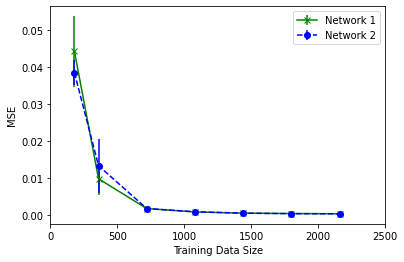

In [12]:
plt.errorbar(adjusted_data_sizes, TL_model_results_N1, yerr=standard_devs1, label='Network 1', marker='x', color=colors['green'])
plt.errorbar(adjusted_data_sizes, TL_model_results_N2, yerr=standard_devs2, label='Network 2', marker='o', color=colors['blue'], linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Training Data Size')
plt.xlim([0,2500])
plt.legend()
plt.savefig(f'{data_path}/Figures/Transfer_Learning/transfer_learning_EDFA_results_cross_validation.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

# Data generation timings for GGN-model

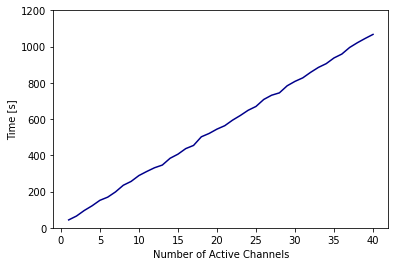

In [13]:
# Timings pasted from terminal
timings = [37.53791856765747, 44.47045350074768, 63.32831048965454, 63.37506365776062, 92.2624683380127, 101.36327958106995, 127.2022910118103, 128.8183991909027, 146.18886709213257, 154.03905510902405, 169.45223116874695, 180.0242350101471, 202.27941131591797, 186.95078349113464, 231.9132387638092, 235.80909180641174, 238.02216506004333, 262.52415585517883, 295.4653024673462, 282.79807806015015, 314.0984613895416, 300.1329183578491, 318.3239064216614, 342.6468069553375, 341.85795998573303, 338.9036498069763, 396.2428140640259, 380.6560711860657, 409.18574833869934, 410.63210701942444, 428.5700755119324, 446.07497000694275, 464.18149399757385, 476.0715534687042, 509.7240798473358, 502.15772557258606, 526.4843437671661, 531.1146490573883, 546.1816582679749, 530.184743642807, 564.6300182342529, 543.1818542480469, 604.5711410045624, 597.9672174453735, 636.0374624729156, 606.8063626289368, 656.8883156776428, 630.4283859729767, 693.5758180618286, 684.148622751236, 699.0965142250061, 698.5889072418213, 733.7673182487488, 728.1497437953949, 747.5423681735992, 732.1805770397186, 795.8408675193787, 784.3137204647064, 823.3255343437195, 806.6421318054199, 812.1924839019775, 831.0661885738373, 853.6679453849792, 874.6142926216125, 880.324205160141, 883.985169172287, 902.1533312797546, 906.7828867435455, 939.4710423946381, 958.7142722606659, 958.7406995296478, 965.4762909412384, 988.1618983745575, 1001.0708174705505, 1020.485728263855, 1013.999463558197, 1056.151177406311, 1037.401254415512, 1064.9133727550507, 1061.2183439731598]
timings2 = [45.44373607635498, 46.39151430130005, 71.88638520240784, 60.848305463790894, 90.2727882862091, 98.38968420028687, 126.34571504592896, 103.31419968605042, 153.83978462219238, 152.44257521629333, 171.29617476463318, 155.64072728157043, 201.69269347190857, 201.33199286460876, 235.09215092658997, 236.43923497200012, 259.33132672309875, 263.961457490921, 282.86732482910156, 292.2573585510254, 306.2440962791443, 322.33714842796326, 323.8816931247711, 340.61911964416504, 335.95193123817444, 368.26044058799744, 364.89508628845215, 393.548157453537, 390.94132566452026, 414.20369696617126, 433.55249428749084, 439.87579250335693, 435.1022753715515, 442.87834310531616, 496.4673607349396, 500.65900468826294, 507.62135100364685, 517.7434628009796, 543.3064279556274, 558.5317633152008, 574.6485662460327, 571.3963468074799, 594.0323643684387, 579.8316121101379, 613.002302646637, 624.0610625743866, 670.3513743877411, 636.9688713550568, 654.8742032051086, 646.1440205574036, 703.7103109359741, 732.020813703537, 725.0013020038605, 739.5422172546387, 752.2881071567535, 746.7799875736237, 771.2034537792206, 783.8148059844971, 791.6866688728333, 810.8507723808289, 839.7172744274139, 827.2433030605316, 852.0638256072998, 851.3664450645447, 890.7072277069092, 885.4374439716339, 918.0034379959106, 896.654248714447, 918.100900888443, 933.5194518566132, 946.6818528175354, 964.0156850814819, 992.3744978904724, 999.0277001857758, 1031.5241856575012, 1020.2360715866089, 1044.5985527038574, 1042.588624715805, 1061.7617621421814, 1081.3993773460388]
timings_ave = []
for i in range(0,79,2):
    av = (timings[i] + timings[i+1] + timings2[i] + timings2[i+1])/4
    timings_ave.append(av)
active_channel_number = [i for i in range(1, 41)]
plt.plot(active_channel_number, timings_ave, color=colors['darkblue'])
plt.ylim([0, 1200])
plt.ylabel('Time [s]')
plt.xlabel('Number of Active Channels')
plt.savefig(f'{data_path}/Figures/raman_data_generation_timings.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

# Create Raman amplified network data files

In [14]:
def createLabels(channel_no):
    labels = ['launch_power_dbm']
    for i in range(1, channel_no+1):
        labels.append('Status_Ch' + str(i))
    for i in range(1, channel_no+1):
        labels.append('snr_Ch' + str(i))
    return labels
def instantiateWriteFile(file_path):
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(labels)
def add_row_of_data(file_path, list_of_elem):
    with open(file_path, 'a+', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(list_of_elem)

In [15]:
labels = createLabels(40)

In [16]:
instantiateWriteFile(f'{data_path}/Data/TL_Data_Raman/Raman_data_All.csv')
for i in range(1, 10):
    file_path = f'{data_path}/Data/TL_Data_Raman/Raman_data{i}.csv'
    df = pd.read_csv(file_path)
    dataset = df.values
#     print(dataset.shape)
    for j in dataset:
        add_row_of_data(f'{data_path}/Data/TL_Data_Raman/Raman_data_All.csv', j)

In [17]:
instantiateWriteFile(f'{data_path}/Data/TL_Data_Raman_GN/Raman_GN_data_All.csv')
for i in range(1, 5):
    file_path = f'{data_path}/Data/TL_Data_Raman_GN/Raman_GN_data{i}.csv'
    df = pd.read_csv(file_path)
    dataset = df.values
    print(dataset.shape)
    for j in dataset:
        add_row_of_data(f'{data_path}/Data/TL_Data_Raman_GN/Raman_GN_data_All.csv', j)

(800, 81)
(800, 81)
(400, 81)
(800, 81)


In [18]:
file_path = f'{data_path}/Data/TL_Data_Raman_GN/Raman_GN_data_All.csv'
df = pd.read_csv(file_path)
dataset = df.values
dataset.shape

(2800, 81)

# Raman amplified networks transfer learning

In [19]:
def TL_network_test_Raman(file_path, test_data_numbers):
    X_scale, Y_scale = processing_data(N_channels, file_path)
    TL_Raman_model_results = []
    standard_devs_Raman = []
    for i in test_data_numbers:
        results = []
        X_data = X_scale[:i]
        Y_data = Y_scale[:i]
        for j in range(10):
            model = load_TL_model('Tuned_ANN_model.h5')
            X_train = np.concatenate((X_data[:int(j*i/10)],X_data[int((j+1)*i/10):]))
            Y_train = np.concatenate((Y_data[:int(j*i/10)],Y_data[int((j+1)*i/10):]))
            X_test = X_data[int(j*i/10):int((j+1)*i/10)]
            Y_test = Y_data[int(j*i/10):int((j+1)*i/10)]
            history = model.fit(X_train, Y_train, epochs=150, verbose=2)
            result = model.evaluate(X_test, Y_test, verbose=0)[1]
            results.append(result)
        TL_Raman_model_results.append(np.mean(results))
        standard_devs_Raman.append(np.std(results))
    return TL_Raman_model_results, standard_devs_Raman

In [20]:
# test_data_numbers_GN = [200]
# file_path = (f'{data_path}/Data/TL_Data_Raman/Raman_GN_data_All.csv')
# TL_Raman_model_results_asd, standard_devs_Raman_asd = TL_network_test_Raman(file_path, test_data_numbers_GN)

In [21]:
test_data_numbers_GN = [200, 400, 800, 1200, 1600, 2000, 2400]
adjusted_test_data_numbers_GN = [(i-0.1*i) for i in test_data_numbers_GN]
file_path = (f'{data_path}/Data/TL_Data_Raman/Raman_GN_data_All.csv')
TL_Raman_model_results_GN, standard_devs_Raman_GN = TL_network_test_Raman(file_path, test_data_numbers_GN)

Epoch 1/150
6/6 - 0s - loss: 0.3717 - mean_squared_error: 0.3711
Epoch 2/150
6/6 - 0s - loss: 0.3426 - mean_squared_error: 0.3421
Epoch 3/150
6/6 - 0s - loss: 0.3234 - mean_squared_error: 0.3228
Epoch 4/150
6/6 - 0s - loss: 0.3101 - mean_squared_error: 0.3095
Epoch 5/150
6/6 - 0s - loss: 0.2978 - mean_squared_error: 0.2972
Epoch 6/150
6/6 - 0s - loss: 0.2877 - mean_squared_error: 0.2871
Epoch 7/150
6/6 - 0s - loss: 0.2818 - mean_squared_error: 0.2812
Epoch 8/150
6/6 - 0s - loss: 0.2740 - mean_squared_error: 0.2734
Epoch 9/150
6/6 - 0s - loss: 0.2665 - mean_squared_error: 0.2659
Epoch 10/150
6/6 - 0s - loss: 0.2535 - mean_squared_error: 0.2530
Epoch 11/150
6/6 - 0s - loss: 0.2490 - mean_squared_error: 0.2484
Epoch 12/150
6/6 - 0s - loss: 0.2423 - mean_squared_error: 0.2417
Epoch 13/150
6/6 - 0s - loss: 0.2381 - mean_squared_error: 0.2376
Epoch 14/150
6/6 - 0s - loss: 0.2339 - mean_squared_error: 0.2333
Epoch 15/150
6/6 - 0s - loss: 0.2270 - mean_squared_error: 0.2264
Epoch 16/150
6/6 - 

Epoch 125/150
6/6 - 0s - loss: 0.0441 - mean_squared_error: 0.0435
Epoch 126/150
6/6 - 0s - loss: 0.0427 - mean_squared_error: 0.0422
Epoch 127/150
6/6 - 0s - loss: 0.0421 - mean_squared_error: 0.0415
Epoch 128/150
6/6 - 0s - loss: 0.0417 - mean_squared_error: 0.0411
Epoch 129/150
6/6 - 0s - loss: 0.0410 - mean_squared_error: 0.0404
Epoch 130/150
6/6 - 0s - loss: 0.0405 - mean_squared_error: 0.0399
Epoch 131/150
6/6 - 0s - loss: 0.0401 - mean_squared_error: 0.0395
Epoch 132/150
6/6 - 0s - loss: 0.0395 - mean_squared_error: 0.0389
Epoch 133/150
6/6 - 0s - loss: 0.0386 - mean_squared_error: 0.0380
Epoch 134/150
6/6 - 0s - loss: 0.0385 - mean_squared_error: 0.0379
Epoch 135/150
6/6 - 0s - loss: 0.0379 - mean_squared_error: 0.0373
Epoch 136/150
6/6 - 0s - loss: 0.0373 - mean_squared_error: 0.0367
Epoch 137/150
6/6 - 0s - loss: 0.0370 - mean_squared_error: 0.0364
Epoch 138/150
6/6 - 0s - loss: 0.0370 - mean_squared_error: 0.0364
Epoch 139/150
6/6 - 0s - loss: 0.0364 - mean_squared_error: 0.

Epoch 99/150
6/6 - 0s - loss: 0.0699 - mean_squared_error: 0.0694
Epoch 100/150
6/6 - 0s - loss: 0.0695 - mean_squared_error: 0.0689
Epoch 101/150
6/6 - 0s - loss: 0.0686 - mean_squared_error: 0.0680
Epoch 102/150
6/6 - 0s - loss: 0.0682 - mean_squared_error: 0.0676
Epoch 103/150
6/6 - 0s - loss: 0.0671 - mean_squared_error: 0.0665
Epoch 104/150
6/6 - 0s - loss: 0.0663 - mean_squared_error: 0.0657
Epoch 105/150
6/6 - 0s - loss: 0.0661 - mean_squared_error: 0.0655
Epoch 106/150
6/6 - 0s - loss: 0.0653 - mean_squared_error: 0.0647
Epoch 107/150
6/6 - 0s - loss: 0.0647 - mean_squared_error: 0.0641
Epoch 108/150
6/6 - 0s - loss: 0.0640 - mean_squared_error: 0.0635
Epoch 109/150
6/6 - 0s - loss: 0.0637 - mean_squared_error: 0.0631
Epoch 110/150
6/6 - 0s - loss: 0.0628 - mean_squared_error: 0.0622
Epoch 111/150
6/6 - 0s - loss: 0.0622 - mean_squared_error: 0.0616
Epoch 112/150
6/6 - 0s - loss: 0.0618 - mean_squared_error: 0.0612
Epoch 113/150
6/6 - 0s - loss: 0.0615 - mean_squared_error: 0.0

Epoch 73/150
6/6 - 0s - loss: 0.1100 - mean_squared_error: 0.1094
Epoch 74/150
6/6 - 0s - loss: 0.1090 - mean_squared_error: 0.1084
Epoch 75/150
6/6 - 0s - loss: 0.1081 - mean_squared_error: 0.1075
Epoch 76/150
6/6 - 0s - loss: 0.1063 - mean_squared_error: 0.1057
Epoch 77/150
6/6 - 0s - loss: 0.1056 - mean_squared_error: 0.1050
Epoch 78/150
6/6 - 0s - loss: 0.1048 - mean_squared_error: 0.1043
Epoch 79/150
6/6 - 0s - loss: 0.1037 - mean_squared_error: 0.1031
Epoch 80/150
6/6 - 0s - loss: 0.1026 - mean_squared_error: 0.1021
Epoch 81/150
6/6 - 0s - loss: 0.1018 - mean_squared_error: 0.1013
Epoch 82/150
6/6 - 0s - loss: 0.1009 - mean_squared_error: 0.1004
Epoch 83/150
6/6 - 0s - loss: 0.0998 - mean_squared_error: 0.0992
Epoch 84/150
6/6 - 0s - loss: 0.0989 - mean_squared_error: 0.0984
Epoch 85/150
6/6 - 0s - loss: 0.0982 - mean_squared_error: 0.0976
Epoch 86/150
6/6 - 0s - loss: 0.0972 - mean_squared_error: 0.0966
Epoch 87/150
6/6 - 0s - loss: 0.0966 - mean_squared_error: 0.0960
Epoch 88/1

Epoch 47/150
6/6 - 0s - loss: 0.1182 - mean_squared_error: 0.1176
Epoch 48/150
6/6 - 0s - loss: 0.1169 - mean_squared_error: 0.1163
Epoch 49/150
6/6 - 0s - loss: 0.1145 - mean_squared_error: 0.1139
Epoch 50/150
6/6 - 0s - loss: 0.1128 - mean_squared_error: 0.1122
Epoch 51/150
6/6 - 0s - loss: 0.1110 - mean_squared_error: 0.1105
Epoch 52/150
6/6 - 0s - loss: 0.1096 - mean_squared_error: 0.1090
Epoch 53/150
6/6 - 0s - loss: 0.1078 - mean_squared_error: 0.1072
Epoch 54/150
6/6 - 0s - loss: 0.1063 - mean_squared_error: 0.1057
Epoch 55/150
6/6 - 0s - loss: 0.1044 - mean_squared_error: 0.1039
Epoch 56/150
6/6 - 0s - loss: 0.1028 - mean_squared_error: 0.1023
Epoch 57/150
6/6 - 0s - loss: 0.1011 - mean_squared_error: 0.1005
Epoch 58/150
6/6 - 0s - loss: 0.0998 - mean_squared_error: 0.0992
Epoch 59/150
6/6 - 0s - loss: 0.0980 - mean_squared_error: 0.0974
Epoch 60/150
6/6 - 0s - loss: 0.0967 - mean_squared_error: 0.0962
Epoch 61/150
6/6 - 0s - loss: 0.0953 - mean_squared_error: 0.0947
Epoch 62/1

Epoch 10/150
6/6 - 0s - loss: 0.2453 - mean_squared_error: 0.2447
Epoch 11/150
6/6 - 0s - loss: 0.2373 - mean_squared_error: 0.2367
Epoch 12/150
6/6 - 0s - loss: 0.2261 - mean_squared_error: 0.2255
Epoch 13/150
6/6 - 0s - loss: 0.2185 - mean_squared_error: 0.2179
Epoch 14/150
6/6 - 0s - loss: 0.2117 - mean_squared_error: 0.2111
Epoch 15/150
6/6 - 0s - loss: 0.2075 - mean_squared_error: 0.2069
Epoch 16/150
6/6 - 0s - loss: 0.2024 - mean_squared_error: 0.2019
Epoch 17/150
6/6 - 0s - loss: 0.1991 - mean_squared_error: 0.1985
Epoch 18/150
6/6 - 0s - loss: 0.1952 - mean_squared_error: 0.1947
Epoch 19/150
6/6 - 0s - loss: 0.1927 - mean_squared_error: 0.1922
Epoch 20/150
6/6 - 0s - loss: 0.1897 - mean_squared_error: 0.1891
Epoch 21/150
6/6 - 0s - loss: 0.1869 - mean_squared_error: 0.1863
Epoch 22/150
6/6 - 0s - loss: 0.1846 - mean_squared_error: 0.1840
Epoch 23/150
6/6 - 0s - loss: 0.1818 - mean_squared_error: 0.1812
Epoch 24/150
6/6 - 0s - loss: 0.1796 - mean_squared_error: 0.1790
Epoch 25/1

Epoch 134/150
6/6 - 0s - loss: 0.0428 - mean_squared_error: 0.0422
Epoch 135/150
6/6 - 0s - loss: 0.0424 - mean_squared_error: 0.0418
Epoch 136/150
6/6 - 0s - loss: 0.0423 - mean_squared_error: 0.0417
Epoch 137/150
6/6 - 0s - loss: 0.0418 - mean_squared_error: 0.0412
Epoch 138/150
6/6 - 0s - loss: 0.0416 - mean_squared_error: 0.0410
Epoch 139/150
6/6 - 0s - loss: 0.0413 - mean_squared_error: 0.0407
Epoch 140/150
6/6 - 0s - loss: 0.0409 - mean_squared_error: 0.0403
Epoch 141/150
6/6 - 0s - loss: 0.0406 - mean_squared_error: 0.0400
Epoch 142/150
6/6 - 0s - loss: 0.0404 - mean_squared_error: 0.0398
Epoch 143/150
6/6 - 0s - loss: 0.0403 - mean_squared_error: 0.0397
Epoch 144/150
6/6 - 0s - loss: 0.0400 - mean_squared_error: 0.0394
Epoch 145/150
6/6 - 0s - loss: 0.0397 - mean_squared_error: 0.0391
Epoch 146/150
6/6 - 0s - loss: 0.0395 - mean_squared_error: 0.0389
Epoch 147/150
6/6 - 0s - loss: 0.0391 - mean_squared_error: 0.0386
Epoch 148/150
6/6 - 0s - loss: 0.0391 - mean_squared_error: 0.

Epoch 97/150
6/6 - 0s - loss: 0.0375 - mean_squared_error: 0.0369
Epoch 98/150
6/6 - 0s - loss: 0.0367 - mean_squared_error: 0.0362
Epoch 99/150
6/6 - 0s - loss: 0.0360 - mean_squared_error: 0.0354
Epoch 100/150
6/6 - 0s - loss: 0.0357 - mean_squared_error: 0.0351
Epoch 101/150
6/6 - 0s - loss: 0.0347 - mean_squared_error: 0.0342
Epoch 102/150
6/6 - 0s - loss: 0.0347 - mean_squared_error: 0.0341
Epoch 103/150
6/6 - 0s - loss: 0.0338 - mean_squared_error: 0.0333
Epoch 104/150
6/6 - 0s - loss: 0.0334 - mean_squared_error: 0.0328
Epoch 105/150
6/6 - 0s - loss: 0.0331 - mean_squared_error: 0.0325
Epoch 106/150
6/6 - 0s - loss: 0.0324 - mean_squared_error: 0.0318
Epoch 107/150
6/6 - 0s - loss: 0.0318 - mean_squared_error: 0.0313
Epoch 108/150
6/6 - 0s - loss: 0.0314 - mean_squared_error: 0.0308
Epoch 109/150
6/6 - 0s - loss: 0.0307 - mean_squared_error: 0.0302
Epoch 110/150
6/6 - 0s - loss: 0.0305 - mean_squared_error: 0.0299
Epoch 111/150
6/6 - 0s - loss: 0.0301 - mean_squared_error: 0.029

Epoch 60/150
6/6 - 0s - loss: 0.1149 - mean_squared_error: 0.1143
Epoch 61/150
6/6 - 0s - loss: 0.1135 - mean_squared_error: 0.1129
Epoch 62/150
6/6 - 0s - loss: 0.1121 - mean_squared_error: 0.1115
Epoch 63/150
6/6 - 0s - loss: 0.1108 - mean_squared_error: 0.1102
Epoch 64/150
6/6 - 0s - loss: 0.1094 - mean_squared_error: 0.1088
Epoch 65/150
6/6 - 0s - loss: 0.1081 - mean_squared_error: 0.1076
Epoch 66/150
6/6 - 0s - loss: 0.1068 - mean_squared_error: 0.1062
Epoch 67/150
6/6 - 0s - loss: 0.1055 - mean_squared_error: 0.1049
Epoch 68/150
6/6 - 0s - loss: 0.1042 - mean_squared_error: 0.1036
Epoch 69/150
6/6 - 0s - loss: 0.1032 - mean_squared_error: 0.1026
Epoch 70/150
6/6 - 0s - loss: 0.1022 - mean_squared_error: 0.1016
Epoch 71/150
6/6 - 0s - loss: 0.1009 - mean_squared_error: 0.1003
Epoch 72/150
6/6 - 0s - loss: 0.0993 - mean_squared_error: 0.0987
Epoch 73/150
6/6 - 0s - loss: 0.0986 - mean_squared_error: 0.0980
Epoch 74/150
6/6 - 0s - loss: 0.0976 - mean_squared_error: 0.0971
Epoch 75/1

Epoch 23/150
6/6 - 0s - loss: 0.1798 - mean_squared_error: 0.1792
Epoch 24/150
6/6 - 0s - loss: 0.1763 - mean_squared_error: 0.1758
Epoch 25/150
6/6 - 0s - loss: 0.1724 - mean_squared_error: 0.1718
Epoch 26/150
6/6 - 0s - loss: 0.1697 - mean_squared_error: 0.1691
Epoch 27/150
6/6 - 0s - loss: 0.1665 - mean_squared_error: 0.1659
Epoch 28/150
6/6 - 0s - loss: 0.1641 - mean_squared_error: 0.1635
Epoch 29/150
6/6 - 0s - loss: 0.1611 - mean_squared_error: 0.1605
Epoch 30/150
6/6 - 0s - loss: 0.1590 - mean_squared_error: 0.1584
Epoch 31/150
6/6 - 0s - loss: 0.1565 - mean_squared_error: 0.1560
Epoch 32/150
6/6 - 0s - loss: 0.1539 - mean_squared_error: 0.1533
Epoch 33/150
6/6 - 0s - loss: 0.1521 - mean_squared_error: 0.1516
Epoch 34/150
6/6 - 0s - loss: 0.1499 - mean_squared_error: 0.1493
Epoch 35/150
6/6 - 0s - loss: 0.1477 - mean_squared_error: 0.1471
Epoch 36/150
6/6 - 0s - loss: 0.1459 - mean_squared_error: 0.1453
Epoch 37/150
6/6 - 0s - loss: 0.1437 - mean_squared_error: 0.1432
Epoch 38/1

Epoch 147/150
6/6 - 0s - loss: 0.0406 - mean_squared_error: 0.0400
Epoch 148/150
6/6 - 0s - loss: 0.0403 - mean_squared_error: 0.0397
Epoch 149/150
6/6 - 0s - loss: 0.0401 - mean_squared_error: 0.0395
Epoch 150/150
6/6 - 0s - loss: 0.0398 - mean_squared_error: 0.0392
Epoch 1/150
6/6 - 0s - loss: 0.3631 - mean_squared_error: 0.3626
Epoch 2/150
6/6 - 0s - loss: 0.3257 - mean_squared_error: 0.3252
Epoch 3/150
6/6 - 0s - loss: 0.3011 - mean_squared_error: 0.3006
Epoch 4/150
6/6 - 0s - loss: 0.2842 - mean_squared_error: 0.2836
Epoch 5/150
6/6 - 0s - loss: 0.2745 - mean_squared_error: 0.2739
Epoch 6/150
6/6 - 0s - loss: 0.2648 - mean_squared_error: 0.2642
Epoch 7/150
6/6 - 0s - loss: 0.2531 - mean_squared_error: 0.2526
Epoch 8/150
6/6 - 0s - loss: 0.2380 - mean_squared_error: 0.2375
Epoch 9/150
6/6 - 0s - loss: 0.2326 - mean_squared_error: 0.2320
Epoch 10/150
6/6 - 0s - loss: 0.2259 - mean_squared_error: 0.2253
Epoch 11/150
6/6 - 0s - loss: 0.2204 - mean_squared_error: 0.2198
Epoch 12/150
6/

Epoch 110/150
6/6 - 0s - loss: 0.0718 - mean_squared_error: 0.0712
Epoch 111/150
6/6 - 0s - loss: 0.0712 - mean_squared_error: 0.0707
Epoch 112/150
6/6 - 0s - loss: 0.0707 - mean_squared_error: 0.0701
Epoch 113/150
6/6 - 0s - loss: 0.0703 - mean_squared_error: 0.0697
Epoch 114/150
6/6 - 0s - loss: 0.0699 - mean_squared_error: 0.0693
Epoch 115/150
6/6 - 0s - loss: 0.0695 - mean_squared_error: 0.0689
Epoch 116/150
6/6 - 0s - loss: 0.0691 - mean_squared_error: 0.0685
Epoch 117/150
6/6 - 0s - loss: 0.0685 - mean_squared_error: 0.0679
Epoch 118/150
6/6 - 0s - loss: 0.0684 - mean_squared_error: 0.0678
Epoch 119/150
6/6 - 0s - loss: 0.0679 - mean_squared_error: 0.0673
Epoch 120/150
6/6 - 0s - loss: 0.0675 - mean_squared_error: 0.0670
Epoch 121/150
6/6 - 0s - loss: 0.0673 - mean_squared_error: 0.0667
Epoch 122/150
6/6 - 0s - loss: 0.0668 - mean_squared_error: 0.0662
Epoch 123/150
6/6 - 0s - loss: 0.0663 - mean_squared_error: 0.0657
Epoch 124/150
6/6 - 0s - loss: 0.0662 - mean_squared_error: 0.

Epoch 73/150
6/6 - 0s - loss: 0.0799 - mean_squared_error: 0.0793
Epoch 74/150
6/6 - 0s - loss: 0.0786 - mean_squared_error: 0.0780
Epoch 75/150
6/6 - 0s - loss: 0.0778 - mean_squared_error: 0.0772
Epoch 76/150
6/6 - 0s - loss: 0.0769 - mean_squared_error: 0.0763
Epoch 77/150
6/6 - 0s - loss: 0.0758 - mean_squared_error: 0.0752
Epoch 78/150
6/6 - 0s - loss: 0.0751 - mean_squared_error: 0.0745
Epoch 79/150
6/6 - 0s - loss: 0.0736 - mean_squared_error: 0.0730
Epoch 80/150
6/6 - 0s - loss: 0.0730 - mean_squared_error: 0.0724
Epoch 81/150
6/6 - 0s - loss: 0.0721 - mean_squared_error: 0.0715
Epoch 82/150
6/6 - 0s - loss: 0.0714 - mean_squared_error: 0.0708
Epoch 83/150
6/6 - 0s - loss: 0.0700 - mean_squared_error: 0.0694
Epoch 84/150
6/6 - 0s - loss: 0.0691 - mean_squared_error: 0.0685
Epoch 85/150
6/6 - 0s - loss: 0.0683 - mean_squared_error: 0.0678
Epoch 86/150
6/6 - 0s - loss: 0.0675 - mean_squared_error: 0.0669
Epoch 87/150
6/6 - 0s - loss: 0.0664 - mean_squared_error: 0.0658
Epoch 88/1

12/12 - 0s - loss: 0.1332 - mean_squared_error: 0.1326
Epoch 35/150
12/12 - 0s - loss: 0.1321 - mean_squared_error: 0.1316
Epoch 36/150
12/12 - 0s - loss: 0.1283 - mean_squared_error: 0.1277
Epoch 37/150
12/12 - 0s - loss: 0.1255 - mean_squared_error: 0.1249
Epoch 38/150
12/12 - 0s - loss: 0.1238 - mean_squared_error: 0.1232
Epoch 39/150
12/12 - 0s - loss: 0.1218 - mean_squared_error: 0.1212
Epoch 40/150
12/12 - 0s - loss: 0.1195 - mean_squared_error: 0.1189
Epoch 41/150
12/12 - 0s - loss: 0.1170 - mean_squared_error: 0.1165
Epoch 42/150
12/12 - 0s - loss: 0.1158 - mean_squared_error: 0.1152
Epoch 43/150
12/12 - 0s - loss: 0.1145 - mean_squared_error: 0.1139
Epoch 44/150
12/12 - 0s - loss: 0.1112 - mean_squared_error: 0.1106
Epoch 45/150
12/12 - 0s - loss: 0.1102 - mean_squared_error: 0.1096
Epoch 46/150
12/12 - 0s - loss: 0.1078 - mean_squared_error: 0.1073
Epoch 47/150
12/12 - 0s - loss: 0.1064 - mean_squared_error: 0.1058
Epoch 48/150
12/12 - 0s - loss: 0.1045 - mean_squared_error: 

Epoch 1/150
12/12 - 0s - loss: 0.3364 - mean_squared_error: 0.3359
Epoch 2/150
12/12 - 0s - loss: 0.2870 - mean_squared_error: 0.2865
Epoch 3/150
12/12 - 0s - loss: 0.2626 - mean_squared_error: 0.2620
Epoch 4/150
12/12 - 0s - loss: 0.2436 - mean_squared_error: 0.2430
Epoch 5/150
12/12 - 0s - loss: 0.2278 - mean_squared_error: 0.2272
Epoch 6/150
12/12 - 0s - loss: 0.2104 - mean_squared_error: 0.2098
Epoch 7/150
12/12 - 0s - loss: 0.2008 - mean_squared_error: 0.2002
Epoch 8/150
12/12 - 0s - loss: 0.1927 - mean_squared_error: 0.1921
Epoch 9/150
12/12 - 0s - loss: 0.1849 - mean_squared_error: 0.1844
Epoch 10/150
12/12 - 0s - loss: 0.1776 - mean_squared_error: 0.1770
Epoch 11/150
12/12 - 0s - loss: 0.1720 - mean_squared_error: 0.1714
Epoch 12/150
12/12 - 0s - loss: 0.1667 - mean_squared_error: 0.1661
Epoch 13/150
12/12 - 0s - loss: 0.1622 - mean_squared_error: 0.1616
Epoch 14/150
12/12 - 0s - loss: 0.1578 - mean_squared_error: 0.1572
Epoch 15/150
12/12 - 0s - loss: 0.1527 - mean_squared_err

Epoch 122/150
12/12 - 0s - loss: 0.0103 - mean_squared_error: 0.0097
Epoch 123/150
12/12 - 0s - loss: 0.0101 - mean_squared_error: 0.0095
Epoch 124/150
12/12 - 0s - loss: 0.0100 - mean_squared_error: 0.0094
Epoch 125/150
12/12 - 0s - loss: 0.0098 - mean_squared_error: 0.0092
Epoch 126/150
12/12 - 0s - loss: 0.0097 - mean_squared_error: 0.0091
Epoch 127/150
12/12 - 0s - loss: 0.0096 - mean_squared_error: 0.0090
Epoch 128/150
12/12 - 0s - loss: 0.0095 - mean_squared_error: 0.0089
Epoch 129/150
12/12 - 0s - loss: 0.0095 - mean_squared_error: 0.0089
Epoch 130/150
12/12 - 0s - loss: 0.0092 - mean_squared_error: 0.0086
Epoch 131/150
12/12 - 0s - loss: 0.0091 - mean_squared_error: 0.0085
Epoch 132/150
12/12 - 0s - loss: 0.0091 - mean_squared_error: 0.0085
Epoch 133/150
12/12 - 0s - loss: 0.0091 - mean_squared_error: 0.0085
Epoch 134/150
12/12 - 0s - loss: 0.0089 - mean_squared_error: 0.0083
Epoch 135/150
12/12 - 0s - loss: 0.0087 - mean_squared_error: 0.0081
Epoch 136/150
12/12 - 0s - loss: 0

12/12 - 0s - loss: 0.0388 - mean_squared_error: 0.0382
Epoch 82/150
12/12 - 0s - loss: 0.0382 - mean_squared_error: 0.0376
Epoch 83/150
12/12 - 0s - loss: 0.0374 - mean_squared_error: 0.0368
Epoch 84/150
12/12 - 0s - loss: 0.0370 - mean_squared_error: 0.0364
Epoch 85/150
12/12 - 0s - loss: 0.0367 - mean_squared_error: 0.0361
Epoch 86/150
12/12 - 0s - loss: 0.0363 - mean_squared_error: 0.0357
Epoch 87/150
12/12 - 0s - loss: 0.0358 - mean_squared_error: 0.0352
Epoch 88/150
12/12 - 0s - loss: 0.0352 - mean_squared_error: 0.0347
Epoch 89/150
12/12 - 0s - loss: 0.0347 - mean_squared_error: 0.0341
Epoch 90/150
12/12 - 0s - loss: 0.0344 - mean_squared_error: 0.0338
Epoch 91/150
12/12 - 0s - loss: 0.0340 - mean_squared_error: 0.0334
Epoch 92/150
12/12 - 0s - loss: 0.0336 - mean_squared_error: 0.0330
Epoch 93/150
12/12 - 0s - loss: 0.0334 - mean_squared_error: 0.0328
Epoch 94/150
12/12 - 0s - loss: 0.0331 - mean_squared_error: 0.0325
Epoch 95/150
12/12 - 0s - loss: 0.0317 - mean_squared_error: 

Epoch 40/150
12/12 - 0s - loss: 0.0855 - mean_squared_error: 0.0849
Epoch 41/150
12/12 - 0s - loss: 0.0812 - mean_squared_error: 0.0807
Epoch 42/150
12/12 - 0s - loss: 0.0783 - mean_squared_error: 0.0777
Epoch 43/150
12/12 - 0s - loss: 0.0754 - mean_squared_error: 0.0748
Epoch 44/150
12/12 - 0s - loss: 0.0727 - mean_squared_error: 0.0721
Epoch 45/150
12/12 - 0s - loss: 0.0710 - mean_squared_error: 0.0704
Epoch 46/150
12/12 - 0s - loss: 0.0691 - mean_squared_error: 0.0685
Epoch 47/150
12/12 - 0s - loss: 0.0670 - mean_squared_error: 0.0664
Epoch 48/150
12/12 - 0s - loss: 0.0643 - mean_squared_error: 0.0638
Epoch 49/150
12/12 - 0s - loss: 0.0631 - mean_squared_error: 0.0625
Epoch 50/150
12/12 - 0s - loss: 0.0614 - mean_squared_error: 0.0608
Epoch 51/150
12/12 - 0s - loss: 0.0600 - mean_squared_error: 0.0595
Epoch 52/150
12/12 - 0s - loss: 0.0589 - mean_squared_error: 0.0583
Epoch 53/150
12/12 - 0s - loss: 0.0566 - mean_squared_error: 0.0561
Epoch 54/150
12/12 - 0s - loss: 0.0548 - mean_sq

Epoch 1/150
12/12 - 0s - loss: 0.3406 - mean_squared_error: 0.3400
Epoch 2/150
12/12 - 0s - loss: 0.2821 - mean_squared_error: 0.2816
Epoch 3/150
12/12 - 0s - loss: 0.2582 - mean_squared_error: 0.2576
Epoch 4/150
12/12 - 0s - loss: 0.2391 - mean_squared_error: 0.2385
Epoch 5/150
12/12 - 0s - loss: 0.2280 - mean_squared_error: 0.2274
Epoch 6/150
12/12 - 0s - loss: 0.2179 - mean_squared_error: 0.2174
Epoch 7/150
12/12 - 0s - loss: 0.2095 - mean_squared_error: 0.2089
Epoch 8/150
12/12 - 0s - loss: 0.2027 - mean_squared_error: 0.2021
Epoch 9/150
12/12 - 0s - loss: 0.1960 - mean_squared_error: 0.1954
Epoch 10/150
12/12 - 0s - loss: 0.1906 - mean_squared_error: 0.1900
Epoch 11/150
12/12 - 0s - loss: 0.1834 - mean_squared_error: 0.1828
Epoch 12/150
12/12 - 0s - loss: 0.1763 - mean_squared_error: 0.1758
Epoch 13/150
12/12 - 0s - loss: 0.1703 - mean_squared_error: 0.1698
Epoch 14/150
12/12 - 0s - loss: 0.1652 - mean_squared_error: 0.1646
Epoch 15/150
12/12 - 0s - loss: 0.1607 - mean_squared_err

Epoch 122/150
12/12 - 0s - loss: 0.0111 - mean_squared_error: 0.0105
Epoch 123/150
12/12 - 0s - loss: 0.0110 - mean_squared_error: 0.0104
Epoch 124/150
12/12 - 0s - loss: 0.0108 - mean_squared_error: 0.0102
Epoch 125/150
12/12 - 0s - loss: 0.0108 - mean_squared_error: 0.0102
Epoch 126/150
12/12 - 0s - loss: 0.0106 - mean_squared_error: 0.0100
Epoch 127/150
12/12 - 0s - loss: 0.0105 - mean_squared_error: 0.0099
Epoch 128/150
12/12 - 0s - loss: 0.0102 - mean_squared_error: 0.0096
Epoch 129/150
12/12 - 0s - loss: 0.0101 - mean_squared_error: 0.0094
Epoch 130/150
12/12 - 0s - loss: 0.0099 - mean_squared_error: 0.0093
Epoch 131/150
12/12 - 0s - loss: 0.0099 - mean_squared_error: 0.0093
Epoch 132/150
12/12 - 0s - loss: 0.0097 - mean_squared_error: 0.0091
Epoch 133/150
12/12 - 0s - loss: 0.0096 - mean_squared_error: 0.0090
Epoch 134/150
12/12 - 0s - loss: 0.0095 - mean_squared_error: 0.0089
Epoch 135/150
12/12 - 0s - loss: 0.0094 - mean_squared_error: 0.0088
Epoch 136/150
12/12 - 0s - loss: 0

12/12 - 0s - loss: 0.0316 - mean_squared_error: 0.0310
Epoch 82/150
12/12 - 0s - loss: 0.0308 - mean_squared_error: 0.0303
Epoch 83/150
12/12 - 0s - loss: 0.0307 - mean_squared_error: 0.0302
Epoch 84/150
12/12 - 0s - loss: 0.0299 - mean_squared_error: 0.0294
Epoch 85/150
12/12 - 0s - loss: 0.0295 - mean_squared_error: 0.0289
Epoch 86/150
12/12 - 0s - loss: 0.0292 - mean_squared_error: 0.0286
Epoch 87/150
12/12 - 0s - loss: 0.0287 - mean_squared_error: 0.0281
Epoch 88/150
12/12 - 0s - loss: 0.0281 - mean_squared_error: 0.0275
Epoch 89/150
12/12 - 0s - loss: 0.0279 - mean_squared_error: 0.0273
Epoch 90/150
12/12 - 0s - loss: 0.0273 - mean_squared_error: 0.0267
Epoch 91/150
12/12 - 0s - loss: 0.0268 - mean_squared_error: 0.0262
Epoch 92/150
12/12 - 0s - loss: 0.0267 - mean_squared_error: 0.0261
Epoch 93/150
12/12 - 0s - loss: 0.0264 - mean_squared_error: 0.0258
Epoch 94/150
12/12 - 0s - loss: 0.0258 - mean_squared_error: 0.0252
Epoch 95/150
12/12 - 0s - loss: 0.0255 - mean_squared_error: 

Epoch 40/150
12/12 - 0s - loss: 0.0773 - mean_squared_error: 0.0767
Epoch 41/150
12/12 - 0s - loss: 0.0754 - mean_squared_error: 0.0748
Epoch 42/150
12/12 - 0s - loss: 0.0727 - mean_squared_error: 0.0721
Epoch 43/150
12/12 - 0s - loss: 0.0718 - mean_squared_error: 0.0713
Epoch 44/150
12/12 - 0s - loss: 0.0682 - mean_squared_error: 0.0676
Epoch 45/150
12/12 - 0s - loss: 0.0664 - mean_squared_error: 0.0658
Epoch 46/150
12/12 - 0s - loss: 0.0645 - mean_squared_error: 0.0639
Epoch 47/150
12/12 - 0s - loss: 0.0618 - mean_squared_error: 0.0612
Epoch 48/150
12/12 - 0s - loss: 0.0600 - mean_squared_error: 0.0594
Epoch 49/150
12/12 - 0s - loss: 0.0585 - mean_squared_error: 0.0580
Epoch 50/150
12/12 - 0s - loss: 0.0568 - mean_squared_error: 0.0562
Epoch 51/150
12/12 - 0s - loss: 0.0555 - mean_squared_error: 0.0550
Epoch 52/150
12/12 - 0s - loss: 0.0540 - mean_squared_error: 0.0534
Epoch 53/150
12/12 - 0s - loss: 0.0515 - mean_squared_error: 0.0509
Epoch 54/150
12/12 - 0s - loss: 0.0504 - mean_sq

Epoch 1/150
12/12 - 0s - loss: 0.3546 - mean_squared_error: 0.3540
Epoch 2/150
12/12 - 0s - loss: 0.3006 - mean_squared_error: 0.3001
Epoch 3/150
12/12 - 0s - loss: 0.2834 - mean_squared_error: 0.2829
Epoch 4/150
12/12 - 0s - loss: 0.2720 - mean_squared_error: 0.2714
Epoch 5/150
12/12 - 0s - loss: 0.2625 - mean_squared_error: 0.2619
Epoch 6/150
12/12 - 0s - loss: 0.2547 - mean_squared_error: 0.2541
Epoch 7/150
12/12 - 0s - loss: 0.2447 - mean_squared_error: 0.2441
Epoch 8/150
12/12 - 0s - loss: 0.2334 - mean_squared_error: 0.2329
Epoch 9/150
12/12 - 0s - loss: 0.2248 - mean_squared_error: 0.2242
Epoch 10/150
12/12 - 0s - loss: 0.2164 - mean_squared_error: 0.2158
Epoch 11/150
12/12 - 0s - loss: 0.2114 - mean_squared_error: 0.2108
Epoch 12/150
12/12 - 0s - loss: 0.2022 - mean_squared_error: 0.2016
Epoch 13/150
12/12 - 0s - loss: 0.1976 - mean_squared_error: 0.1970
Epoch 14/150
12/12 - 0s - loss: 0.1911 - mean_squared_error: 0.1905
Epoch 15/150
12/12 - 0s - loss: 0.1869 - mean_squared_err

Epoch 122/150
12/12 - 0s - loss: 0.0208 - mean_squared_error: 0.0202
Epoch 123/150
12/12 - 0s - loss: 0.0205 - mean_squared_error: 0.0199
Epoch 124/150
12/12 - 0s - loss: 0.0171 - mean_squared_error: 0.0165
Epoch 125/150
12/12 - 0s - loss: 0.0133 - mean_squared_error: 0.0127
Epoch 126/150
12/12 - 0s - loss: 0.0120 - mean_squared_error: 0.0114
Epoch 127/150
12/12 - 0s - loss: 0.0114 - mean_squared_error: 0.0108
Epoch 128/150
12/12 - 0s - loss: 0.0110 - mean_squared_error: 0.0104
Epoch 129/150
12/12 - 0s - loss: 0.0108 - mean_squared_error: 0.0102
Epoch 130/150
12/12 - 0s - loss: 0.0108 - mean_squared_error: 0.0102
Epoch 131/150
12/12 - 0s - loss: 0.0104 - mean_squared_error: 0.0098
Epoch 132/150
12/12 - 0s - loss: 0.0101 - mean_squared_error: 0.0095
Epoch 133/150
12/12 - 0s - loss: 0.0098 - mean_squared_error: 0.0092
Epoch 134/150
12/12 - 0s - loss: 0.0097 - mean_squared_error: 0.0091
Epoch 135/150
12/12 - 0s - loss: 0.0097 - mean_squared_error: 0.0091
Epoch 136/150
12/12 - 0s - loss: 0

12/12 - 0s - loss: 0.0229 - mean_squared_error: 0.0223
Epoch 82/150
12/12 - 0s - loss: 0.0221 - mean_squared_error: 0.0215
Epoch 83/150
12/12 - 0s - loss: 0.0217 - mean_squared_error: 0.0211
Epoch 84/150
12/12 - 0s - loss: 0.0212 - mean_squared_error: 0.0206
Epoch 85/150
12/12 - 0s - loss: 0.0209 - mean_squared_error: 0.0203
Epoch 86/150
12/12 - 0s - loss: 0.0209 - mean_squared_error: 0.0203
Epoch 87/150
12/12 - 0s - loss: 0.0203 - mean_squared_error: 0.0197
Epoch 88/150
12/12 - 0s - loss: 0.0195 - mean_squared_error: 0.0189
Epoch 89/150
12/12 - 0s - loss: 0.0190 - mean_squared_error: 0.0184
Epoch 90/150
12/12 - 0s - loss: 0.0187 - mean_squared_error: 0.0181
Epoch 91/150
12/12 - 0s - loss: 0.0185 - mean_squared_error: 0.0179
Epoch 92/150
12/12 - 0s - loss: 0.0179 - mean_squared_error: 0.0173
Epoch 93/150
12/12 - 0s - loss: 0.0177 - mean_squared_error: 0.0171
Epoch 94/150
12/12 - 0s - loss: 0.0171 - mean_squared_error: 0.0165
Epoch 95/150
12/12 - 0s - loss: 0.0168 - mean_squared_error: 

Epoch 40/150
12/12 - 0s - loss: 0.0076 - mean_squared_error: 0.0070
Epoch 41/150
12/12 - 0s - loss: 0.0074 - mean_squared_error: 0.0068
Epoch 42/150
12/12 - 0s - loss: 0.0074 - mean_squared_error: 0.0068
Epoch 43/150
12/12 - 0s - loss: 0.0072 - mean_squared_error: 0.0067
Epoch 44/150
12/12 - 0s - loss: 0.0071 - mean_squared_error: 0.0065
Epoch 45/150
12/12 - 0s - loss: 0.0070 - mean_squared_error: 0.0064
Epoch 46/150
12/12 - 0s - loss: 0.0068 - mean_squared_error: 0.0063
Epoch 47/150
12/12 - 0s - loss: 0.0068 - mean_squared_error: 0.0062
Epoch 48/150
12/12 - 0s - loss: 0.0066 - mean_squared_error: 0.0060
Epoch 49/150
12/12 - 0s - loss: 0.0066 - mean_squared_error: 0.0060
Epoch 50/150
12/12 - 0s - loss: 0.0064 - mean_squared_error: 0.0059
Epoch 51/150
12/12 - 0s - loss: 0.0065 - mean_squared_error: 0.0059
Epoch 52/150
12/12 - 0s - loss: 0.0063 - mean_squared_error: 0.0057
Epoch 53/150
12/12 - 0s - loss: 0.0062 - mean_squared_error: 0.0056
Epoch 54/150
12/12 - 0s - loss: 0.0062 - mean_sq

Epoch 1/150
23/23 - 0s - loss: 0.3344 - mean_squared_error: 0.3338
Epoch 2/150
23/23 - 0s - loss: 0.2659 - mean_squared_error: 0.2654
Epoch 3/150
23/23 - 0s - loss: 0.2359 - mean_squared_error: 0.2353
Epoch 4/150
23/23 - 0s - loss: 0.2073 - mean_squared_error: 0.2067
Epoch 5/150
23/23 - 0s - loss: 0.1891 - mean_squared_error: 0.1885
Epoch 6/150
23/23 - 0s - loss: 0.1739 - mean_squared_error: 0.1733
Epoch 7/150
23/23 - 0s - loss: 0.1619 - mean_squared_error: 0.1613
Epoch 8/150
23/23 - 0s - loss: 0.1521 - mean_squared_error: 0.1515
Epoch 9/150
23/23 - 0s - loss: 0.1432 - mean_squared_error: 0.1426
Epoch 10/150
23/23 - 0s - loss: 0.1363 - mean_squared_error: 0.1357
Epoch 11/150
23/23 - 0s - loss: 0.1285 - mean_squared_error: 0.1279
Epoch 12/150
23/23 - 0s - loss: 0.1216 - mean_squared_error: 0.1211
Epoch 13/150
23/23 - 0s - loss: 0.1153 - mean_squared_error: 0.1147
Epoch 14/150
23/23 - 0s - loss: 0.1108 - mean_squared_error: 0.1103
Epoch 15/150
23/23 - 0s - loss: 0.1034 - mean_squared_err

Epoch 122/150
23/23 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 123/150
23/23 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 124/150
23/23 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 125/150
23/23 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 126/150
23/23 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 127/150
23/23 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 128/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 129/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 130/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0035
Epoch 131/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0035
Epoch 132/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 133/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 134/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0034
Epoch 135/150
23/23 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 136/150
23/23 - 0s - loss: 0

23/23 - 0s - loss: 0.0073 - mean_squared_error: 0.0066
Epoch 82/150
23/23 - 0s - loss: 0.0070 - mean_squared_error: 0.0064
Epoch 83/150
23/23 - 0s - loss: 0.0070 - mean_squared_error: 0.0063
Epoch 84/150
23/23 - 0s - loss: 0.0069 - mean_squared_error: 0.0062
Epoch 85/150
23/23 - 0s - loss: 0.0067 - mean_squared_error: 0.0061
Epoch 86/150
23/23 - 0s - loss: 0.0066 - mean_squared_error: 0.0059
Epoch 87/150
23/23 - 0s - loss: 0.0064 - mean_squared_error: 0.0058
Epoch 88/150
23/23 - 0s - loss: 0.0063 - mean_squared_error: 0.0057
Epoch 89/150
23/23 - 0s - loss: 0.0063 - mean_squared_error: 0.0057
Epoch 90/150
23/23 - 0s - loss: 0.0062 - mean_squared_error: 0.0056
Epoch 91/150
23/23 - 0s - loss: 0.0061 - mean_squared_error: 0.0055
Epoch 92/150
23/23 - 0s - loss: 0.0059 - mean_squared_error: 0.0053
Epoch 93/150
23/23 - 0s - loss: 0.0060 - mean_squared_error: 0.0054
Epoch 94/150
23/23 - 0s - loss: 0.0058 - mean_squared_error: 0.0052
Epoch 95/150
23/23 - 0s - loss: 0.0057 - mean_squared_error: 

Epoch 40/150
23/23 - 0s - loss: 0.0252 - mean_squared_error: 0.0246
Epoch 41/150
23/23 - 0s - loss: 0.0240 - mean_squared_error: 0.0234
Epoch 42/150
23/23 - 0s - loss: 0.0228 - mean_squared_error: 0.0222
Epoch 43/150
23/23 - 0s - loss: 0.0216 - mean_squared_error: 0.0210
Epoch 44/150
23/23 - 0s - loss: 0.0207 - mean_squared_error: 0.0201
Epoch 45/150
23/23 - 0s - loss: 0.0195 - mean_squared_error: 0.0190
Epoch 46/150
23/23 - 0s - loss: 0.0187 - mean_squared_error: 0.0181
Epoch 47/150
23/23 - 0s - loss: 0.0179 - mean_squared_error: 0.0173
Epoch 48/150
23/23 - 0s - loss: 0.0172 - mean_squared_error: 0.0166
Epoch 49/150
23/23 - 0s - loss: 0.0164 - mean_squared_error: 0.0158
Epoch 50/150
23/23 - 0s - loss: 0.0158 - mean_squared_error: 0.0152
Epoch 51/150
23/23 - 0s - loss: 0.0152 - mean_squared_error: 0.0146
Epoch 52/150
23/23 - 0s - loss: 0.0146 - mean_squared_error: 0.0140
Epoch 53/150
23/23 - 0s - loss: 0.0140 - mean_squared_error: 0.0134
Epoch 54/150
23/23 - 0s - loss: 0.0135 - mean_sq

Epoch 1/150
23/23 - 0s - loss: 0.3400 - mean_squared_error: 0.3394
Epoch 2/150
23/23 - 0s - loss: 0.2825 - mean_squared_error: 0.2820
Epoch 3/150
23/23 - 0s - loss: 0.2585 - mean_squared_error: 0.2579
Epoch 4/150
23/23 - 0s - loss: 0.2349 - mean_squared_error: 0.2343
Epoch 5/150
23/23 - 0s - loss: 0.2193 - mean_squared_error: 0.2187
Epoch 6/150
23/23 - 0s - loss: 0.2063 - mean_squared_error: 0.2058
Epoch 7/150
23/23 - 0s - loss: 0.1946 - mean_squared_error: 0.1940
Epoch 8/150
23/23 - 0s - loss: 0.1843 - mean_squared_error: 0.1837
Epoch 9/150
23/23 - 0s - loss: 0.1756 - mean_squared_error: 0.1750
Epoch 10/150
23/23 - 0s - loss: 0.1665 - mean_squared_error: 0.1659
Epoch 11/150
23/23 - 0s - loss: 0.1567 - mean_squared_error: 0.1561
Epoch 12/150
23/23 - 0s - loss: 0.1498 - mean_squared_error: 0.1492
Epoch 13/150
23/23 - 0s - loss: 0.1408 - mean_squared_error: 0.1403
Epoch 14/150
23/23 - 0s - loss: 0.1350 - mean_squared_error: 0.1344
Epoch 15/150
23/23 - 0s - loss: 0.1260 - mean_squared_err

Epoch 122/150
23/23 - 0s - loss: 0.0138 - mean_squared_error: 0.0132
Epoch 123/150
23/23 - 0s - loss: 0.0134 - mean_squared_error: 0.0128
Epoch 124/150
23/23 - 0s - loss: 0.0130 - mean_squared_error: 0.0124
Epoch 125/150
23/23 - 0s - loss: 0.0126 - mean_squared_error: 0.0120
Epoch 126/150
23/23 - 0s - loss: 0.0123 - mean_squared_error: 0.0117
Epoch 127/150
23/23 - 0s - loss: 0.0121 - mean_squared_error: 0.0115
Epoch 128/150
23/23 - 0s - loss: 0.0118 - mean_squared_error: 0.0112
Epoch 129/150
23/23 - 0s - loss: 0.0118 - mean_squared_error: 0.0112
Epoch 130/150
23/23 - 0s - loss: 0.0116 - mean_squared_error: 0.0110
Epoch 131/150
23/23 - 0s - loss: 0.0113 - mean_squared_error: 0.0107
Epoch 132/150
23/23 - 0s - loss: 0.0112 - mean_squared_error: 0.0106
Epoch 133/150
23/23 - 0s - loss: 0.0112 - mean_squared_error: 0.0105
Epoch 134/150
23/23 - 0s - loss: 0.0110 - mean_squared_error: 0.0103
Epoch 135/150
23/23 - 0s - loss: 0.0109 - mean_squared_error: 0.0103
Epoch 136/150
23/23 - 0s - loss: 0

Epoch 82/150
23/23 - 0s - loss: 0.0068 - mean_squared_error: 0.0062
Epoch 83/150
23/23 - 0s - loss: 0.0068 - mean_squared_error: 0.0062
Epoch 84/150
23/23 - 0s - loss: 0.0066 - mean_squared_error: 0.0060
Epoch 85/150
23/23 - 0s - loss: 0.0065 - mean_squared_error: 0.0059
Epoch 86/150
23/23 - 0s - loss: 0.0064 - mean_squared_error: 0.0058
Epoch 87/150
23/23 - 0s - loss: 0.0063 - mean_squared_error: 0.0056
Epoch 88/150
23/23 - 0s - loss: 0.0062 - mean_squared_error: 0.0056
Epoch 89/150
23/23 - 0s - loss: 0.0061 - mean_squared_error: 0.0055
Epoch 90/150
23/23 - 0s - loss: 0.0060 - mean_squared_error: 0.0054
Epoch 91/150
23/23 - 0s - loss: 0.0060 - mean_squared_error: 0.0054
Epoch 92/150
23/23 - 0s - loss: 0.0059 - mean_squared_error: 0.0052
Epoch 93/150
23/23 - 0s - loss: 0.0058 - mean_squared_error: 0.0052
Epoch 94/150
23/23 - 0s - loss: 0.0057 - mean_squared_error: 0.0051
Epoch 95/150
23/23 - 0s - loss: 0.0057 - mean_squared_error: 0.0050
Epoch 96/150
23/23 - 0s - loss: 0.0056 - mean_sq

Epoch 41/150
23/23 - 0s - loss: 0.0285 - mean_squared_error: 0.0279
Epoch 42/150
23/23 - 0s - loss: 0.0275 - mean_squared_error: 0.0269
Epoch 43/150
23/23 - 0s - loss: 0.0267 - mean_squared_error: 0.0261
Epoch 44/150
23/23 - 0s - loss: 0.0258 - mean_squared_error: 0.0253
Epoch 45/150
23/23 - 0s - loss: 0.0250 - mean_squared_error: 0.0244
Epoch 46/150
23/23 - 0s - loss: 0.0244 - mean_squared_error: 0.0238
Epoch 47/150
23/23 - 0s - loss: 0.0237 - mean_squared_error: 0.0231
Epoch 48/150
23/23 - 0s - loss: 0.0230 - mean_squared_error: 0.0224
Epoch 49/150
23/23 - 0s - loss: 0.0226 - mean_squared_error: 0.0220
Epoch 50/150
23/23 - 0s - loss: 0.0220 - mean_squared_error: 0.0214
Epoch 51/150
23/23 - 0s - loss: 0.0215 - mean_squared_error: 0.0209
Epoch 52/150
23/23 - 0s - loss: 0.0209 - mean_squared_error: 0.0204
Epoch 53/150
23/23 - 0s - loss: 0.0205 - mean_squared_error: 0.0199
Epoch 54/150
23/23 - 0s - loss: 0.0201 - mean_squared_error: 0.0195
Epoch 55/150
23/23 - 0s - loss: 0.0198 - mean_sq

Epoch 1/150
23/23 - 0s - loss: 0.3475 - mean_squared_error: 0.3470
Epoch 2/150
23/23 - 0s - loss: 0.2875 - mean_squared_error: 0.2870
Epoch 3/150
23/23 - 0s - loss: 0.2670 - mean_squared_error: 0.2664
Epoch 4/150
23/23 - 0s - loss: 0.2493 - mean_squared_error: 0.2487
Epoch 5/150
23/23 - 0s - loss: 0.2275 - mean_squared_error: 0.2270
Epoch 6/150
23/23 - 0s - loss: 0.2120 - mean_squared_error: 0.2115
Epoch 7/150
23/23 - 0s - loss: 0.1981 - mean_squared_error: 0.1975
Epoch 8/150
23/23 - 0s - loss: 0.1869 - mean_squared_error: 0.1863
Epoch 9/150
23/23 - 0s - loss: 0.1783 - mean_squared_error: 0.1778
Epoch 10/150
23/23 - 0s - loss: 0.1713 - mean_squared_error: 0.1707
Epoch 11/150
23/23 - 0s - loss: 0.1641 - mean_squared_error: 0.1635
Epoch 12/150
23/23 - 0s - loss: 0.1557 - mean_squared_error: 0.1551
Epoch 13/150
23/23 - 0s - loss: 0.1460 - mean_squared_error: 0.1454
Epoch 14/150
23/23 - 0s - loss: 0.1403 - mean_squared_error: 0.1397
Epoch 15/150
23/23 - 0s - loss: 0.1348 - mean_squared_err

Epoch 122/150
23/23 - 0s - loss: 0.0151 - mean_squared_error: 0.0145
Epoch 123/150
23/23 - 0s - loss: 0.0151 - mean_squared_error: 0.0145
Epoch 124/150
23/23 - 0s - loss: 0.0151 - mean_squared_error: 0.0145
Epoch 125/150
23/23 - 0s - loss: 0.0151 - mean_squared_error: 0.0144
Epoch 126/150
23/23 - 0s - loss: 0.0150 - mean_squared_error: 0.0144
Epoch 127/150
23/23 - 0s - loss: 0.0150 - mean_squared_error: 0.0144
Epoch 128/150
23/23 - 0s - loss: 0.0149 - mean_squared_error: 0.0143
Epoch 129/150
23/23 - 0s - loss: 0.0150 - mean_squared_error: 0.0144
Epoch 130/150
23/23 - 0s - loss: 0.0150 - mean_squared_error: 0.0144
Epoch 131/150
23/23 - 0s - loss: 0.0149 - mean_squared_error: 0.0143
Epoch 132/150
23/23 - 0s - loss: 0.0149 - mean_squared_error: 0.0143
Epoch 133/150
23/23 - 0s - loss: 0.0149 - mean_squared_error: 0.0142
Epoch 134/150
23/23 - 0s - loss: 0.0148 - mean_squared_error: 0.0142
Epoch 135/150
23/23 - 0s - loss: 0.0148 - mean_squared_error: 0.0142
Epoch 136/150
23/23 - 0s - loss: 0

23/23 - 0s - loss: 0.0067 - mean_squared_error: 0.0061
Epoch 82/150
23/23 - 0s - loss: 0.0066 - mean_squared_error: 0.0060
Epoch 83/150
23/23 - 0s - loss: 0.0065 - mean_squared_error: 0.0059
Epoch 84/150
23/23 - 0s - loss: 0.0064 - mean_squared_error: 0.0058
Epoch 85/150
23/23 - 0s - loss: 0.0063 - mean_squared_error: 0.0057
Epoch 86/150
23/23 - 0s - loss: 0.0062 - mean_squared_error: 0.0056
Epoch 87/150
23/23 - 0s - loss: 0.0061 - mean_squared_error: 0.0055
Epoch 88/150
23/23 - 0s - loss: 0.0060 - mean_squared_error: 0.0054
Epoch 89/150
23/23 - 0s - loss: 0.0059 - mean_squared_error: 0.0053
Epoch 90/150
23/23 - 0s - loss: 0.0059 - mean_squared_error: 0.0052
Epoch 91/150
23/23 - 0s - loss: 0.0058 - mean_squared_error: 0.0052
Epoch 92/150
23/23 - 0s - loss: 0.0057 - mean_squared_error: 0.0051
Epoch 93/150
23/23 - 0s - loss: 0.0057 - mean_squared_error: 0.0051
Epoch 94/150
23/23 - 0s - loss: 0.0056 - mean_squared_error: 0.0050
Epoch 95/150
23/23 - 0s - loss: 0.0055 - mean_squared_error: 

Epoch 40/150
23/23 - 0s - loss: 0.0236 - mean_squared_error: 0.0230
Epoch 41/150
23/23 - 0s - loss: 0.0226 - mean_squared_error: 0.0220
Epoch 42/150
23/23 - 0s - loss: 0.0211 - mean_squared_error: 0.0205
Epoch 43/150
23/23 - 0s - loss: 0.0201 - mean_squared_error: 0.0195
Epoch 44/150
23/23 - 0s - loss: 0.0191 - mean_squared_error: 0.0185
Epoch 45/150
23/23 - 0s - loss: 0.0183 - mean_squared_error: 0.0177
Epoch 46/150
23/23 - 0s - loss: 0.0176 - mean_squared_error: 0.0170
Epoch 47/150
23/23 - 0s - loss: 0.0169 - mean_squared_error: 0.0163
Epoch 48/150
23/23 - 0s - loss: 0.0161 - mean_squared_error: 0.0155
Epoch 49/150
23/23 - 0s - loss: 0.0155 - mean_squared_error: 0.0149
Epoch 50/150
23/23 - 0s - loss: 0.0148 - mean_squared_error: 0.0142
Epoch 51/150
23/23 - 0s - loss: 0.0144 - mean_squared_error: 0.0138
Epoch 52/150
23/23 - 0s - loss: 0.0138 - mean_squared_error: 0.0132
Epoch 53/150
23/23 - 0s - loss: 0.0133 - mean_squared_error: 0.0127
Epoch 54/150
23/23 - 0s - loss: 0.0128 - mean_sq

Epoch 1/150
23/23 - 0s - loss: 0.3244 - mean_squared_error: 0.3239
Epoch 2/150
23/23 - 0s - loss: 0.2700 - mean_squared_error: 0.2694
Epoch 3/150
23/23 - 0s - loss: 0.2445 - mean_squared_error: 0.2439
Epoch 4/150
23/23 - 0s - loss: 0.2230 - mean_squared_error: 0.2224
Epoch 5/150
23/23 - 0s - loss: 0.2057 - mean_squared_error: 0.2051
Epoch 6/150
23/23 - 0s - loss: 0.1938 - mean_squared_error: 0.1932
Epoch 7/150
23/23 - 0s - loss: 0.1842 - mean_squared_error: 0.1837
Epoch 8/150
23/23 - 0s - loss: 0.1760 - mean_squared_error: 0.1754
Epoch 9/150
23/23 - 0s - loss: 0.1682 - mean_squared_error: 0.1676
Epoch 10/150
23/23 - 0s - loss: 0.1597 - mean_squared_error: 0.1591
Epoch 11/150
23/23 - 0s - loss: 0.1498 - mean_squared_error: 0.1492
Epoch 12/150
23/23 - 0s - loss: 0.1423 - mean_squared_error: 0.1417
Epoch 13/150
23/23 - 0s - loss: 0.1366 - mean_squared_error: 0.1360
Epoch 14/150
23/23 - 0s - loss: 0.1308 - mean_squared_error: 0.1302
Epoch 15/150
23/23 - 0s - loss: 0.1250 - mean_squared_err

Epoch 122/150
23/23 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 123/150
23/23 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 124/150
23/23 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 125/150
23/23 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 126/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 127/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 128/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 129/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 130/150
23/23 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 131/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 132/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 133/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0034
Epoch 134/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0034
Epoch 135/150
23/23 - 0s - loss: 0.0041 - mean_squared_error: 0.0034
Epoch 136/150
23/23 - 0s - loss: 0

34/34 - 0s - loss: 0.0148 - mean_squared_error: 0.0142
Epoch 82/150
34/34 - 0s - loss: 0.0147 - mean_squared_error: 0.0141
Epoch 83/150
34/34 - 0s - loss: 0.0147 - mean_squared_error: 0.0141
Epoch 84/150
34/34 - 0s - loss: 0.0147 - mean_squared_error: 0.0140
Epoch 85/150
34/34 - 0s - loss: 0.0146 - mean_squared_error: 0.0140
Epoch 86/150
34/34 - 0s - loss: 0.0133 - mean_squared_error: 0.0127
Epoch 87/150
34/34 - 0s - loss: 0.0087 - mean_squared_error: 0.0080
Epoch 88/150
34/34 - 0s - loss: 0.0071 - mean_squared_error: 0.0065
Epoch 89/150
34/34 - 0s - loss: 0.0064 - mean_squared_error: 0.0058
Epoch 90/150
34/34 - 0s - loss: 0.0059 - mean_squared_error: 0.0053
Epoch 91/150
34/34 - 0s - loss: 0.0055 - mean_squared_error: 0.0049
Epoch 92/150
34/34 - 0s - loss: 0.0051 - mean_squared_error: 0.0045
Epoch 93/150
34/34 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 94/150
34/34 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 95/150
34/34 - 0s - loss: 0.0044 - mean_squared_error: 

Epoch 40/150
34/34 - 0s - loss: 0.0105 - mean_squared_error: 0.0099
Epoch 41/150
34/34 - 0s - loss: 0.0100 - mean_squared_error: 0.0095
Epoch 42/150
34/34 - 0s - loss: 0.0097 - mean_squared_error: 0.0091
Epoch 43/150
34/34 - 0s - loss: 0.0094 - mean_squared_error: 0.0088
Epoch 44/150
34/34 - 0s - loss: 0.0090 - mean_squared_error: 0.0084
Epoch 45/150
34/34 - 0s - loss: 0.0087 - mean_squared_error: 0.0081
Epoch 46/150
34/34 - 0s - loss: 0.0084 - mean_squared_error: 0.0078
Epoch 47/150
34/34 - 0s - loss: 0.0081 - mean_squared_error: 0.0075
Epoch 48/150
34/34 - 0s - loss: 0.0079 - mean_squared_error: 0.0073
Epoch 49/150
34/34 - 0s - loss: 0.0077 - mean_squared_error: 0.0071
Epoch 50/150
34/34 - 0s - loss: 0.0075 - mean_squared_error: 0.0069
Epoch 51/150
34/34 - 0s - loss: 0.0072 - mean_squared_error: 0.0066
Epoch 52/150
34/34 - 0s - loss: 0.0071 - mean_squared_error: 0.0065
Epoch 53/150
34/34 - 0s - loss: 0.0069 - mean_squared_error: 0.0063
Epoch 54/150
34/34 - 0s - loss: 0.0067 - mean_sq

Epoch 10/150
34/34 - 0s - loss: 0.1360 - mean_squared_error: 0.1354
Epoch 11/150
34/34 - 0s - loss: 0.1246 - mean_squared_error: 0.1240
Epoch 12/150
34/34 - 0s - loss: 0.1156 - mean_squared_error: 0.1150
Epoch 13/150
34/34 - 0s - loss: 0.1078 - mean_squared_error: 0.1073
Epoch 14/150
34/34 - 0s - loss: 0.0970 - mean_squared_error: 0.0964
Epoch 15/150
34/34 - 0s - loss: 0.0869 - mean_squared_error: 0.0863
Epoch 16/150
34/34 - 0s - loss: 0.0800 - mean_squared_error: 0.0794
Epoch 17/150
34/34 - 0s - loss: 0.0736 - mean_squared_error: 0.0730
Epoch 18/150
34/34 - 0s - loss: 0.0685 - mean_squared_error: 0.0680
Epoch 19/150
34/34 - 0s - loss: 0.0633 - mean_squared_error: 0.0627
Epoch 20/150
34/34 - 0s - loss: 0.0592 - mean_squared_error: 0.0586
Epoch 21/150
34/34 - 0s - loss: 0.0551 - mean_squared_error: 0.0545
Epoch 22/150
34/34 - 0s - loss: 0.0519 - mean_squared_error: 0.0513
Epoch 23/150
34/34 - 0s - loss: 0.0487 - mean_squared_error: 0.0481
Epoch 24/150
34/34 - 0s - loss: 0.0460 - mean_sq

Epoch 131/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 132/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 133/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 134/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 135/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 136/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 137/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 138/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 139/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 140/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 141/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 142/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 143/150
34/34 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 144/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 145/150
34/34 - 0s - loss: 0

Epoch 102/150
34/34 - 0s - loss: 0.0116 - mean_squared_error: 0.0110
Epoch 103/150
34/34 - 0s - loss: 0.0116 - mean_squared_error: 0.0110
Epoch 104/150
34/34 - 0s - loss: 0.0116 - mean_squared_error: 0.0110
Epoch 105/150
34/34 - 0s - loss: 0.0116 - mean_squared_error: 0.0109
Epoch 106/150
34/34 - 0s - loss: 0.0115 - mean_squared_error: 0.0109
Epoch 107/150
34/34 - 0s - loss: 0.0115 - mean_squared_error: 0.0109
Epoch 108/150
34/34 - 0s - loss: 0.0115 - mean_squared_error: 0.0109
Epoch 109/150
34/34 - 0s - loss: 0.0115 - mean_squared_error: 0.0108
Epoch 110/150
34/34 - 0s - loss: 0.0115 - mean_squared_error: 0.0108
Epoch 111/150
34/34 - 0s - loss: 0.0114 - mean_squared_error: 0.0108
Epoch 112/150
34/34 - 0s - loss: 0.0115 - mean_squared_error: 0.0108
Epoch 113/150
34/34 - 0s - loss: 0.0114 - mean_squared_error: 0.0108
Epoch 114/150
34/34 - 0s - loss: 0.0114 - mean_squared_error: 0.0108
Epoch 115/150
34/34 - 0s - loss: 0.0114 - mean_squared_error: 0.0107
Epoch 116/150
34/34 - 0s - loss: 0

Epoch 72/150
34/34 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 73/150
34/34 - 0s - loss: 0.0046 - mean_squared_error: 0.0039
Epoch 74/150
34/34 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 75/150
34/34 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 76/150
34/34 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 77/150
34/34 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 78/150
34/34 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 79/150
34/34 - 0s - loss: 0.0043 - mean_squared_error: 0.0036
Epoch 80/150
34/34 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 81/150
34/34 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 82/150
34/34 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 83/150
34/34 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 84/150
34/34 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 85/150
34/34 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 86/150
34/34 - 0s - loss: 0.0040 - mean_sq

Epoch 42/150
34/34 - 0s - loss: 0.0098 - mean_squared_error: 0.0092
Epoch 43/150
34/34 - 0s - loss: 0.0094 - mean_squared_error: 0.0088
Epoch 44/150
34/34 - 0s - loss: 0.0090 - mean_squared_error: 0.0084
Epoch 45/150
34/34 - 0s - loss: 0.0088 - mean_squared_error: 0.0082
Epoch 46/150
34/34 - 0s - loss: 0.0084 - mean_squared_error: 0.0078
Epoch 47/150
34/34 - 0s - loss: 0.0081 - mean_squared_error: 0.0075
Epoch 48/150
34/34 - 0s - loss: 0.0079 - mean_squared_error: 0.0073
Epoch 49/150
34/34 - 0s - loss: 0.0077 - mean_squared_error: 0.0071
Epoch 50/150
34/34 - 0s - loss: 0.0075 - mean_squared_error: 0.0069
Epoch 51/150
34/34 - 0s - loss: 0.0073 - mean_squared_error: 0.0066
Epoch 52/150
34/34 - 0s - loss: 0.0071 - mean_squared_error: 0.0065
Epoch 53/150
34/34 - 0s - loss: 0.0069 - mean_squared_error: 0.0063
Epoch 54/150
34/34 - 0s - loss: 0.0067 - mean_squared_error: 0.0061
Epoch 55/150
34/34 - 0s - loss: 0.0065 - mean_squared_error: 0.0059
Epoch 56/150
34/34 - 0s - loss: 0.0064 - mean_sq

Epoch 12/150
34/34 - 0s - loss: 0.0980 - mean_squared_error: 0.0974
Epoch 13/150
34/34 - 0s - loss: 0.0899 - mean_squared_error: 0.0893
Epoch 14/150
34/34 - 0s - loss: 0.0777 - mean_squared_error: 0.0771
Epoch 15/150
34/34 - 0s - loss: 0.0700 - mean_squared_error: 0.0694
Epoch 16/150
34/34 - 0s - loss: 0.0629 - mean_squared_error: 0.0623
Epoch 17/150
34/34 - 0s - loss: 0.0567 - mean_squared_error: 0.0561
Epoch 18/150
34/34 - 0s - loss: 0.0521 - mean_squared_error: 0.0515
Epoch 19/150
34/34 - 0s - loss: 0.0468 - mean_squared_error: 0.0462
Epoch 20/150
34/34 - 0s - loss: 0.0419 - mean_squared_error: 0.0413
Epoch 21/150
34/34 - 0s - loss: 0.0383 - mean_squared_error: 0.0377
Epoch 22/150
34/34 - 0s - loss: 0.0347 - mean_squared_error: 0.0341
Epoch 23/150
34/34 - 0s - loss: 0.0316 - mean_squared_error: 0.0310
Epoch 24/150
34/34 - 0s - loss: 0.0288 - mean_squared_error: 0.0282
Epoch 25/150
34/34 - 0s - loss: 0.0266 - mean_squared_error: 0.0260
Epoch 26/150
34/34 - 0s - loss: 0.0245 - mean_sq

34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 133/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 134/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 135/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 136/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 137/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 138/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 139/150
34/34 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 140/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 141/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 142/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 143/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 144/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 145/150
34/34 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 146/150
34/34 - 0s - loss: 0.0030 - mean_s

Epoch 103/150
34/34 - 0s - loss: 0.0036 - mean_squared_error: 0.0029
Epoch 104/150
34/34 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 105/150
34/34 - 0s - loss: 0.0036 - mean_squared_error: 0.0029
Epoch 106/150
34/34 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 107/150
34/34 - 0s - loss: 0.0035 - mean_squared_error: 0.0028
Epoch 108/150
34/34 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 109/150
34/34 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 110/150
34/34 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 111/150
34/34 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 112/150
34/34 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 113/150
34/34 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 114/150
34/34 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 115/150
34/34 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 116/150
34/34 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 117/150
34/34 - 0s - loss: 0

Epoch 73/150
34/34 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 74/150
34/34 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 75/150
34/34 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 76/150
34/34 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 77/150
34/34 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 78/150
34/34 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 79/150
34/34 - 0s - loss: 0.0044 - mean_squared_error: 0.0037
Epoch 80/150
34/34 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 81/150
34/34 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 82/150
34/34 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 83/150
34/34 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 84/150
34/34 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 85/150
34/34 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 86/150
34/34 - 0s - loss: 0.0041 - mean_squared_error: 0.0034
Epoch 87/150
34/34 - 0s - loss: 0.0040 - mean_sq

Epoch 43/150
34/34 - 0s - loss: 0.0098 - mean_squared_error: 0.0092
Epoch 44/150
34/34 - 0s - loss: 0.0094 - mean_squared_error: 0.0088
Epoch 45/150
34/34 - 0s - loss: 0.0091 - mean_squared_error: 0.0085
Epoch 46/150
34/34 - 0s - loss: 0.0087 - mean_squared_error: 0.0081
Epoch 47/150
34/34 - 0s - loss: 0.0085 - mean_squared_error: 0.0079
Epoch 48/150
34/34 - 0s - loss: 0.0082 - mean_squared_error: 0.0076
Epoch 49/150
34/34 - 0s - loss: 0.0080 - mean_squared_error: 0.0074
Epoch 50/150
34/34 - 0s - loss: 0.0077 - mean_squared_error: 0.0071
Epoch 51/150
34/34 - 0s - loss: 0.0075 - mean_squared_error: 0.0069
Epoch 52/150
34/34 - 0s - loss: 0.0073 - mean_squared_error: 0.0067
Epoch 53/150
34/34 - 0s - loss: 0.0071 - mean_squared_error: 0.0065
Epoch 54/150
34/34 - 0s - loss: 0.0069 - mean_squared_error: 0.0063
Epoch 55/150
34/34 - 0s - loss: 0.0068 - mean_squared_error: 0.0062
Epoch 56/150
34/34 - 0s - loss: 0.0066 - mean_squared_error: 0.0060
Epoch 57/150
34/34 - 0s - loss: 0.0064 - mean_sq

Epoch 13/150
45/45 - 0s - loss: 0.0633 - mean_squared_error: 0.0627
Epoch 14/150
45/45 - 0s - loss: 0.0555 - mean_squared_error: 0.0550
Epoch 15/150
45/45 - 0s - loss: 0.0485 - mean_squared_error: 0.0479
Epoch 16/150
45/45 - 0s - loss: 0.0394 - mean_squared_error: 0.0388
Epoch 17/150
45/45 - 0s - loss: 0.0338 - mean_squared_error: 0.0333
Epoch 18/150
45/45 - 0s - loss: 0.0301 - mean_squared_error: 0.0295
Epoch 19/150
45/45 - 0s - loss: 0.0264 - mean_squared_error: 0.0259
Epoch 20/150
45/45 - 0s - loss: 0.0235 - mean_squared_error: 0.0229
Epoch 21/150
45/45 - 0s - loss: 0.0209 - mean_squared_error: 0.0203
Epoch 22/150
45/45 - 0s - loss: 0.0191 - mean_squared_error: 0.0186
Epoch 23/150
45/45 - 0s - loss: 0.0172 - mean_squared_error: 0.0166
Epoch 24/150
45/45 - 0s - loss: 0.0158 - mean_squared_error: 0.0153
Epoch 25/150
45/45 - 0s - loss: 0.0145 - mean_squared_error: 0.0140
Epoch 26/150
45/45 - 0s - loss: 0.0135 - mean_squared_error: 0.0129
Epoch 27/150
45/45 - 0s - loss: 0.0126 - mean_sq

Epoch 133/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 134/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 135/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 136/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 137/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 138/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 139/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 140/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 141/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 142/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 143/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 144/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 145/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 146/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 147/150
45/45 - 0s - loss: 0

Epoch 104/150
45/45 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 105/150
45/45 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 106/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 107/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 108/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 109/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 110/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 111/150
45/45 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 112/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 113/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 114/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 115/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 116/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 117/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 118/150
45/45 - 0s - loss: 0

Epoch 74/150
45/45 - 0s - loss: 0.0038 - mean_squared_error: 0.0031
Epoch 75/150
45/45 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 76/150
45/45 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 77/150
45/45 - 0s - loss: 0.0037 - mean_squared_error: 0.0030
Epoch 78/150
45/45 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 79/150
45/45 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 80/150
45/45 - 0s - loss: 0.0036 - mean_squared_error: 0.0029
Epoch 81/150
45/45 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 82/150
45/45 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 83/150
45/45 - 0s - loss: 0.0035 - mean_squared_error: 0.0028
Epoch 84/150
45/45 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 85/150
45/45 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 86/150
45/45 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 87/150
45/45 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 88/150
45/45 - 0s - loss: 0.0034 - mean_sq

Epoch 44/150
45/45 - 0s - loss: 0.0061 - mean_squared_error: 0.0055
Epoch 45/150
45/45 - 0s - loss: 0.0059 - mean_squared_error: 0.0053
Epoch 46/150
45/45 - 0s - loss: 0.0058 - mean_squared_error: 0.0051
Epoch 47/150
45/45 - 0s - loss: 0.0056 - mean_squared_error: 0.0050
Epoch 48/150
45/45 - 0s - loss: 0.0055 - mean_squared_error: 0.0049
Epoch 49/150
45/45 - 0s - loss: 0.0054 - mean_squared_error: 0.0048
Epoch 50/150
45/45 - 0s - loss: 0.0053 - mean_squared_error: 0.0047
Epoch 51/150
45/45 - 0s - loss: 0.0052 - mean_squared_error: 0.0046
Epoch 52/150
45/45 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 53/150
45/45 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 54/150
45/45 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 55/150
45/45 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 56/150
45/45 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 57/150
45/45 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 58/150
45/45 - 0s - loss: 0.0045 - mean_sq

Epoch 14/150
45/45 - 0s - loss: 0.0580 - mean_squared_error: 0.0574
Epoch 15/150
45/45 - 0s - loss: 0.0512 - mean_squared_error: 0.0506
Epoch 16/150
45/45 - 0s - loss: 0.0452 - mean_squared_error: 0.0446
Epoch 17/150
45/45 - 0s - loss: 0.0378 - mean_squared_error: 0.0372
Epoch 18/150
45/45 - 0s - loss: 0.0329 - mean_squared_error: 0.0323
Epoch 19/150
45/45 - 0s - loss: 0.0292 - mean_squared_error: 0.0286
Epoch 20/150
45/45 - 0s - loss: 0.0261 - mean_squared_error: 0.0255
Epoch 21/150
45/45 - 0s - loss: 0.0231 - mean_squared_error: 0.0225
Epoch 22/150
45/45 - 0s - loss: 0.0210 - mean_squared_error: 0.0204
Epoch 23/150
45/45 - 0s - loss: 0.0189 - mean_squared_error: 0.0183
Epoch 24/150
45/45 - 0s - loss: 0.0173 - mean_squared_error: 0.0167
Epoch 25/150
45/45 - 0s - loss: 0.0157 - mean_squared_error: 0.0151
Epoch 26/150
45/45 - 0s - loss: 0.0146 - mean_squared_error: 0.0140
Epoch 27/150
45/45 - 0s - loss: 0.0137 - mean_squared_error: 0.0131
Epoch 28/150
45/45 - 0s - loss: 0.0126 - mean_sq

Epoch 134/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 135/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 136/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 137/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 138/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 139/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 140/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 141/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 142/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 143/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 144/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 145/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 146/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 147/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 148/150
45/45 - 0s - loss: 0

Epoch 105/150
45/45 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 106/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 107/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 108/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 109/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 110/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 111/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 112/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 113/150
45/45 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 114/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 115/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 116/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 117/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 118/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 119/150
45/45 - 0s - loss: 0

Epoch 75/150
45/45 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 76/150
45/45 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 77/150
45/45 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 78/150
45/45 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 79/150
45/45 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 80/150
45/45 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 81/150
45/45 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 82/150
45/45 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 83/150
45/45 - 0s - loss: 0.0035 - mean_squared_error: 0.0028
Epoch 84/150
45/45 - 0s - loss: 0.0035 - mean_squared_error: 0.0028
Epoch 85/150
45/45 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 86/150
45/45 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 87/150
45/45 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 88/150
45/45 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 89/150
45/45 - 0s - loss: 0.0034 - mean_sq

Epoch 45/150
45/45 - 0s - loss: 0.0058 - mean_squared_error: 0.0052
Epoch 46/150
45/45 - 0s - loss: 0.0056 - mean_squared_error: 0.0050
Epoch 47/150
45/45 - 0s - loss: 0.0055 - mean_squared_error: 0.0049
Epoch 48/150
45/45 - 0s - loss: 0.0054 - mean_squared_error: 0.0048
Epoch 49/150
45/45 - 0s - loss: 0.0053 - mean_squared_error: 0.0047
Epoch 50/150
45/45 - 0s - loss: 0.0051 - mean_squared_error: 0.0045
Epoch 51/150
45/45 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 52/150
45/45 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 53/150
45/45 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 54/150
45/45 - 0s - loss: 0.0048 - mean_squared_error: 0.0041
Epoch 55/150
45/45 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 56/150
45/45 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 57/150
45/45 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 58/150
45/45 - 0s - loss: 0.0045 - mean_squared_error: 0.0038
Epoch 59/150
45/45 - 0s - loss: 0.0044 - mean_sq

Epoch 15/150
45/45 - 0s - loss: 0.0437 - mean_squared_error: 0.0431
Epoch 16/150
45/45 - 0s - loss: 0.0382 - mean_squared_error: 0.0376
Epoch 17/150
45/45 - 0s - loss: 0.0345 - mean_squared_error: 0.0339
Epoch 18/150
45/45 - 0s - loss: 0.0301 - mean_squared_error: 0.0295
Epoch 19/150
45/45 - 0s - loss: 0.0269 - mean_squared_error: 0.0263
Epoch 20/150
45/45 - 0s - loss: 0.0240 - mean_squared_error: 0.0234
Epoch 21/150
45/45 - 0s - loss: 0.0217 - mean_squared_error: 0.0211
Epoch 22/150
45/45 - 0s - loss: 0.0197 - mean_squared_error: 0.0191
Epoch 23/150
45/45 - 0s - loss: 0.0180 - mean_squared_error: 0.0174
Epoch 24/150
45/45 - 0s - loss: 0.0165 - mean_squared_error: 0.0159
Epoch 25/150
45/45 - 0s - loss: 0.0151 - mean_squared_error: 0.0145
Epoch 26/150
45/45 - 0s - loss: 0.0140 - mean_squared_error: 0.0135
Epoch 27/150
45/45 - 0s - loss: 0.0131 - mean_squared_error: 0.0125
Epoch 28/150
45/45 - 0s - loss: 0.0122 - mean_squared_error: 0.0116
Epoch 29/150
45/45 - 0s - loss: 0.0114 - mean_sq

Epoch 135/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 136/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 137/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 138/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 139/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 140/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 141/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 142/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 143/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 144/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 145/150
45/45 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 146/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 147/150
45/45 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 148/150
45/45 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 149/150
45/45 - 0s - loss: 0

Epoch 106/150
45/45 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 107/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 108/150
45/45 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 109/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 110/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 111/150
45/45 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 112/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 113/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 114/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 115/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 116/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 117/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 118/150
45/45 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 119/150
45/45 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 120/150
45/45 - 0s - loss: 0

Epoch 76/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0025
Epoch 77/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 78/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 79/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 80/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 81/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 82/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 83/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 84/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 85/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 86/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 87/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 88/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 89/150
57/57 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 90/150
57/57 - 0s - loss: 0.0029 - mean_sq

Epoch 46/150
57/57 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 47/150
57/57 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 48/150
57/57 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 49/150
57/57 - 0s - loss: 0.0044 - mean_squared_error: 0.0038
Epoch 50/150
57/57 - 0s - loss: 0.0043 - mean_squared_error: 0.0036
Epoch 51/150
57/57 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 52/150
57/57 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 53/150
57/57 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 54/150
57/57 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 55/150
57/57 - 0s - loss: 0.0040 - mean_squared_error: 0.0033
Epoch 56/150
57/57 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 57/150
57/57 - 0s - loss: 0.0039 - mean_squared_error: 0.0032
Epoch 58/150
57/57 - 0s - loss: 0.0038 - mean_squared_error: 0.0032
Epoch 59/150
57/57 - 0s - loss: 0.0038 - mean_squared_error: 0.0031
Epoch 60/150
57/57 - 0s - loss: 0.0037 - mean_sq

Epoch 16/150
57/57 - 0s - loss: 0.0236 - mean_squared_error: 0.0230
Epoch 17/150
57/57 - 0s - loss: 0.0206 - mean_squared_error: 0.0200
Epoch 18/150
57/57 - 0s - loss: 0.0184 - mean_squared_error: 0.0178
Epoch 19/150
57/57 - 0s - loss: 0.0165 - mean_squared_error: 0.0159
Epoch 20/150
57/57 - 0s - loss: 0.0149 - mean_squared_error: 0.0143
Epoch 21/150
57/57 - 0s - loss: 0.0136 - mean_squared_error: 0.0130
Epoch 22/150
57/57 - 0s - loss: 0.0125 - mean_squared_error: 0.0119
Epoch 23/150
57/57 - 0s - loss: 0.0116 - mean_squared_error: 0.0110
Epoch 24/150
57/57 - 0s - loss: 0.0107 - mean_squared_error: 0.0101
Epoch 25/150
57/57 - 0s - loss: 0.0100 - mean_squared_error: 0.0094
Epoch 26/150
57/57 - 0s - loss: 0.0094 - mean_squared_error: 0.0088
Epoch 27/150
57/57 - 0s - loss: 0.0088 - mean_squared_error: 0.0082
Epoch 28/150
57/57 - 0s - loss: 0.0083 - mean_squared_error: 0.0077
Epoch 29/150
57/57 - 0s - loss: 0.0079 - mean_squared_error: 0.0073
Epoch 30/150
57/57 - 0s - loss: 0.0075 - mean_sq

Epoch 136/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 137/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 138/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 139/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 140/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 141/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 142/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 143/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 144/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 145/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 146/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 147/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 148/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 149/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 150/150
57/57 - 0s - loss: 0

Epoch 107/150
57/57 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 108/150
57/57 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 109/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 110/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 111/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 112/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 113/150
57/57 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 114/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 115/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 116/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 117/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 118/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 119/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 120/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 121/150
57/57 - 0s - loss: 0

Epoch 77/150
57/57 - 0s - loss: 0.0033 - mean_squared_error: 0.0026
Epoch 78/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 79/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 80/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0025
Epoch 81/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0025
Epoch 82/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0025
Epoch 83/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 84/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0025
Epoch 85/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 86/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 87/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 88/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 89/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 90/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 91/150
57/57 - 0s - loss: 0.0030 - mean_sq

Epoch 47/150
57/57 - 0s - loss: 0.0152 - mean_squared_error: 0.0146
Epoch 48/150
57/57 - 0s - loss: 0.0151 - mean_squared_error: 0.0145
Epoch 49/150
57/57 - 0s - loss: 0.0150 - mean_squared_error: 0.0144
Epoch 50/150
57/57 - 0s - loss: 0.0149 - mean_squared_error: 0.0143
Epoch 51/150
57/57 - 0s - loss: 0.0149 - mean_squared_error: 0.0142
Epoch 52/150
57/57 - 0s - loss: 0.0148 - mean_squared_error: 0.0142
Epoch 53/150
57/57 - 0s - loss: 0.0147 - mean_squared_error: 0.0141
Epoch 54/150
57/57 - 0s - loss: 0.0147 - mean_squared_error: 0.0140
Epoch 55/150
57/57 - 0s - loss: 0.0146 - mean_squared_error: 0.0140
Epoch 56/150
57/57 - 0s - loss: 0.0145 - mean_squared_error: 0.0139
Epoch 57/150
57/57 - 0s - loss: 0.0145 - mean_squared_error: 0.0139
Epoch 58/150
57/57 - 0s - loss: 0.0145 - mean_squared_error: 0.0138
Epoch 59/150
57/57 - 0s - loss: 0.0144 - mean_squared_error: 0.0138
Epoch 60/150
57/57 - 0s - loss: 0.0143 - mean_squared_error: 0.0137
Epoch 61/150
57/57 - 0s - loss: 0.0143 - mean_sq

Epoch 17/150
57/57 - 0s - loss: 0.0328 - mean_squared_error: 0.0322
Epoch 18/150
57/57 - 0s - loss: 0.0303 - mean_squared_error: 0.0297
Epoch 19/150
57/57 - 0s - loss: 0.0282 - mean_squared_error: 0.0276
Epoch 20/150
57/57 - 0s - loss: 0.0266 - mean_squared_error: 0.0260
Epoch 21/150
57/57 - 0s - loss: 0.0252 - mean_squared_error: 0.0247
Epoch 22/150
57/57 - 0s - loss: 0.0193 - mean_squared_error: 0.0188
Epoch 23/150
57/57 - 0s - loss: 0.0158 - mean_squared_error: 0.0152
Epoch 24/150
57/57 - 0s - loss: 0.0138 - mean_squared_error: 0.0132
Epoch 25/150
57/57 - 0s - loss: 0.0124 - mean_squared_error: 0.0118
Epoch 26/150
57/57 - 0s - loss: 0.0111 - mean_squared_error: 0.0105
Epoch 27/150
57/57 - 0s - loss: 0.0101 - mean_squared_error: 0.0095
Epoch 28/150
57/57 - 0s - loss: 0.0092 - mean_squared_error: 0.0086
Epoch 29/150
57/57 - 0s - loss: 0.0085 - mean_squared_error: 0.0079
Epoch 30/150
57/57 - 0s - loss: 0.0080 - mean_squared_error: 0.0074
Epoch 31/150
57/57 - 0s - loss: 0.0076 - mean_sq

Epoch 137/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 138/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 139/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 140/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 141/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 142/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 143/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 144/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 145/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 146/150
57/57 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 147/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 148/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 149/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 150/150
57/57 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 1/150
57/57 - 0s - loss: 0.2

Epoch 108/150
57/57 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 109/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 110/150
57/57 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 111/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 112/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 113/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 114/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 115/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 116/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 117/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 118/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0020
Epoch 119/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 120/150
57/57 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 121/150
57/57 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 122/150
57/57 - 0s - loss: 0

Epoch 78/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 79/150
57/57 - 0s - loss: 0.0032 - mean_squared_error: 0.0025
Epoch 80/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 81/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0025
Epoch 82/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 83/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 84/150
57/57 - 0s - loss: 0.0031 - mean_squared_error: 0.0024
Epoch 85/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0024
Epoch 86/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 87/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 88/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 89/150
57/57 - 0s - loss: 0.0030 - mean_squared_error: 0.0023
Epoch 90/150
57/57 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 91/150
57/57 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 92/150
57/57 - 0s - loss: 0.0029 - mean_sq

Epoch 48/150
57/57 - 0s - loss: 0.0045 - mean_squared_error: 0.0039
Epoch 49/150
57/57 - 0s - loss: 0.0044 - mean_squared_error: 0.0037
Epoch 50/150
57/57 - 0s - loss: 0.0043 - mean_squared_error: 0.0037
Epoch 51/150
57/57 - 0s - loss: 0.0042 - mean_squared_error: 0.0036
Epoch 52/150
57/57 - 0s - loss: 0.0041 - mean_squared_error: 0.0035
Epoch 53/150
57/57 - 0s - loss: 0.0041 - mean_squared_error: 0.0034
Epoch 54/150
57/57 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 55/150
57/57 - 0s - loss: 0.0040 - mean_squared_error: 0.0034
Epoch 56/150
57/57 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 57/150
57/57 - 0s - loss: 0.0039 - mean_squared_error: 0.0033
Epoch 58/150
57/57 - 0s - loss: 0.0038 - mean_squared_error: 0.0032
Epoch 59/150
57/57 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 60/150
57/57 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 61/150
57/57 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 62/150
57/57 - 0s - loss: 0.0036 - mean_sq

Epoch 18/150
68/68 - 0s - loss: 0.0132 - mean_squared_error: 0.0126
Epoch 19/150
68/68 - 0s - loss: 0.0119 - mean_squared_error: 0.0113
Epoch 20/150
68/68 - 0s - loss: 0.0108 - mean_squared_error: 0.0103
Epoch 21/150
68/68 - 0s - loss: 0.0100 - mean_squared_error: 0.0094
Epoch 22/150
68/68 - 0s - loss: 0.0092 - mean_squared_error: 0.0086
Epoch 23/150
68/68 - 0s - loss: 0.0086 - mean_squared_error: 0.0080
Epoch 24/150
68/68 - 0s - loss: 0.0080 - mean_squared_error: 0.0074
Epoch 25/150
68/68 - 0s - loss: 0.0076 - mean_squared_error: 0.0070
Epoch 26/150
68/68 - 0s - loss: 0.0072 - mean_squared_error: 0.0065
Epoch 27/150
68/68 - 0s - loss: 0.0068 - mean_squared_error: 0.0062
Epoch 28/150
68/68 - 0s - loss: 0.0065 - mean_squared_error: 0.0059
Epoch 29/150
68/68 - 0s - loss: 0.0062 - mean_squared_error: 0.0056
Epoch 30/150
68/68 - 0s - loss: 0.0060 - mean_squared_error: 0.0053
Epoch 31/150
68/68 - 0s - loss: 0.0057 - mean_squared_error: 0.0051
Epoch 32/150
68/68 - 0s - loss: 0.0055 - mean_sq

Epoch 138/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 139/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 140/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 141/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 142/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0016
Epoch 143/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 144/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 145/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 146/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 147/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 148/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 149/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 150/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 1/150
68/68 - 0s - loss: 0.2846 - mean_squared_error: 0.2840
Epoch 2/150
68/68 - 0s - loss: 0.200

Epoch 109/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 110/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 111/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 112/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 113/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0019
Epoch 114/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 115/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 116/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 117/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 118/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 119/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 120/150
68/68 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 121/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 122/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 123/150
68/68 - 0s - loss: 0

Epoch 79/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 80/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 81/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 82/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 83/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 84/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 85/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 86/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 87/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 88/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 89/150
68/68 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 90/150
68/68 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 91/150
68/68 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 92/150
68/68 - 0s - loss: 0.0027 - mean_squared_error: 0.0020
Epoch 93/150
68/68 - 0s - loss: 0.0027 - mean_sq

Epoch 49/150
68/68 - 0s - loss: 0.0038 - mean_squared_error: 0.0032
Epoch 50/150
68/68 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 51/150
68/68 - 0s - loss: 0.0037 - mean_squared_error: 0.0031
Epoch 52/150
68/68 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 53/150
68/68 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 54/150
68/68 - 0s - loss: 0.0036 - mean_squared_error: 0.0029
Epoch 55/150
68/68 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 56/150
68/68 - 0s - loss: 0.0035 - mean_squared_error: 0.0028
Epoch 57/150
68/68 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 58/150
68/68 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 59/150
68/68 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 60/150
68/68 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 61/150
68/68 - 0s - loss: 0.0033 - mean_squared_error: 0.0026
Epoch 62/150
68/68 - 0s - loss: 0.0033 - mean_squared_error: 0.0026
Epoch 63/150
68/68 - 0s - loss: 0.0032 - mean_sq

Epoch 19/150
68/68 - 0s - loss: 0.0285 - mean_squared_error: 0.0279
Epoch 20/150
68/68 - 0s - loss: 0.0276 - mean_squared_error: 0.0270
Epoch 21/150
68/68 - 0s - loss: 0.0267 - mean_squared_error: 0.0261
Epoch 22/150
68/68 - 0s - loss: 0.0260 - mean_squared_error: 0.0254
Epoch 23/150
68/68 - 0s - loss: 0.0254 - mean_squared_error: 0.0248
Epoch 24/150
68/68 - 0s - loss: 0.0248 - mean_squared_error: 0.0242
Epoch 25/150
68/68 - 0s - loss: 0.0244 - mean_squared_error: 0.0238
Epoch 26/150
68/68 - 0s - loss: 0.0240 - mean_squared_error: 0.0234
Epoch 27/150
68/68 - 0s - loss: 0.0237 - mean_squared_error: 0.0231
Epoch 28/150
68/68 - 0s - loss: 0.0234 - mean_squared_error: 0.0228
Epoch 29/150
68/68 - 0s - loss: 0.0216 - mean_squared_error: 0.0210
Epoch 30/150
68/68 - 0s - loss: 0.0135 - mean_squared_error: 0.0129
Epoch 31/150
68/68 - 0s - loss: 0.0091 - mean_squared_error: 0.0085
Epoch 32/150
68/68 - 0s - loss: 0.0077 - mean_squared_error: 0.0071
Epoch 33/150
68/68 - 0s - loss: 0.0067 - mean_sq

Epoch 139/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 140/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 141/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 142/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 143/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 144/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 145/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 146/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 147/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 148/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 149/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 150/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 1/150
68/68 - 0s - loss: 0.3004 - mean_squared_error: 0.2998
Epoch 2/150
68/68 - 0s - loss: 0.2178 - mean_squared_error: 0.2172
Epoch 3/150
68/68 - 0s - loss: 0.1797 

Epoch 110/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 111/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 112/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 113/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 114/150
68/68 - 0s - loss: 0.0026 - mean_squared_error: 0.0019
Epoch 115/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 116/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 117/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 118/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 119/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 120/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 121/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 122/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 123/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 124/150
68/68 - 0s - loss: 0

68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 81/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0023
Epoch 82/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 83/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 84/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 85/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 86/150
68/68 - 0s - loss: 0.0029 - mean_squared_error: 0.0022
Epoch 87/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 88/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 89/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0022
Epoch 90/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 91/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 92/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 0.0021
Epoch 93/150
68/68 - 0s - loss: 0.0027 - mean_squared_error: 0.0021
Epoch 94/150
68/68 - 0s - loss: 0.0028 - mean_squared_error: 

68/68 - 0s - loss: 0.0037 - mean_squared_error: 0.0030
Epoch 51/150
68/68 - 0s - loss: 0.0036 - mean_squared_error: 0.0030
Epoch 52/150
68/68 - 0s - loss: 0.0036 - mean_squared_error: 0.0029
Epoch 53/150
68/68 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 54/150
68/68 - 0s - loss: 0.0035 - mean_squared_error: 0.0029
Epoch 55/150
68/68 - 0s - loss: 0.0035 - mean_squared_error: 0.0028
Epoch 56/150
68/68 - 0s - loss: 0.0034 - mean_squared_error: 0.0028
Epoch 57/150
68/68 - 0s - loss: 0.0034 - mean_squared_error: 0.0027
Epoch 58/150
68/68 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 59/150
68/68 - 0s - loss: 0.0033 - mean_squared_error: 0.0027
Epoch 60/150
68/68 - 0s - loss: 0.0033 - mean_squared_error: 0.0026
Epoch 61/150
68/68 - 0s - loss: 0.0033 - mean_squared_error: 0.0026
Epoch 62/150
68/68 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 63/150
68/68 - 0s - loss: 0.0032 - mean_squared_error: 0.0026
Epoch 64/150
68/68 - 0s - loss: 0.0032 - mean_squared_error: 

68/68 - 0s - loss: 0.0131 - mean_squared_error: 0.0125
Epoch 21/150
68/68 - 0s - loss: 0.0112 - mean_squared_error: 0.0106
Epoch 22/150
68/68 - 0s - loss: 0.0100 - mean_squared_error: 0.0094
Epoch 23/150
68/68 - 0s - loss: 0.0091 - mean_squared_error: 0.0085
Epoch 24/150
68/68 - 0s - loss: 0.0085 - mean_squared_error: 0.0079
Epoch 25/150
68/68 - 0s - loss: 0.0079 - mean_squared_error: 0.0073
Epoch 26/150
68/68 - 0s - loss: 0.0074 - mean_squared_error: 0.0068
Epoch 27/150
68/68 - 0s - loss: 0.0070 - mean_squared_error: 0.0064
Epoch 28/150
68/68 - 0s - loss: 0.0067 - mean_squared_error: 0.0061
Epoch 29/150
68/68 - 0s - loss: 0.0063 - mean_squared_error: 0.0057
Epoch 30/150
68/68 - 0s - loss: 0.0061 - mean_squared_error: 0.0054
Epoch 31/150
68/68 - 0s - loss: 0.0058 - mean_squared_error: 0.0052
Epoch 32/150
68/68 - 0s - loss: 0.0056 - mean_squared_error: 0.0050
Epoch 33/150
68/68 - 0s - loss: 0.0054 - mean_squared_error: 0.0048
Epoch 34/150
68/68 - 0s - loss: 0.0052 - mean_squared_error: 

68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 141/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 142/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 143/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 144/150
68/68 - 0s - loss: 0.0023 - mean_squared_error: 0.0016
Epoch 145/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 146/150
68/68 - 0s - loss: 0.0021 - mean_squared_error: 0.0014
Epoch 147/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 148/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 149/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 150/150
68/68 - 0s - loss: 0.0022 - mean_squared_error: 0.0015
Epoch 1/150
68/68 - 0s - loss: 0.2761 - mean_squared_error: 0.2756
Epoch 2/150
68/68 - 0s - loss: 0.1922 - mean_squared_error: 0.1916
Epoch 3/150
68/68 - 0s - loss: 0.1599 - mean_squared_error: 0.1593
Epoch 4/150
68/68 - 0s - loss: 0.1383 - mean_squared_e

Epoch 111/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 112/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 113/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 114/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 115/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 116/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 117/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 118/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 119/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 120/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 121/150
68/68 - 0s - loss: 0.0025 - mean_squared_error: 0.0018
Epoch 122/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 123/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0018
Epoch 124/150
68/68 - 0s - loss: 0.0024 - mean_squared_error: 0.0017
Epoch 125/150
68/68 - 0s - loss: 0

In [22]:
test_data_numbers_GGN = [200, 420, 640]
adjusted_test_data_numbers_GGN = [(i-0.1*i) for i in test_data_numbers_GGN]
file_path = (f'{data_path}/Data/TL_Data_Raman/Raman_data_All.csv')
TL_Raman_model_results_GGN, standard_devs_Raman_GGN = TL_network_test_Raman(file_path, test_data_numbers_GGN)

Epoch 1/150
6/6 - 0s - loss: 0.3540 - mean_squared_error: 0.3534
Epoch 2/150
6/6 - 0s - loss: 0.3167 - mean_squared_error: 0.3161
Epoch 3/150
6/6 - 0s - loss: 0.2967 - mean_squared_error: 0.2961
Epoch 4/150
6/6 - 0s - loss: 0.2833 - mean_squared_error: 0.2827
Epoch 5/150
6/6 - 0s - loss: 0.2690 - mean_squared_error: 0.2685
Epoch 6/150
6/6 - 0s - loss: 0.2611 - mean_squared_error: 0.2606
Epoch 7/150
6/6 - 0s - loss: 0.2467 - mean_squared_error: 0.2461
Epoch 8/150
6/6 - 0s - loss: 0.2410 - mean_squared_error: 0.2405
Epoch 9/150
6/6 - 0s - loss: 0.2335 - mean_squared_error: 0.2330
Epoch 10/150
6/6 - 0s - loss: 0.2271 - mean_squared_error: 0.2266
Epoch 11/150
6/6 - 0s - loss: 0.2217 - mean_squared_error: 0.2211
Epoch 12/150
6/6 - 0s - loss: 0.2161 - mean_squared_error: 0.2155
Epoch 13/150
6/6 - 0s - loss: 0.2122 - mean_squared_error: 0.2117
Epoch 14/150
6/6 - 0s - loss: 0.2074 - mean_squared_error: 0.2068
Epoch 15/150
6/6 - 0s - loss: 0.2028 - mean_squared_error: 0.2023
Epoch 16/150
6/6 - 

Epoch 125/150
6/6 - 0s - loss: 0.0372 - mean_squared_error: 0.0366
Epoch 126/150
6/6 - 0s - loss: 0.0369 - mean_squared_error: 0.0363
Epoch 127/150
6/6 - 0s - loss: 0.0363 - mean_squared_error: 0.0358
Epoch 128/150
6/6 - 0s - loss: 0.0358 - mean_squared_error: 0.0353
Epoch 129/150
6/6 - 0s - loss: 0.0357 - mean_squared_error: 0.0351
Epoch 130/150
6/6 - 0s - loss: 0.0349 - mean_squared_error: 0.0344
Epoch 131/150
6/6 - 0s - loss: 0.0346 - mean_squared_error: 0.0340
Epoch 132/150
6/6 - 0s - loss: 0.0342 - mean_squared_error: 0.0336
Epoch 133/150
6/6 - 0s - loss: 0.0339 - mean_squared_error: 0.0333
Epoch 134/150
6/6 - 0s - loss: 0.0336 - mean_squared_error: 0.0330
Epoch 135/150
6/6 - 0s - loss: 0.0331 - mean_squared_error: 0.0325
Epoch 136/150
6/6 - 0s - loss: 0.0328 - mean_squared_error: 0.0322
Epoch 137/150
6/6 - 0s - loss: 0.0326 - mean_squared_error: 0.0320
Epoch 138/150
6/6 - 0s - loss: 0.0324 - mean_squared_error: 0.0318
Epoch 139/150
6/6 - 0s - loss: 0.0319 - mean_squared_error: 0.

Epoch 99/150
6/6 - 0s - loss: 0.0758 - mean_squared_error: 0.0752
Epoch 100/150
6/6 - 0s - loss: 0.0707 - mean_squared_error: 0.0701
Epoch 101/150
6/6 - 0s - loss: 0.0679 - mean_squared_error: 0.0673
Epoch 102/150
6/6 - 0s - loss: 0.0659 - mean_squared_error: 0.0653
Epoch 103/150
6/6 - 0s - loss: 0.0652 - mean_squared_error: 0.0646
Epoch 104/150
6/6 - 0s - loss: 0.0640 - mean_squared_error: 0.0634
Epoch 105/150
6/6 - 0s - loss: 0.0629 - mean_squared_error: 0.0623
Epoch 106/150
6/6 - 0s - loss: 0.0619 - mean_squared_error: 0.0613
Epoch 107/150
6/6 - 0s - loss: 0.0611 - mean_squared_error: 0.0605
Epoch 108/150
6/6 - 0s - loss: 0.0601 - mean_squared_error: 0.0595
Epoch 109/150
6/6 - 0s - loss: 0.0597 - mean_squared_error: 0.0591
Epoch 110/150
6/6 - 0s - loss: 0.0589 - mean_squared_error: 0.0583
Epoch 111/150
6/6 - 0s - loss: 0.0583 - mean_squared_error: 0.0577
Epoch 112/150
6/6 - 0s - loss: 0.0577 - mean_squared_error: 0.0571
Epoch 113/150
6/6 - 0s - loss: 0.0570 - mean_squared_error: 0.0

Epoch 73/150
6/6 - 0s - loss: 0.0685 - mean_squared_error: 0.0680
Epoch 74/150
6/6 - 0s - loss: 0.0675 - mean_squared_error: 0.0670
Epoch 75/150
6/6 - 0s - loss: 0.0668 - mean_squared_error: 0.0662
Epoch 76/150
6/6 - 0s - loss: 0.0655 - mean_squared_error: 0.0650
Epoch 77/150
6/6 - 0s - loss: 0.0646 - mean_squared_error: 0.0640
Epoch 78/150
6/6 - 0s - loss: 0.0640 - mean_squared_error: 0.0634
Epoch 79/150
6/6 - 0s - loss: 0.0626 - mean_squared_error: 0.0620
Epoch 80/150
6/6 - 0s - loss: 0.0618 - mean_squared_error: 0.0612
Epoch 81/150
6/6 - 0s - loss: 0.0610 - mean_squared_error: 0.0604
Epoch 82/150
6/6 - 0s - loss: 0.0597 - mean_squared_error: 0.0591
Epoch 83/150
6/6 - 0s - loss: 0.0589 - mean_squared_error: 0.0583
Epoch 84/150
6/6 - 0s - loss: 0.0585 - mean_squared_error: 0.0579
Epoch 85/150
6/6 - 0s - loss: 0.0573 - mean_squared_error: 0.0567
Epoch 86/150
6/6 - 0s - loss: 0.0564 - mean_squared_error: 0.0559
Epoch 87/150
6/6 - 0s - loss: 0.0552 - mean_squared_error: 0.0546
Epoch 88/1

Epoch 47/150
6/6 - 0s - loss: 0.1250 - mean_squared_error: 0.1244
Epoch 48/150
6/6 - 0s - loss: 0.1236 - mean_squared_error: 0.1230
Epoch 49/150
6/6 - 0s - loss: 0.1227 - mean_squared_error: 0.1221
Epoch 50/150
6/6 - 0s - loss: 0.1200 - mean_squared_error: 0.1194
Epoch 51/150
6/6 - 0s - loss: 0.1185 - mean_squared_error: 0.1179
Epoch 52/150
6/6 - 0s - loss: 0.1170 - mean_squared_error: 0.1165
Epoch 53/150
6/6 - 0s - loss: 0.1156 - mean_squared_error: 0.1151
Epoch 54/150
6/6 - 0s - loss: 0.1145 - mean_squared_error: 0.1140
Epoch 55/150
6/6 - 0s - loss: 0.1130 - mean_squared_error: 0.1124
Epoch 56/150
6/6 - 0s - loss: 0.1118 - mean_squared_error: 0.1112
Epoch 57/150
6/6 - 0s - loss: 0.1101 - mean_squared_error: 0.1096
Epoch 58/150
6/6 - 0s - loss: 0.1085 - mean_squared_error: 0.1079
Epoch 59/150
6/6 - 0s - loss: 0.1016 - mean_squared_error: 0.1010
Epoch 60/150
6/6 - 0s - loss: 0.0990 - mean_squared_error: 0.0984
Epoch 61/150
6/6 - 0s - loss: 0.0949 - mean_squared_error: 0.0943
Epoch 62/1

Epoch 10/150
6/6 - 0s - loss: 0.2584 - mean_squared_error: 0.2578
Epoch 11/150
6/6 - 0s - loss: 0.2521 - mean_squared_error: 0.2515
Epoch 12/150
6/6 - 0s - loss: 0.2435 - mean_squared_error: 0.2430
Epoch 13/150
6/6 - 0s - loss: 0.2368 - mean_squared_error: 0.2362
Epoch 14/150
6/6 - 0s - loss: 0.2295 - mean_squared_error: 0.2289
Epoch 15/150
6/6 - 0s - loss: 0.2239 - mean_squared_error: 0.2233
Epoch 16/150
6/6 - 0s - loss: 0.2186 - mean_squared_error: 0.2180
Epoch 17/150
6/6 - 0s - loss: 0.2139 - mean_squared_error: 0.2134
Epoch 18/150
6/6 - 0s - loss: 0.2096 - mean_squared_error: 0.2090
Epoch 19/150
6/6 - 0s - loss: 0.2057 - mean_squared_error: 0.2052
Epoch 20/150
6/6 - 0s - loss: 0.2021 - mean_squared_error: 0.2015
Epoch 21/150
6/6 - 0s - loss: 0.1994 - mean_squared_error: 0.1988
Epoch 22/150
6/6 - 0s - loss: 0.1963 - mean_squared_error: 0.1957
Epoch 23/150
6/6 - 0s - loss: 0.1906 - mean_squared_error: 0.1901
Epoch 24/150
6/6 - 0s - loss: 0.1870 - mean_squared_error: 0.1864
Epoch 25/1

Epoch 134/150
6/6 - 0s - loss: 0.0302 - mean_squared_error: 0.0296
Epoch 135/150
6/6 - 0s - loss: 0.0299 - mean_squared_error: 0.0293
Epoch 136/150
6/6 - 0s - loss: 0.0296 - mean_squared_error: 0.0290
Epoch 137/150
6/6 - 0s - loss: 0.0293 - mean_squared_error: 0.0287
Epoch 138/150
6/6 - 0s - loss: 0.0290 - mean_squared_error: 0.0284
Epoch 139/150
6/6 - 0s - loss: 0.0287 - mean_squared_error: 0.0281
Epoch 140/150
6/6 - 0s - loss: 0.0284 - mean_squared_error: 0.0278
Epoch 141/150
6/6 - 0s - loss: 0.0281 - mean_squared_error: 0.0275
Epoch 142/150
6/6 - 0s - loss: 0.0277 - mean_squared_error: 0.0271
Epoch 143/150
6/6 - 0s - loss: 0.0275 - mean_squared_error: 0.0269
Epoch 144/150
6/6 - 0s - loss: 0.0271 - mean_squared_error: 0.0266
Epoch 145/150
6/6 - 0s - loss: 0.0269 - mean_squared_error: 0.0263
Epoch 146/150
6/6 - 0s - loss: 0.0269 - mean_squared_error: 0.0263
Epoch 147/150
6/6 - 0s - loss: 0.0265 - mean_squared_error: 0.0260
Epoch 148/150
6/6 - 0s - loss: 0.0261 - mean_squared_error: 0.

Epoch 97/150
6/6 - 0s - loss: 0.0445 - mean_squared_error: 0.0439
Epoch 98/150
6/6 - 0s - loss: 0.0434 - mean_squared_error: 0.0429
Epoch 99/150
6/6 - 0s - loss: 0.0430 - mean_squared_error: 0.0424
Epoch 100/150
6/6 - 0s - loss: 0.0421 - mean_squared_error: 0.0415
Epoch 101/150
6/6 - 0s - loss: 0.0415 - mean_squared_error: 0.0409
Epoch 102/150
6/6 - 0s - loss: 0.0407 - mean_squared_error: 0.0401
Epoch 103/150
6/6 - 0s - loss: 0.0400 - mean_squared_error: 0.0394
Epoch 104/150
6/6 - 0s - loss: 0.0392 - mean_squared_error: 0.0386
Epoch 105/150
6/6 - 0s - loss: 0.0385 - mean_squared_error: 0.0379
Epoch 106/150
6/6 - 0s - loss: 0.0383 - mean_squared_error: 0.0377
Epoch 107/150
6/6 - 0s - loss: 0.0374 - mean_squared_error: 0.0368
Epoch 108/150
6/6 - 0s - loss: 0.0366 - mean_squared_error: 0.0360
Epoch 109/150
6/6 - 0s - loss: 0.0364 - mean_squared_error: 0.0358
Epoch 110/150
6/6 - 0s - loss: 0.0360 - mean_squared_error: 0.0354
Epoch 111/150
6/6 - 0s - loss: 0.0352 - mean_squared_error: 0.034

6/6 - 0s - loss: 0.0974 - mean_squared_error: 0.0968
Epoch 60/150
6/6 - 0s - loss: 0.0955 - mean_squared_error: 0.0950
Epoch 61/150
6/6 - 0s - loss: 0.0942 - mean_squared_error: 0.0937
Epoch 62/150
6/6 - 0s - loss: 0.0925 - mean_squared_error: 0.0919
Epoch 63/150
6/6 - 0s - loss: 0.0913 - mean_squared_error: 0.0908
Epoch 64/150
6/6 - 0s - loss: 0.0900 - mean_squared_error: 0.0895
Epoch 65/150
6/6 - 0s - loss: 0.0887 - mean_squared_error: 0.0881
Epoch 66/150
6/6 - 0s - loss: 0.0878 - mean_squared_error: 0.0872
Epoch 67/150
6/6 - 0s - loss: 0.0864 - mean_squared_error: 0.0859
Epoch 68/150
6/6 - 0s - loss: 0.0855 - mean_squared_error: 0.0849
Epoch 69/150
6/6 - 0s - loss: 0.0838 - mean_squared_error: 0.0832
Epoch 70/150
6/6 - 0s - loss: 0.0823 - mean_squared_error: 0.0817
Epoch 71/150
6/6 - 0s - loss: 0.0816 - mean_squared_error: 0.0810
Epoch 72/150
6/6 - 0s - loss: 0.0798 - mean_squared_error: 0.0792
Epoch 73/150
6/6 - 0s - loss: 0.0793 - mean_squared_error: 0.0787
Epoch 74/150
6/6 - 0s -

Epoch 22/150
6/6 - 0s - loss: 0.1908 - mean_squared_error: 0.1903
Epoch 23/150
6/6 - 0s - loss: 0.1874 - mean_squared_error: 0.1868
Epoch 24/150
6/6 - 0s - loss: 0.1832 - mean_squared_error: 0.1826
Epoch 25/150
6/6 - 0s - loss: 0.1788 - mean_squared_error: 0.1782
Epoch 26/150
6/6 - 0s - loss: 0.1731 - mean_squared_error: 0.1725
Epoch 27/150
6/6 - 0s - loss: 0.1690 - mean_squared_error: 0.1684
Epoch 28/150
6/6 - 0s - loss: 0.1659 - mean_squared_error: 0.1653
Epoch 29/150
6/6 - 0s - loss: 0.1621 - mean_squared_error: 0.1615
Epoch 30/150
6/6 - 0s - loss: 0.1593 - mean_squared_error: 0.1588
Epoch 31/150
6/6 - 0s - loss: 0.1573 - mean_squared_error: 0.1567
Epoch 32/150
6/6 - 0s - loss: 0.1522 - mean_squared_error: 0.1516
Epoch 33/150
6/6 - 0s - loss: 0.1486 - mean_squared_error: 0.1480
Epoch 34/150
6/6 - 0s - loss: 0.1446 - mean_squared_error: 0.1440
Epoch 35/150
6/6 - 0s - loss: 0.1421 - mean_squared_error: 0.1415
Epoch 36/150
6/6 - 0s - loss: 0.1400 - mean_squared_error: 0.1394
Epoch 37/1

Epoch 146/150
6/6 - 0s - loss: 0.0305 - mean_squared_error: 0.0299
Epoch 147/150
6/6 - 0s - loss: 0.0302 - mean_squared_error: 0.0296
Epoch 148/150
6/6 - 0s - loss: 0.0299 - mean_squared_error: 0.0293
Epoch 149/150
6/6 - 0s - loss: 0.0297 - mean_squared_error: 0.0291
Epoch 150/150
6/6 - 0s - loss: 0.0295 - mean_squared_error: 0.0290
Epoch 1/150
6/6 - 0s - loss: 0.3873 - mean_squared_error: 0.3868
Epoch 2/150
6/6 - 0s - loss: 0.3388 - mean_squared_error: 0.3382
Epoch 3/150
6/6 - 0s - loss: 0.3078 - mean_squared_error: 0.3072
Epoch 4/150
6/6 - 0s - loss: 0.2911 - mean_squared_error: 0.2905
Epoch 5/150
6/6 - 0s - loss: 0.2758 - mean_squared_error: 0.2752
Epoch 6/150
6/6 - 0s - loss: 0.2622 - mean_squared_error: 0.2616
Epoch 7/150
6/6 - 0s - loss: 0.2557 - mean_squared_error: 0.2551
Epoch 8/150
6/6 - 0s - loss: 0.2446 - mean_squared_error: 0.2440
Epoch 9/150
6/6 - 0s - loss: 0.2360 - mean_squared_error: 0.2354
Epoch 10/150
6/6 - 0s - loss: 0.2296 - mean_squared_error: 0.2290
Epoch 11/150
6

Epoch 109/150
6/6 - 0s - loss: 0.0464 - mean_squared_error: 0.0458
Epoch 110/150
6/6 - 0s - loss: 0.0458 - mean_squared_error: 0.0452
Epoch 111/150
6/6 - 0s - loss: 0.0450 - mean_squared_error: 0.0444
Epoch 112/150
6/6 - 0s - loss: 0.0447 - mean_squared_error: 0.0441
Epoch 113/150
6/6 - 0s - loss: 0.0443 - mean_squared_error: 0.0437
Epoch 114/150
6/6 - 0s - loss: 0.0434 - mean_squared_error: 0.0429
Epoch 115/150
6/6 - 0s - loss: 0.0431 - mean_squared_error: 0.0425
Epoch 116/150
6/6 - 0s - loss: 0.0429 - mean_squared_error: 0.0423
Epoch 117/150
6/6 - 0s - loss: 0.0420 - mean_squared_error: 0.0414
Epoch 118/150
6/6 - 0s - loss: 0.0415 - mean_squared_error: 0.0410
Epoch 119/150
6/6 - 0s - loss: 0.0412 - mean_squared_error: 0.0406
Epoch 120/150
6/6 - 0s - loss: 0.0406 - mean_squared_error: 0.0401
Epoch 121/150
6/6 - 0s - loss: 0.0401 - mean_squared_error: 0.0395
Epoch 122/150
6/6 - 0s - loss: 0.0396 - mean_squared_error: 0.0390
Epoch 123/150
6/6 - 0s - loss: 0.0393 - mean_squared_error: 0.

Epoch 72/150
6/6 - 0s - loss: 0.0764 - mean_squared_error: 0.0759
Epoch 73/150
6/6 - 0s - loss: 0.0756 - mean_squared_error: 0.0750
Epoch 74/150
6/6 - 0s - loss: 0.0734 - mean_squared_error: 0.0728
Epoch 75/150
6/6 - 0s - loss: 0.0683 - mean_squared_error: 0.0677
Epoch 76/150
6/6 - 0s - loss: 0.0666 - mean_squared_error: 0.0660
Epoch 77/150
6/6 - 0s - loss: 0.0646 - mean_squared_error: 0.0640
Epoch 78/150
6/6 - 0s - loss: 0.0632 - mean_squared_error: 0.0626
Epoch 79/150
6/6 - 0s - loss: 0.0619 - mean_squared_error: 0.0614
Epoch 80/150
6/6 - 0s - loss: 0.0606 - mean_squared_error: 0.0600
Epoch 81/150
6/6 - 0s - loss: 0.0592 - mean_squared_error: 0.0586
Epoch 82/150
6/6 - 0s - loss: 0.0582 - mean_squared_error: 0.0577
Epoch 83/150
6/6 - 0s - loss: 0.0571 - mean_squared_error: 0.0565
Epoch 84/150
6/6 - 0s - loss: 0.0563 - mean_squared_error: 0.0557
Epoch 85/150
6/6 - 0s - loss: 0.0551 - mean_squared_error: 0.0545
Epoch 86/150
6/6 - 0s - loss: 0.0543 - mean_squared_error: 0.0537
Epoch 87/1

Epoch 33/150
12/12 - 0s - loss: 0.1081 - mean_squared_error: 0.1075
Epoch 34/150
12/12 - 0s - loss: 0.1046 - mean_squared_error: 0.1040
Epoch 35/150
12/12 - 0s - loss: 0.1021 - mean_squared_error: 0.1016
Epoch 36/150
12/12 - 0s - loss: 0.0976 - mean_squared_error: 0.0970
Epoch 37/150
12/12 - 0s - loss: 0.0914 - mean_squared_error: 0.0908
Epoch 38/150
12/12 - 0s - loss: 0.0878 - mean_squared_error: 0.0872
Epoch 39/150
12/12 - 0s - loss: 0.0846 - mean_squared_error: 0.0840
Epoch 40/150
12/12 - 0s - loss: 0.0814 - mean_squared_error: 0.0808
Epoch 41/150
12/12 - 0s - loss: 0.0786 - mean_squared_error: 0.0780
Epoch 42/150
12/12 - 0s - loss: 0.0764 - mean_squared_error: 0.0759
Epoch 43/150
12/12 - 0s - loss: 0.0747 - mean_squared_error: 0.0741
Epoch 44/150
12/12 - 0s - loss: 0.0725 - mean_squared_error: 0.0719
Epoch 45/150
12/12 - 0s - loss: 0.0703 - mean_squared_error: 0.0697
Epoch 46/150
12/12 - 0s - loss: 0.0684 - mean_squared_error: 0.0678
Epoch 47/150
12/12 - 0s - loss: 0.0659 - mean_sq

Epoch 1/150
12/12 - 0s - loss: 0.3429 - mean_squared_error: 0.3423
Epoch 2/150
12/12 - 0s - loss: 0.2914 - mean_squared_error: 0.2909
Epoch 3/150
12/12 - 0s - loss: 0.2627 - mean_squared_error: 0.2621
Epoch 4/150
12/12 - 0s - loss: 0.2472 - mean_squared_error: 0.2467
Epoch 5/150
12/12 - 0s - loss: 0.2354 - mean_squared_error: 0.2348
Epoch 6/150
12/12 - 0s - loss: 0.2249 - mean_squared_error: 0.2243
Epoch 7/150
12/12 - 0s - loss: 0.2164 - mean_squared_error: 0.2159
Epoch 8/150
12/12 - 0s - loss: 0.2088 - mean_squared_error: 0.2082
Epoch 9/150
12/12 - 0s - loss: 0.2025 - mean_squared_error: 0.2019
Epoch 10/150
12/12 - 0s - loss: 0.1948 - mean_squared_error: 0.1942
Epoch 11/150
12/12 - 0s - loss: 0.1894 - mean_squared_error: 0.1888
Epoch 12/150
12/12 - 0s - loss: 0.1842 - mean_squared_error: 0.1836
Epoch 13/150
12/12 - 0s - loss: 0.1789 - mean_squared_error: 0.1784
Epoch 14/150
12/12 - 0s - loss: 0.1739 - mean_squared_error: 0.1733
Epoch 15/150
12/12 - 0s - loss: 0.1698 - mean_squared_err

Epoch 122/150
12/12 - 0s - loss: 0.0147 - mean_squared_error: 0.0141
Epoch 123/150
12/12 - 0s - loss: 0.0146 - mean_squared_error: 0.0140
Epoch 124/150
12/12 - 0s - loss: 0.0145 - mean_squared_error: 0.0139
Epoch 125/150
12/12 - 0s - loss: 0.0145 - mean_squared_error: 0.0139
Epoch 126/150
12/12 - 0s - loss: 0.0143 - mean_squared_error: 0.0137
Epoch 127/150
12/12 - 0s - loss: 0.0142 - mean_squared_error: 0.0136
Epoch 128/150
12/12 - 0s - loss: 0.0142 - mean_squared_error: 0.0136
Epoch 129/150
12/12 - 0s - loss: 0.0141 - mean_squared_error: 0.0135
Epoch 130/150
12/12 - 0s - loss: 0.0140 - mean_squared_error: 0.0134
Epoch 131/150
12/12 - 0s - loss: 0.0139 - mean_squared_error: 0.0133
Epoch 132/150
12/12 - 0s - loss: 0.0138 - mean_squared_error: 0.0132
Epoch 133/150
12/12 - 0s - loss: 0.0137 - mean_squared_error: 0.0131
Epoch 134/150
12/12 - 0s - loss: 0.0136 - mean_squared_error: 0.0130
Epoch 135/150
12/12 - 0s - loss: 0.0136 - mean_squared_error: 0.0130
Epoch 136/150
12/12 - 0s - loss: 0

12/12 - 0s - loss: 0.0304 - mean_squared_error: 0.0298
Epoch 82/150
12/12 - 0s - loss: 0.0299 - mean_squared_error: 0.0293
Epoch 83/150
12/12 - 0s - loss: 0.0293 - mean_squared_error: 0.0287
Epoch 84/150
12/12 - 0s - loss: 0.0290 - mean_squared_error: 0.0284
Epoch 85/150
12/12 - 0s - loss: 0.0285 - mean_squared_error: 0.0279
Epoch 86/150
12/12 - 0s - loss: 0.0282 - mean_squared_error: 0.0276
Epoch 87/150
12/12 - 0s - loss: 0.0277 - mean_squared_error: 0.0271
Epoch 88/150
12/12 - 0s - loss: 0.0274 - mean_squared_error: 0.0268
Epoch 89/150
12/12 - 0s - loss: 0.0269 - mean_squared_error: 0.0263
Epoch 90/150
12/12 - 0s - loss: 0.0266 - mean_squared_error: 0.0260
Epoch 91/150
12/12 - 0s - loss: 0.0263 - mean_squared_error: 0.0257
Epoch 92/150
12/12 - 0s - loss: 0.0260 - mean_squared_error: 0.0254
Epoch 93/150
12/12 - 0s - loss: 0.0257 - mean_squared_error: 0.0251
Epoch 94/150
12/12 - 0s - loss: 0.0253 - mean_squared_error: 0.0247
Epoch 95/150
12/12 - 0s - loss: 0.0249 - mean_squared_error: 

Epoch 40/150
12/12 - 0s - loss: 0.0720 - mean_squared_error: 0.0714
Epoch 41/150
12/12 - 0s - loss: 0.0693 - mean_squared_error: 0.0688
Epoch 42/150
12/12 - 0s - loss: 0.0675 - mean_squared_error: 0.0669
Epoch 43/150
12/12 - 0s - loss: 0.0649 - mean_squared_error: 0.0643
Epoch 44/150
12/12 - 0s - loss: 0.0628 - mean_squared_error: 0.0622
Epoch 45/150
12/12 - 0s - loss: 0.0602 - mean_squared_error: 0.0596
Epoch 46/150
12/12 - 0s - loss: 0.0581 - mean_squared_error: 0.0575
Epoch 47/150
12/12 - 0s - loss: 0.0559 - mean_squared_error: 0.0553
Epoch 48/150
12/12 - 0s - loss: 0.0538 - mean_squared_error: 0.0532
Epoch 49/150
12/12 - 0s - loss: 0.0522 - mean_squared_error: 0.0517
Epoch 50/150
12/12 - 0s - loss: 0.0504 - mean_squared_error: 0.0498
Epoch 51/150
12/12 - 0s - loss: 0.0485 - mean_squared_error: 0.0479
Epoch 52/150
12/12 - 0s - loss: 0.0475 - mean_squared_error: 0.0469
Epoch 53/150
12/12 - 0s - loss: 0.0458 - mean_squared_error: 0.0453
Epoch 54/150
12/12 - 0s - loss: 0.0443 - mean_sq

Epoch 1/150
12/12 - 0s - loss: 0.3591 - mean_squared_error: 0.3585
Epoch 2/150
12/12 - 0s - loss: 0.3073 - mean_squared_error: 0.3067
Epoch 3/150
12/12 - 0s - loss: 0.2787 - mean_squared_error: 0.2782
Epoch 4/150
12/12 - 0s - loss: 0.2591 - mean_squared_error: 0.2585
Epoch 5/150
12/12 - 0s - loss: 0.2473 - mean_squared_error: 0.2467
Epoch 6/150
12/12 - 0s - loss: 0.2360 - mean_squared_error: 0.2355
Epoch 7/150
12/12 - 0s - loss: 0.2277 - mean_squared_error: 0.2271
Epoch 8/150
12/12 - 0s - loss: 0.2200 - mean_squared_error: 0.2194
Epoch 9/150
12/12 - 0s - loss: 0.2127 - mean_squared_error: 0.2122
Epoch 10/150
12/12 - 0s - loss: 0.2044 - mean_squared_error: 0.2039
Epoch 11/150
12/12 - 0s - loss: 0.1970 - mean_squared_error: 0.1965
Epoch 12/150
12/12 - 0s - loss: 0.1897 - mean_squared_error: 0.1891
Epoch 13/150
12/12 - 0s - loss: 0.1793 - mean_squared_error: 0.1787
Epoch 14/150
12/12 - 0s - loss: 0.1716 - mean_squared_error: 0.1710
Epoch 15/150
12/12 - 0s - loss: 0.1653 - mean_squared_err

Epoch 122/150
12/12 - 0s - loss: 0.0091 - mean_squared_error: 0.0085
Epoch 123/150
12/12 - 0s - loss: 0.0090 - mean_squared_error: 0.0084
Epoch 124/150
12/12 - 0s - loss: 0.0088 - mean_squared_error: 0.0082
Epoch 125/150
12/12 - 0s - loss: 0.0088 - mean_squared_error: 0.0082
Epoch 126/150
12/12 - 0s - loss: 0.0087 - mean_squared_error: 0.0081
Epoch 127/150
12/12 - 0s - loss: 0.0086 - mean_squared_error: 0.0080
Epoch 128/150
12/12 - 0s - loss: 0.0084 - mean_squared_error: 0.0078
Epoch 129/150
12/12 - 0s - loss: 0.0084 - mean_squared_error: 0.0078
Epoch 130/150
12/12 - 0s - loss: 0.0082 - mean_squared_error: 0.0076
Epoch 131/150
12/12 - 0s - loss: 0.0081 - mean_squared_error: 0.0075
Epoch 132/150
12/12 - 0s - loss: 0.0081 - mean_squared_error: 0.0075
Epoch 133/150
12/12 - 0s - loss: 0.0080 - mean_squared_error: 0.0074
Epoch 134/150
12/12 - 0s - loss: 0.0078 - mean_squared_error: 0.0072
Epoch 135/150
12/12 - 0s - loss: 0.0078 - mean_squared_error: 0.0072
Epoch 136/150
12/12 - 0s - loss: 0

12/12 - 0s - loss: 0.0255 - mean_squared_error: 0.0249
Epoch 82/150
12/12 - 0s - loss: 0.0253 - mean_squared_error: 0.0247
Epoch 83/150
12/12 - 0s - loss: 0.0248 - mean_squared_error: 0.0242
Epoch 84/150
12/12 - 0s - loss: 0.0243 - mean_squared_error: 0.0237
Epoch 85/150
12/12 - 0s - loss: 0.0237 - mean_squared_error: 0.0231
Epoch 86/150
12/12 - 0s - loss: 0.0235 - mean_squared_error: 0.0229
Epoch 87/150
12/12 - 0s - loss: 0.0231 - mean_squared_error: 0.0226
Epoch 88/150
12/12 - 0s - loss: 0.0228 - mean_squared_error: 0.0222
Epoch 89/150
12/12 - 0s - loss: 0.0226 - mean_squared_error: 0.0220
Epoch 90/150
12/12 - 0s - loss: 0.0222 - mean_squared_error: 0.0216
Epoch 91/150
12/12 - 0s - loss: 0.0219 - mean_squared_error: 0.0213
Epoch 92/150
12/12 - 0s - loss: 0.0215 - mean_squared_error: 0.0209
Epoch 93/150
12/12 - 0s - loss: 0.0212 - mean_squared_error: 0.0206
Epoch 94/150
12/12 - 0s - loss: 0.0209 - mean_squared_error: 0.0203
Epoch 95/150
12/12 - 0s - loss: 0.0206 - mean_squared_error: 

Epoch 40/150
12/12 - 0s - loss: 0.0774 - mean_squared_error: 0.0768
Epoch 41/150
12/12 - 0s - loss: 0.0753 - mean_squared_error: 0.0747
Epoch 42/150
12/12 - 0s - loss: 0.0677 - mean_squared_error: 0.0672
Epoch 43/150
12/12 - 0s - loss: 0.0641 - mean_squared_error: 0.0635
Epoch 44/150
12/12 - 0s - loss: 0.0611 - mean_squared_error: 0.0606
Epoch 45/150
12/12 - 0s - loss: 0.0589 - mean_squared_error: 0.0583
Epoch 46/150
12/12 - 0s - loss: 0.0562 - mean_squared_error: 0.0556
Epoch 47/150
12/12 - 0s - loss: 0.0543 - mean_squared_error: 0.0537
Epoch 48/150
12/12 - 0s - loss: 0.0522 - mean_squared_error: 0.0516
Epoch 49/150
12/12 - 0s - loss: 0.0506 - mean_squared_error: 0.0500
Epoch 50/150
12/12 - 0s - loss: 0.0489 - mean_squared_error: 0.0484
Epoch 51/150
12/12 - 0s - loss: 0.0469 - mean_squared_error: 0.0463
Epoch 52/150
12/12 - 0s - loss: 0.0456 - mean_squared_error: 0.0450
Epoch 53/150
12/12 - 0s - loss: 0.0443 - mean_squared_error: 0.0437
Epoch 54/150
12/12 - 0s - loss: 0.0420 - mean_sq

Epoch 1/150
12/12 - 0s - loss: 0.3497 - mean_squared_error: 0.3491
Epoch 2/150
12/12 - 0s - loss: 0.2979 - mean_squared_error: 0.2973
Epoch 3/150
12/12 - 0s - loss: 0.2753 - mean_squared_error: 0.2747
Epoch 4/150
12/12 - 0s - loss: 0.2520 - mean_squared_error: 0.2514
Epoch 5/150
12/12 - 0s - loss: 0.2361 - mean_squared_error: 0.2355
Epoch 6/150
12/12 - 0s - loss: 0.2203 - mean_squared_error: 0.2197
Epoch 7/150
12/12 - 0s - loss: 0.2094 - mean_squared_error: 0.2089
Epoch 8/150
12/12 - 0s - loss: 0.1999 - mean_squared_error: 0.1993
Epoch 9/150
12/12 - 0s - loss: 0.1921 - mean_squared_error: 0.1915
Epoch 10/150
12/12 - 0s - loss: 0.1847 - mean_squared_error: 0.1841
Epoch 11/150
12/12 - 0s - loss: 0.1766 - mean_squared_error: 0.1760
Epoch 12/150
12/12 - 0s - loss: 0.1700 - mean_squared_error: 0.1694
Epoch 13/150
12/12 - 0s - loss: 0.1642 - mean_squared_error: 0.1636
Epoch 14/150
12/12 - 0s - loss: 0.1584 - mean_squared_error: 0.1578
Epoch 15/150
12/12 - 0s - loss: 0.1539 - mean_squared_err

Epoch 122/150
12/12 - 0s - loss: 0.0150 - mean_squared_error: 0.0144
Epoch 123/150
12/12 - 0s - loss: 0.0149 - mean_squared_error: 0.0143
Epoch 124/150
12/12 - 0s - loss: 0.0148 - mean_squared_error: 0.0142
Epoch 125/150
12/12 - 0s - loss: 0.0147 - mean_squared_error: 0.0141
Epoch 126/150
12/12 - 0s - loss: 0.0146 - mean_squared_error: 0.0140
Epoch 127/150
12/12 - 0s - loss: 0.0145 - mean_squared_error: 0.0139
Epoch 128/150
12/12 - 0s - loss: 0.0144 - mean_squared_error: 0.0138
Epoch 129/150
12/12 - 0s - loss: 0.0143 - mean_squared_error: 0.0137
Epoch 130/150
12/12 - 0s - loss: 0.0142 - mean_squared_error: 0.0136
Epoch 131/150
12/12 - 0s - loss: 0.0142 - mean_squared_error: 0.0136
Epoch 132/150
12/12 - 0s - loss: 0.0141 - mean_squared_error: 0.0135
Epoch 133/150
12/12 - 0s - loss: 0.0141 - mean_squared_error: 0.0135
Epoch 134/150
12/12 - 0s - loss: 0.0140 - mean_squared_error: 0.0134
Epoch 135/150
12/12 - 0s - loss: 0.0139 - mean_squared_error: 0.0133
Epoch 136/150
12/12 - 0s - loss: 0

12/12 - 0s - loss: 0.0358 - mean_squared_error: 0.0352
Epoch 82/150
12/12 - 0s - loss: 0.0354 - mean_squared_error: 0.0348
Epoch 83/150
12/12 - 0s - loss: 0.0348 - mean_squared_error: 0.0342
Epoch 84/150
12/12 - 0s - loss: 0.0344 - mean_squared_error: 0.0338
Epoch 85/150
12/12 - 0s - loss: 0.0339 - mean_squared_error: 0.0333
Epoch 86/150
12/12 - 0s - loss: 0.0336 - mean_squared_error: 0.0330
Epoch 87/150
12/12 - 0s - loss: 0.0333 - mean_squared_error: 0.0327
Epoch 88/150
12/12 - 0s - loss: 0.0330 - mean_squared_error: 0.0324
Epoch 89/150
12/12 - 0s - loss: 0.0327 - mean_squared_error: 0.0321
Epoch 90/150
12/12 - 0s - loss: 0.0323 - mean_squared_error: 0.0317
Epoch 91/150
12/12 - 0s - loss: 0.0320 - mean_squared_error: 0.0314
Epoch 92/150
12/12 - 0s - loss: 0.0316 - mean_squared_error: 0.0311
Epoch 93/150
12/12 - 0s - loss: 0.0313 - mean_squared_error: 0.0307
Epoch 94/150
12/12 - 0s - loss: 0.0310 - mean_squared_error: 0.0304
Epoch 95/150
12/12 - 0s - loss: 0.0306 - mean_squared_error: 

Epoch 40/150
12/12 - 0s - loss: 0.1012 - mean_squared_error: 0.1007
Epoch 41/150
12/12 - 0s - loss: 0.0978 - mean_squared_error: 0.0972
Epoch 42/150
12/12 - 0s - loss: 0.0937 - mean_squared_error: 0.0931
Epoch 43/150
12/12 - 0s - loss: 0.0906 - mean_squared_error: 0.0900
Epoch 44/150
12/12 - 0s - loss: 0.0881 - mean_squared_error: 0.0875
Epoch 45/150
12/12 - 0s - loss: 0.0857 - mean_squared_error: 0.0852
Epoch 46/150
12/12 - 0s - loss: 0.0835 - mean_squared_error: 0.0829
Epoch 47/150
12/12 - 0s - loss: 0.0815 - mean_squared_error: 0.0809
Epoch 48/150
12/12 - 0s - loss: 0.0792 - mean_squared_error: 0.0786
Epoch 49/150
12/12 - 0s - loss: 0.0776 - mean_squared_error: 0.0771
Epoch 50/150
12/12 - 0s - loss: 0.0757 - mean_squared_error: 0.0751
Epoch 51/150
12/12 - 0s - loss: 0.0718 - mean_squared_error: 0.0712
Epoch 52/150
12/12 - 0s - loss: 0.0686 - mean_squared_error: 0.0680
Epoch 53/150
12/12 - 0s - loss: 0.0657 - mean_squared_error: 0.0651
Epoch 54/150
12/12 - 0s - loss: 0.0634 - mean_sq

Epoch 1/150
18/18 - 0s - loss: 0.3402 - mean_squared_error: 0.3396
Epoch 2/150
18/18 - 0s - loss: 0.2666 - mean_squared_error: 0.2660
Epoch 3/150
18/18 - 0s - loss: 0.2414 - mean_squared_error: 0.2408
Epoch 4/150
18/18 - 0s - loss: 0.2221 - mean_squared_error: 0.2215
Epoch 5/150
18/18 - 0s - loss: 0.2039 - mean_squared_error: 0.2033
Epoch 6/150
18/18 - 0s - loss: 0.1894 - mean_squared_error: 0.1889
Epoch 7/150
18/18 - 0s - loss: 0.1793 - mean_squared_error: 0.1787
Epoch 8/150
18/18 - 0s - loss: 0.1701 - mean_squared_error: 0.1695
Epoch 9/150
18/18 - 0s - loss: 0.1628 - mean_squared_error: 0.1622
Epoch 10/150
18/18 - 0s - loss: 0.1551 - mean_squared_error: 0.1545
Epoch 11/150
18/18 - 0s - loss: 0.1469 - mean_squared_error: 0.1464
Epoch 12/150
18/18 - 0s - loss: 0.1405 - mean_squared_error: 0.1399
Epoch 13/150
18/18 - 0s - loss: 0.1344 - mean_squared_error: 0.1338
Epoch 14/150
18/18 - 0s - loss: 0.1290 - mean_squared_error: 0.1284
Epoch 15/150
18/18 - 0s - loss: 0.1242 - mean_squared_err

Epoch 122/150
18/18 - 0s - loss: 0.0051 - mean_squared_error: 0.0045
Epoch 123/150
18/18 - 0s - loss: 0.0052 - mean_squared_error: 0.0046
Epoch 124/150
18/18 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 125/150
18/18 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 126/150
18/18 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 127/150
18/18 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 128/150
18/18 - 0s - loss: 0.0049 - mean_squared_error: 0.0042
Epoch 129/150
18/18 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 130/150
18/18 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 131/150
18/18 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 132/150
18/18 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 133/150
18/18 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 134/150
18/18 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 135/150
18/18 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 136/150
18/18 - 0s - loss: 0

18/18 - 0s - loss: 0.0093 - mean_squared_error: 0.0087
Epoch 82/150
18/18 - 0s - loss: 0.0091 - mean_squared_error: 0.0085
Epoch 83/150
18/18 - 0s - loss: 0.0089 - mean_squared_error: 0.0083
Epoch 84/150
18/18 - 0s - loss: 0.0087 - mean_squared_error: 0.0081
Epoch 85/150
18/18 - 0s - loss: 0.0087 - mean_squared_error: 0.0081
Epoch 86/150
18/18 - 0s - loss: 0.0085 - mean_squared_error: 0.0079
Epoch 87/150
18/18 - 0s - loss: 0.0083 - mean_squared_error: 0.0076
Epoch 88/150
18/18 - 0s - loss: 0.0081 - mean_squared_error: 0.0075
Epoch 89/150
18/18 - 0s - loss: 0.0079 - mean_squared_error: 0.0073
Epoch 90/150
18/18 - 0s - loss: 0.0079 - mean_squared_error: 0.0073
Epoch 91/150
18/18 - 0s - loss: 0.0078 - mean_squared_error: 0.0071
Epoch 92/150
18/18 - 0s - loss: 0.0076 - mean_squared_error: 0.0070
Epoch 93/150
18/18 - 0s - loss: 0.0075 - mean_squared_error: 0.0069
Epoch 94/150
18/18 - 0s - loss: 0.0074 - mean_squared_error: 0.0068
Epoch 95/150
18/18 - 0s - loss: 0.0073 - mean_squared_error: 

Epoch 40/150
18/18 - 0s - loss: 0.0500 - mean_squared_error: 0.0495
Epoch 41/150
18/18 - 0s - loss: 0.0481 - mean_squared_error: 0.0476
Epoch 42/150
18/18 - 0s - loss: 0.0466 - mean_squared_error: 0.0460
Epoch 43/150
18/18 - 0s - loss: 0.0450 - mean_squared_error: 0.0444
Epoch 44/150
18/18 - 0s - loss: 0.0436 - mean_squared_error: 0.0430
Epoch 45/150
18/18 - 0s - loss: 0.0425 - mean_squared_error: 0.0420
Epoch 46/150
18/18 - 0s - loss: 0.0413 - mean_squared_error: 0.0407
Epoch 47/150
18/18 - 0s - loss: 0.0401 - mean_squared_error: 0.0395
Epoch 48/150
18/18 - 0s - loss: 0.0392 - mean_squared_error: 0.0386
Epoch 49/150
18/18 - 0s - loss: 0.0380 - mean_squared_error: 0.0374
Epoch 50/150
18/18 - 0s - loss: 0.0373 - mean_squared_error: 0.0367
Epoch 51/150
18/18 - 0s - loss: 0.0364 - mean_squared_error: 0.0358
Epoch 52/150
18/18 - 0s - loss: 0.0355 - mean_squared_error: 0.0349
Epoch 53/150
18/18 - 0s - loss: 0.0347 - mean_squared_error: 0.0341
Epoch 54/150
18/18 - 0s - loss: 0.0340 - mean_sq

Epoch 1/150
18/18 - 0s - loss: 0.3550 - mean_squared_error: 0.3545
Epoch 2/150
18/18 - 0s - loss: 0.2991 - mean_squared_error: 0.2985
Epoch 3/150
18/18 - 0s - loss: 0.2707 - mean_squared_error: 0.2701
Epoch 4/150
18/18 - 0s - loss: 0.2455 - mean_squared_error: 0.2449
Epoch 5/150
18/18 - 0s - loss: 0.2296 - mean_squared_error: 0.2291
Epoch 6/150
18/18 - 0s - loss: 0.2163 - mean_squared_error: 0.2158
Epoch 7/150
18/18 - 0s - loss: 0.2048 - mean_squared_error: 0.2042
Epoch 8/150
18/18 - 0s - loss: 0.1958 - mean_squared_error: 0.1952
Epoch 9/150
18/18 - 0s - loss: 0.1860 - mean_squared_error: 0.1854
Epoch 10/150
18/18 - 0s - loss: 0.1766 - mean_squared_error: 0.1760
Epoch 11/150
18/18 - 0s - loss: 0.1687 - mean_squared_error: 0.1681
Epoch 12/150
18/18 - 0s - loss: 0.1627 - mean_squared_error: 0.1621
Epoch 13/150
18/18 - 0s - loss: 0.1575 - mean_squared_error: 0.1570
Epoch 14/150
18/18 - 0s - loss: 0.1529 - mean_squared_error: 0.1523
Epoch 15/150
18/18 - 0s - loss: 0.1460 - mean_squared_err

Epoch 122/150
18/18 - 0s - loss: 0.0085 - mean_squared_error: 0.0079
Epoch 123/150
18/18 - 0s - loss: 0.0078 - mean_squared_error: 0.0072
Epoch 124/150
18/18 - 0s - loss: 0.0077 - mean_squared_error: 0.0071
Epoch 125/150
18/18 - 0s - loss: 0.0073 - mean_squared_error: 0.0067
Epoch 126/150
18/18 - 0s - loss: 0.0068 - mean_squared_error: 0.0062
Epoch 127/150
18/18 - 0s - loss: 0.0066 - mean_squared_error: 0.0060
Epoch 128/150
18/18 - 0s - loss: 0.0065 - mean_squared_error: 0.0059
Epoch 129/150
18/18 - 0s - loss: 0.0063 - mean_squared_error: 0.0057
Epoch 130/150
18/18 - 0s - loss: 0.0061 - mean_squared_error: 0.0054
Epoch 131/150
18/18 - 0s - loss: 0.0059 - mean_squared_error: 0.0053
Epoch 132/150
18/18 - 0s - loss: 0.0058 - mean_squared_error: 0.0052
Epoch 133/150
18/18 - 0s - loss: 0.0056 - mean_squared_error: 0.0050
Epoch 134/150
18/18 - 0s - loss: 0.0056 - mean_squared_error: 0.0050
Epoch 135/150
18/18 - 0s - loss: 0.0054 - mean_squared_error: 0.0048
Epoch 136/150
18/18 - 0s - loss: 0

Epoch 82/150
18/18 - 0s - loss: 0.0195 - mean_squared_error: 0.0189
Epoch 83/150
18/18 - 0s - loss: 0.0194 - mean_squared_error: 0.0188
Epoch 84/150
18/18 - 0s - loss: 0.0193 - mean_squared_error: 0.0187
Epoch 85/150
18/18 - 0s - loss: 0.0191 - mean_squared_error: 0.0185
Epoch 86/150
18/18 - 0s - loss: 0.0189 - mean_squared_error: 0.0183
Epoch 87/150
18/18 - 0s - loss: 0.0188 - mean_squared_error: 0.0182
Epoch 88/150
18/18 - 0s - loss: 0.0187 - mean_squared_error: 0.0181
Epoch 89/150
18/18 - 0s - loss: 0.0185 - mean_squared_error: 0.0179
Epoch 90/150
18/18 - 0s - loss: 0.0184 - mean_squared_error: 0.0178
Epoch 91/150
18/18 - 0s - loss: 0.0183 - mean_squared_error: 0.0177
Epoch 92/150
18/18 - 0s - loss: 0.0182 - mean_squared_error: 0.0176
Epoch 93/150
18/18 - 0s - loss: 0.0181 - mean_squared_error: 0.0175
Epoch 94/150
18/18 - 0s - loss: 0.0181 - mean_squared_error: 0.0175
Epoch 95/150
18/18 - 0s - loss: 0.0179 - mean_squared_error: 0.0173
Epoch 96/150
18/18 - 0s - loss: 0.0179 - mean_sq

Epoch 41/150
18/18 - 0s - loss: 0.0373 - mean_squared_error: 0.0368
Epoch 42/150
18/18 - 0s - loss: 0.0356 - mean_squared_error: 0.0350
Epoch 43/150
18/18 - 0s - loss: 0.0340 - mean_squared_error: 0.0334
Epoch 44/150
18/18 - 0s - loss: 0.0319 - mean_squared_error: 0.0313
Epoch 45/150
18/18 - 0s - loss: 0.0308 - mean_squared_error: 0.0302
Epoch 46/150
18/18 - 0s - loss: 0.0290 - mean_squared_error: 0.0284
Epoch 47/150
18/18 - 0s - loss: 0.0275 - mean_squared_error: 0.0269
Epoch 48/150
18/18 - 0s - loss: 0.0263 - mean_squared_error: 0.0257
Epoch 49/150
18/18 - 0s - loss: 0.0249 - mean_squared_error: 0.0243
Epoch 50/150
18/18 - 0s - loss: 0.0237 - mean_squared_error: 0.0231
Epoch 51/150
18/18 - 0s - loss: 0.0227 - mean_squared_error: 0.0221
Epoch 52/150
18/18 - 0s - loss: 0.0219 - mean_squared_error: 0.0213
Epoch 53/150
18/18 - 0s - loss: 0.0211 - mean_squared_error: 0.0205
Epoch 54/150
18/18 - 0s - loss: 0.0201 - mean_squared_error: 0.0195
Epoch 55/150
18/18 - 0s - loss: 0.0193 - mean_sq

Epoch 1/150
18/18 - 0s - loss: 0.3385 - mean_squared_error: 0.3379
Epoch 2/150
18/18 - 0s - loss: 0.2768 - mean_squared_error: 0.2763
Epoch 3/150
18/18 - 0s - loss: 0.2531 - mean_squared_error: 0.2525
Epoch 4/150
18/18 - 0s - loss: 0.2285 - mean_squared_error: 0.2279
Epoch 5/150
18/18 - 0s - loss: 0.2103 - mean_squared_error: 0.2097
Epoch 6/150
18/18 - 0s - loss: 0.1991 - mean_squared_error: 0.1985
Epoch 7/150
18/18 - 0s - loss: 0.1899 - mean_squared_error: 0.1894
Epoch 8/150
18/18 - 0s - loss: 0.1796 - mean_squared_error: 0.1790
Epoch 9/150
18/18 - 0s - loss: 0.1733 - mean_squared_error: 0.1727
Epoch 10/150
18/18 - 0s - loss: 0.1651 - mean_squared_error: 0.1646
Epoch 11/150
18/18 - 0s - loss: 0.1589 - mean_squared_error: 0.1583
Epoch 12/150
18/18 - 0s - loss: 0.1535 - mean_squared_error: 0.1529
Epoch 13/150
18/18 - 0s - loss: 0.1482 - mean_squared_error: 0.1477
Epoch 14/150
18/18 - 0s - loss: 0.1424 - mean_squared_error: 0.1419
Epoch 15/150
18/18 - 0s - loss: 0.1325 - mean_squared_err

Epoch 122/150
18/18 - 0s - loss: 0.0051 - mean_squared_error: 0.0045
Epoch 123/150
18/18 - 0s - loss: 0.0051 - mean_squared_error: 0.0045
Epoch 124/150
18/18 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 125/150
18/18 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 126/150
18/18 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 127/150
18/18 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 128/150
18/18 - 0s - loss: 0.0049 - mean_squared_error: 0.0042
Epoch 129/150
18/18 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 130/150
18/18 - 0s - loss: 0.0048 - mean_squared_error: 0.0042
Epoch 131/150
18/18 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 132/150
18/18 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 133/150
18/18 - 0s - loss: 0.0047 - mean_squared_error: 0.0041
Epoch 134/150
18/18 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 135/150
18/18 - 0s - loss: 0.0046 - mean_squared_error: 0.0040
Epoch 136/150
18/18 - 0s - loss: 0

18/18 - 0s - loss: 0.0161 - mean_squared_error: 0.0155
Epoch 82/150
18/18 - 0s - loss: 0.0159 - mean_squared_error: 0.0153
Epoch 83/150
18/18 - 0s - loss: 0.0158 - mean_squared_error: 0.0152
Epoch 84/150
18/18 - 0s - loss: 0.0156 - mean_squared_error: 0.0150
Epoch 85/150
18/18 - 0s - loss: 0.0155 - mean_squared_error: 0.0149
Epoch 86/150
18/18 - 0s - loss: 0.0153 - mean_squared_error: 0.0147
Epoch 87/150
18/18 - 0s - loss: 0.0152 - mean_squared_error: 0.0146
Epoch 88/150
18/18 - 0s - loss: 0.0150 - mean_squared_error: 0.0144
Epoch 89/150
18/18 - 0s - loss: 0.0149 - mean_squared_error: 0.0143
Epoch 90/150
18/18 - 0s - loss: 0.0148 - mean_squared_error: 0.0142
Epoch 91/150
18/18 - 0s - loss: 0.0147 - mean_squared_error: 0.0141
Epoch 92/150
18/18 - 0s - loss: 0.0145 - mean_squared_error: 0.0139
Epoch 93/150
18/18 - 0s - loss: 0.0144 - mean_squared_error: 0.0138
Epoch 94/150
18/18 - 0s - loss: 0.0143 - mean_squared_error: 0.0137
Epoch 95/150
18/18 - 0s - loss: 0.0142 - mean_squared_error: 

Epoch 40/150
18/18 - 0s - loss: 0.0356 - mean_squared_error: 0.0350
Epoch 41/150
18/18 - 0s - loss: 0.0337 - mean_squared_error: 0.0331
Epoch 42/150
18/18 - 0s - loss: 0.0321 - mean_squared_error: 0.0315
Epoch 43/150
18/18 - 0s - loss: 0.0308 - mean_squared_error: 0.0302
Epoch 44/150
18/18 - 0s - loss: 0.0289 - mean_squared_error: 0.0283
Epoch 45/150
18/18 - 0s - loss: 0.0279 - mean_squared_error: 0.0273
Epoch 46/150
18/18 - 0s - loss: 0.0262 - mean_squared_error: 0.0256
Epoch 47/150
18/18 - 0s - loss: 0.0252 - mean_squared_error: 0.0246
Epoch 48/150
18/18 - 0s - loss: 0.0242 - mean_squared_error: 0.0236
Epoch 49/150
18/18 - 0s - loss: 0.0230 - mean_squared_error: 0.0224
Epoch 50/150
18/18 - 0s - loss: 0.0222 - mean_squared_error: 0.0216
Epoch 51/150
18/18 - 0s - loss: 0.0213 - mean_squared_error: 0.0207
Epoch 52/150
18/18 - 0s - loss: 0.0204 - mean_squared_error: 0.0198
Epoch 53/150
18/18 - 0s - loss: 0.0196 - mean_squared_error: 0.0190
Epoch 54/150
18/18 - 0s - loss: 0.0188 - mean_sq

Epoch 1/150
18/18 - 0s - loss: 0.3385 - mean_squared_error: 0.3380
Epoch 2/150
18/18 - 0s - loss: 0.2906 - mean_squared_error: 0.2901
Epoch 3/150
18/18 - 0s - loss: 0.2637 - mean_squared_error: 0.2631
Epoch 4/150
18/18 - 0s - loss: 0.2478 - mean_squared_error: 0.2473
Epoch 5/150
18/18 - 0s - loss: 0.2291 - mean_squared_error: 0.2286
Epoch 6/150
18/18 - 0s - loss: 0.2176 - mean_squared_error: 0.2170
Epoch 7/150
18/18 - 0s - loss: 0.2056 - mean_squared_error: 0.2050
Epoch 8/150
18/18 - 0s - loss: 0.1966 - mean_squared_error: 0.1961
Epoch 9/150
18/18 - 0s - loss: 0.1893 - mean_squared_error: 0.1887
Epoch 10/150
18/18 - 0s - loss: 0.1817 - mean_squared_error: 0.1812
Epoch 11/150
18/18 - 0s - loss: 0.1744 - mean_squared_error: 0.1738
Epoch 12/150
18/18 - 0s - loss: 0.1678 - mean_squared_error: 0.1673
Epoch 13/150
18/18 - 0s - loss: 0.1594 - mean_squared_error: 0.1588
Epoch 14/150
18/18 - 0s - loss: 0.1525 - mean_squared_error: 0.1519
Epoch 15/150
18/18 - 0s - loss: 0.1462 - mean_squared_err

Epoch 122/150
18/18 - 0s - loss: 0.0055 - mean_squared_error: 0.0049
Epoch 123/150
18/18 - 0s - loss: 0.0054 - mean_squared_error: 0.0048
Epoch 124/150
18/18 - 0s - loss: 0.0054 - mean_squared_error: 0.0047
Epoch 125/150
18/18 - 0s - loss: 0.0053 - mean_squared_error: 0.0047
Epoch 126/150
18/18 - 0s - loss: 0.0053 - mean_squared_error: 0.0047
Epoch 127/150
18/18 - 0s - loss: 0.0052 - mean_squared_error: 0.0046
Epoch 128/150
18/18 - 0s - loss: 0.0052 - mean_squared_error: 0.0045
Epoch 129/150
18/18 - 0s - loss: 0.0051 - mean_squared_error: 0.0045
Epoch 130/150
18/18 - 0s - loss: 0.0051 - mean_squared_error: 0.0044
Epoch 131/150
18/18 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 132/150
18/18 - 0s - loss: 0.0050 - mean_squared_error: 0.0044
Epoch 133/150
18/18 - 0s - loss: 0.0050 - mean_squared_error: 0.0043
Epoch 134/150
18/18 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 135/150
18/18 - 0s - loss: 0.0049 - mean_squared_error: 0.0043
Epoch 136/150
18/18 - 0s - loss: 0

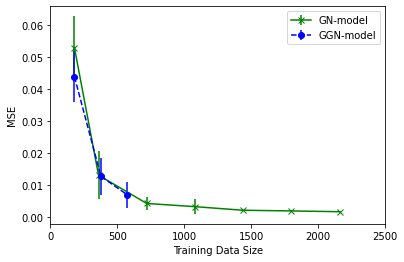

In [23]:
plt.errorbar(adjusted_test_data_numbers_GN, TL_Raman_model_results_GN, yerr=standard_devs_Raman_GN, label='GN-model', marker='x', color='g')
### add this is with the GGN model ###
plt.errorbar(adjusted_test_data_numbers_GGN, TL_Raman_model_results_GGN, yerr=standard_devs_Raman_GGN, label='GGN-model', marker='o', color='b', linestyle='--')
plt.ylabel('MSE')
plt.xlabel('Training Data Size')
plt.xlim([0,2500])
plt.legend()
plt.savefig(f'{data_path}/Figures/Transfer_Learning/transfer_learning_Raman_cross_validation.svg', bbox_inches='tight', format='svg', dpi=1200)
plt.show()

In [24]:
print(standard_devs_Raman_GN[-1])
print(TL_Raman_model_results_GN[-1])

0.00015104397626179323
0.0015517539926804603


In [25]:
print(standard_devs_Raman_GGN[-1])
print(TL_Raman_model_results_GGN[-1])

0.003942806357988008
0.00680324798449874


In [26]:
# 0.00015104397626179323
# 0.0015517539926804603


# 0.003942806357988008
# 0.00680324798449874